# All oscillation analysis

Brief 1-2 sentence description of notebook.

In [1]:
# Imports of all used packages and libraries
import sys
import os
import git
import glob
from collections import defaultdict

In [2]:
git_repo = git.Repo(".", search_parent_directories=True)
git_root = git_repo.git.rev_parse("--show-toplevel")

In [3]:
git_root

'C:/Users/ryoiwata/Documents/GitHub/reward_comp_ext'

In [4]:
sys.path.insert(0, os.path.join(git_root, 'src'))

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
import os
import collections
import itertools
from collections import defaultdict
from itertools import combinations

In [7]:
# Imports of all used packages and libraries
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import mannwhitneyu


In [8]:
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import colorsys

In [9]:
from sklearn.metrics import confusion_matrix

In [10]:
import seaborn as sns


In [11]:
from matplotlib.ticker import FormatStrFormatter

In [12]:
FONTSIZE = 20

In [13]:
font = {'weight' : 'medium',
        'size'   : 20}

matplotlib.rc('font', **font)

In [14]:
BAND_TO_FREQ_PLOT = {'theta': (4, 12), 'gamma': (30, 50)}
BAND_TO_FREQ_COLOR = {'theta': "darkorange", 'beta': "blue", 'gamma': "olive"}

## Inputs & Data

In [15]:
EPHYS_SAMPLE_RATE = 20000

In [16]:
GOOD_SUBJECTS = ["3.1", "3.3", "3.4", "4.2", "4.3", "5.2", "5.3"]

In [17]:
label_to_ticks = {'rewarded': "alone\nrewarded", 'win_no_comp': "win\nnon-comp", 'lose_no_comp': "lose\nnon-comp", 'win_competitive': "win\ncomp",
       'lose_competitive': "lose\ncomp"}

Explanation of each input and where it comes from.

In [18]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case
OUTPUT_DIR = r"./proc/" # where data is saved should always be shown in the inputs
os.makedirs(OUTPUT_DIR, exist_ok=True)
OUTPUT_PREFIXES = ["rce_pilot_3_alone_comp", "rce_pilot_3_long_comp"]
OUTPUT_PREFIX = "rce_pilot_3_combined"

In [19]:
# TRIAL_LABELS_DF = pd.read_excel("/blue/npadillacoreano/ryoi360/projects/reward_comp/repos/reward_comp_ext/results/2024_06_26_sleap_clustering/data/rce_pilot_3_alone_comp_per_video_trial_labels.xlsx")
TRIALS_AND_SPECTRAL_DF = pd.concat([pd.read_pickle("./proc/{}_10_per_trial_spectral_bans_sleap.pkl".format(prefix)) for prefix in OUTPUT_PREFIXES])

In [20]:
FULL_LFP_TRACES_PKL = "{}_12_per_cluster_spectral_bans_sleap.pkl".format(OUTPUT_PREFIX)

## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

## Functions 

In [21]:
# Define a function to horizontally stack arrays
def stack_arrays(arrays):
    return np.vstack(arrays)

In [22]:
def equal_sample(df, group_col):
    # Find the size of the smallest group
    min_size = df[group_col].value_counts().min()
    
    # Randomly sample each group to have equal number of rows
    df_sampled = df.groupby(group_col).apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)
    
    return df_sampled

In [23]:
def combine_dicts(dicts):
    """
    Combine lists from multiple dictionaries that share the same key.

    This function takes a list of dictionaries where each dictionary's values are lists of numbers.
    It merges these lists for each corresponding key across all dictionaries, producing a single
    dictionary where each key has a combined list of all numbers from the input dictionaries.

    Parameters:
        dicts (list of dict): A list of dictionaries with values as lists of numbers.

    Returns:
        dict: A dictionary with keys from the input dictionaries and values as merged lists 
        of numbers from all corresponding input dictionary values.
    """
    combined = defaultdict(list)
    for dictionary in dicts:
        for key, value in dictionary.items():
            combined[key].extend(value)
    
    return dict(combined)


# Example usage
list_of_dicts = [
    {'a': [1, 2], 'b': [3, 4]},
    {'a': [5], 'b': [6, 7]},
    {'a': [8, 9], 'c': [10]}
]

combined_dict = combine_dicts(list_of_dicts)
print(combined_dict)

{'a': [1, 2, 5, 8, 9], 'b': [3, 4, 6, 7], 'c': [10]}


In [24]:
def find_consecutive_ranges(numbers, min_length=1):
    """
    Finds the start and end indices for consecutive ranges of each number in a list where the range meets a minimum length.

    This function iterates through a list of integers and identifies ranges where the same integer appears consecutively
    and the length of this sequence meets or exceeds the specified minimum length.

    Parameters:
        numbers (list): A list of integers to analyze for consecutive ranges.
        min_length (int): The minimum length of a range for it to be included in the results.

    Returns:
        dict: A dictionary with integers as keys and a list of tuples (start, end) as values,
              where each tuple represents the start and end indices (inclusive) of consecutive ranges
              for that integer. Only ranges that meet or exceed the minimum length are included.
    """
    ranges = {}
    n = len(numbers)
    if n == 0:
        return ranges
    
    start = 0
    current = numbers[0]

    for i in range(1, n):
        if numbers[i] != current:
            if (i - start) >= min_length:
                if current not in ranges:
                    ranges[current] = []
                ranges[current].append((start, i - 1))
            current = numbers[i]
            start = i

    # Handle the last range
    if (n - start) >= min_length:
        if current not in ranges:
            ranges[current] = []
        ranges[current].append((start, n - 1))

    return ranges

# Example usage:
numbers = [1, 1, 2, 2, 2, 3, 3, 3, 3, 2, 2, 1, 1]
print(find_consecutive_ranges(numbers, min_length=3))

{2: [(2, 4)], 3: [(5, 8)]}


In [25]:
def update_tuples_in_dict(original_dict, reference_list):
    """
    Updates the values in the tuples within a dictionary by replacing indices with corresponding values from a reference list.
    
    This function iterates through each key-value pair in the original dictionary. Each value is expected to be a list of tuples,
    where each tuple contains indices. These indices are used to fetch corresponding values from the reference list, creating new tuples.
    
    Parameters:
        original_dict (dict): Dictionary whose values are lists of tuples. Each tuple consists of indices into the reference_list.
        reference_list (list): List of elements that are referenced by the indices in the tuples of the original_dict.
        
    Returns:
        dict: A dictionary with the same keys as original_dict but with tuples transformed to contain elements from reference_list
              based on the indices in the original tuples.
    """
    # Create a new dictionary to store the updated key-value pairs
    new_dict = {}
    for key, list_of_tuples in original_dict.items():
        # Process each tuple in the list associated with the current key
        updated_tuples = [
            tuple(reference_list[idx] for idx in tup) for tup in list_of_tuples
        ]
        new_dict[key] = updated_tuples
    
    return new_dict

# Example usage:
original_dict = {
    'a': [(0, 1), (2, 3)],
    'b': [(1, 3), (0, 2)]
}
reference_list = ['alpha', 'beta', 'gamma', 'delta']

updated_dict = update_tuples_in_dict(original_dict, reference_list)
print(updated_dict)

{'a': [('alpha', 'beta'), ('gamma', 'delta')], 'b': [('beta', 'delta'), ('alpha', 'gamma')]}


In [26]:
def update_tuples_in_list(original_list, reference_list):
    """
    Updates the values in the tuples within a list by replacing indices with corresponding values from a reference list.
    
    This function iterates through each tuple in the original list. Each tuple is expected to contain indices.
    These indices are used to fetch corresponding values from the reference list, creating new tuples.
    
    Parameters:
        original_list (list): List of tuples. Each inner tuple consists of indices into the reference_list.
        reference_list (list): List of elements that are referenced by the indices in the tuples of the original_list.
        
    Returns:
        list: A list with the same structure as original_list but with tuples transformed to contain elements from reference_list
              based on the indices in the original tuples.
    """
    # Create a new list to store the updated tuples
    new_list = [
        tuple(reference_list[idx] for idx in tup) for tup in original_list
    ]
    
    return new_list

# Example usage:
original_list = [
    (0, 1), (2, 3),
    (1, 3), (0, 2)
]
reference_list = ['alpha', 'beta', 'gamma', 'delta']

updated_list = update_tuples_in_list(original_list, reference_list)
print(updated_list)

[('alpha', 'beta'), ('gamma', 'delta'), ('beta', 'delta'), ('alpha', 'gamma')]


In [27]:
def find_indices_within_ranges(ranges_list, values):
    """
    Finds the indices of values that fall within specified ranges.
    
    Parameters:
        ranges_list (list): A list of tuples representing ranges.
        values (list): A list of values to check against the ranges.
        
    Returns:
        list: A list of sorted indices for values within the ranges.
    """
    matched_indices = []
    for index, value in enumerate(values):
        if any(start <= value <= end for start, end in ranges_list):
            matched_indices.append(index)
    
    return sorted(matched_indices)

# Example usage:
ranges_list = [(1, 5), (10, 15), (0, 2), (4, 8)]
values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

result = find_indices_within_ranges(ranges_list, values)
print(result)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15]


In [28]:
def adjust_frame_range(frame_range, event_range):
    """
    Adjusts the frame range based on the event range.

    Parameters:
        frame_range (tuple): The tuple representing the start and end of the frame range.
        event_range (tuple): The tuple representing the start and end of the event range.

    Returns:
        tuple or None: Adjusted frame range or None if there's no overlap.
    """
    # Unpack the ranges
    frame_start, frame_end = frame_range
    event_start, event_end = event_range

    # Check for overlap
    if frame_end < event_start or frame_start > event_end:
        return None  # No overlap

    # Adjust the start and end of the frame range
    adjusted_start = max(frame_start, event_start)
    adjusted_end = min(frame_end, event_end)

    return (adjusted_start, adjusted_end)

# Example Usage:
frame_range = (10, 20)
event_range = (15, 25)
result = adjust_frame_range(frame_range, event_range)
print(result)  # Output will be (15, 20)


(15, 20)


In [29]:
def get_signficance_stars(p_value):
    """
    """
    if p_value <= 0.001:
        return "***"
    elif p_value <= 0.01:
        return "**"
    elif p_value <= 0.05:
        return "*"
    else:
        return ""

In [30]:
valid_comparisons = [
                    # 'rewarded - lose_no_comp', 
                    'rewarded - win_competitive',
                    'rewarded - lose_competitive', 
                    # 'win_no_comp - lose_competitive',
                    'win_no_comp - lose_no_comp', 
                    'win_no_comp - win_competitive',
                    # 'lose_no_comp - win_competitive',
                    'lose_no_comp - lose_competitive',
                    'win_competitive - lose_competitive', 
                    'rewarded - win_no_comp'
                    ]

In [31]:
OUTCOME_TO_COLOR = {"both_rewarded": "green", 
"novel_lose": "#e67073",
"novel_win": "#93a5da",
"lose": "#951a1d",
"alone_rewarded": "#0499af",
"win": "#3853a3",
"omission": "orange",
"tie": "green"}

In [32]:
comp_id_to_color = {'competitive_1': "#281640",
'competitive_2': "#43246a",
'competitive_3': "#8e7ca6",
'no_comp_4': "#2f3600",
'no_comp_5': "#535f00",
'no_comp_6': "#768800",
'no_comp_7': "#9fac4d",
'no_comp_8': "#c8cf99",
'competitive': "#43246A",
'no_comp': "#768800",
'win': "#0045A6",
'win_competitive': "#003074",
'win_no_comp': "#4d7dc1",
'lose': "#792910",
'lose_competitive': "#551d0b",
'lose_no_comp': "#a16958",
'rewarded': "#FFAF00"
}

In [33]:
to_keep_columns = ['trial_label',
'tone_start_frame',
'reward_start',
'reward_dispensed',
'tone_stop_frame',
'condition',
'competition_closeness',
'get_reward_frame',
'out_reward_frame',
'notes',
'box_1_port_entry_frames',
'box_2_port_entry_frames',
'video_name',
'tone_start_timestamp',
'tone_stop_timestamp',
'box_1_port_entry_timestamps',
'box_2_port_entry_timestamps',
'current_subject',
'session_dir',
'experiment',
'sleap_name',
'video_id',
'agent',
'all_subjects',
'cohort',
'first_timestamp',
'last_timestamp',
'recording',
'session_path',
'subject',
'baseline_start_timestamp',
'post_trial_end_timestamp',]

## Processing

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

In [34]:
# As much code and as many cells as required
# includes EDA and playing with data
# GO HAM!

# Ideally functions are defined here first and then data is processed using the functions

# function names are short and in snake case all lowercase
# a function name should be unique but does not have to describe the function
# doc strings describe functions not function names




## Renaming the trial labels

In [35]:
TRIALS_AND_SPECTRAL_DF.head()

tone_start_frame  reward_start  reward_dispensed  tone_stop_frame  \
0              1272          1352            1372.0             1471   
1              1272          1352            1372.0             1471   
2              3268          3348            3368.0             3469   
3              3268          3348            3368.0             3469   
4              4466          4546            4566.0             4667   

  condition competition_closeness  get_reward_frame  out_reward_frame  \
0  rewarded                   NaN               NaN               NaN   
1  rewarded                   NaN               NaN               NaN   
2  rewarded                   NaN               NaN               NaN   
3  rewarded                   NaN               NaN               NaN   
4  rewarded                   NaN               NaN               NaN   

   experiment                                     video_name  ...  \
0  alone_comp  20240320_142408_alone_comp_subj_3-1_and_3-3.1  ...   
1  alone_comp  20240320_142408_alone_comp_subj_3-1_and_3-3.1  ...   
2  alone_comp  20240320_142408_alone_comp_subj_3-1_and_3-3.1  ...   
3  alone_comp  20240320_142408_alone_comp_subj_3-1_and_3-3.1  ...   
4  alone_comp  20240320_142408_alone_comp_subj_3-1_and_3-3.1  ...   

                           baseline_mPFC_gamma_phase  \
0  [-2.6797059, -2.3968484, -2.1131911, -1.828970...   
1  [-1.0192864, -0.7884174, -0.5577601, -0.327317...   
2  [0.032740027, 0.27976346, 0.52697045, 0.774348...   
3  [1.9588519, 2.221262, 2.4844332, 2.7484064, 3....   
4  [2.3436375, 2.551059, 2.757349, 2.9625306, -3....   

                             baseline_mPFC_lfp_trace  \
0  [45.434998, 53.039997, 63.569996, 94.575, 114....   
1  [232.635, 241.79999, 253.49998, 259.935, 290.5...   
2  [128.50499, 109.979996, 77.415, 22.619999, -20...   
3  [56.55, -39.195, -152.09999, -172.185, -144.10...   
4  [60.644997, 38.805, 30.81, 48.554996, 77.805, ...   

                            baseline_mPFC_theta_band  \
0  [0.3023039, 0.3250822, 0.34729052, 0.3688477, ...   
1  [0.86803913, 0.8516945, 0.83444965, 0.8164087,...   
2  [0.31883484, 0.304557, 0.28981718, 0.27463654,...   
3  [0.019023584, 0.033879466, 0.04848842, 0.06283...   
4  [0.60134304, 0.6429786, 0.68366385, 0.7233099,...   

                           baseline_mPFC_theta_phase  \
0  [-0.788324, -0.7305608, -0.67332137, -0.616575...   
1  [0.042734537, 0.07712564, 0.1110838, 0.1445905...   
2  [0.82180655, 0.86382616, 0.90566295, 0.9473232...   
3  [-1.5093546, -1.4610933, -1.4133036, -1.365974...   
4  [-1.0260117, -0.98588574, -0.9458348, -0.90586...   

                            baseline_vHPC_gamma_band  \
0  [0.11822242, 0.026445314, -0.061667122, -0.141...   
1  [0.04515997, 0.09145398, 0.13580361, 0.1756941...   
2  [-0.1966364, -0.20901106, -0.2086731, -0.19691...   
3  [-0.034169298, -0.058782697, -0.0758774, -0.08...   
4  [-0.031517684, 0.033092283, 0.09645234, 0.1545...   

                           baseline_vHPC_gamma_phase  \
0  [1.2789538, 1.5046133, 1.7300067, 1.9551437, 2...   
1  [-1.3614203, -1.1462942, -0.92886734, -0.70931...   
2  [2.5922303, 2.8197713, 3.0456688, -3.0136209, ...   
3  [1.9731913, 2.3358655, 2.7034516, 3.0720255, -...   
4  [-1.6889625, -1.4474249, -1.2057016, -0.963856...   

                             baseline_vHPC_lfp_trace  \
0  [-4.875, -0.39, 26.519999, 62.399998, 69.615, ...   
1  [221.715, 238.09499, 259.935, 264.03, 253.305,...   
2  [-46.995, -35.489998, -35.684998, -43.484997, ...   
3  [0.78, 53.82, 101.59499, 119.729996, 94.77, 49...   
4  [223.665, 226.39499, 232.04999, 241.995, 243.1...   

                            baseline_vHPC_theta_band  \
0  [0.45442012, 0.4403637, 0.4263141, 0.4122978, ...   
1  [0.49248752, 0.49964046, 0.50668645, 0.5136666...   
2  [0.24851131, 0.20672616, 0.16414632, 0.1208212...   
3  [-0.0010840435, 0.03636438, 0.0744549, 0.11305...   
4  [1.0194497, 1.0016606, 0.98306626, 0.9636855, ...   

                    

In [36]:
comp_closeness_dict = {'Subj 1 blocking Subj 2': "competitive",
'Subj 2 Only': "no_comp",
'Subj 2 blocking Subj 1': "competitive",
'Subj 1 then Subj 2': "competitive", 
'Subj 1 Only': "no_comp",
'Subj 2 then Subj 1': "competitive",
'Close Call': "competitive",
'After trial': "no_comp"}

```
Win base color
#0045A6 
Win competitive color
#003074
Win no comp color
#4d7dc1

Lose base color
#792910
Lose competitive color
#551d0b
Lose no comp color
#a16958
```

In [37]:
TRIALS_AND_SPECTRAL_DF["current_subject"] = TRIALS_AND_SPECTRAL_DF["current_subject"].apply(lambda x: str(x).strip().lower())

In [38]:
TRIALS_AND_SPECTRAL_DF = TRIALS_AND_SPECTRAL_DF[TRIALS_AND_SPECTRAL_DF["current_subject"].isin(GOOD_SUBJECTS)]

In [39]:
TRIALS_AND_SPECTRAL_DF["current_subject"].unique()

array(['3.1', '3.3', '4.2', '4.3', '3.4', '5.2', '5.3'], dtype=object)

In [40]:
TRIALS_AND_SPECTRAL_DF = TRIALS_AND_SPECTRAL_DF[TRIALS_AND_SPECTRAL_DF["condition"] != "tie"].reset_index(drop=True)

In [41]:
TRIALS_AND_SPECTRAL_DF = TRIALS_AND_SPECTRAL_DF[TRIALS_AND_SPECTRAL_DF["condition"] != "temp"].reset_index(drop=True)

In [42]:
TRIALS_AND_SPECTRAL_DF["condition"].unique()

array(['rewarded', 3.1, 3.3, 4.3, 3.4, 4.4, 5.3, 4.2, 5.4, 5.2],
      dtype=object)

In [43]:
TRIALS_AND_SPECTRAL_DF["condition"] = TRIALS_AND_SPECTRAL_DF["condition"].apply(lambda x: str(x).strip().lower())

In [44]:
TRIALS_AND_SPECTRAL_DF["trial_label"] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: "win" if x["current_subject"] == x["condition"]  else ("lose" if x["agent"] == x["condition"] else x["condition"]), axis=1)
                                                                        

In [45]:
TRIALS_AND_SPECTRAL_DF["trial_label"].unique()

array(['rewarded', 'win', 'lose'], dtype=object)

In [46]:
TRIALS_AND_SPECTRAL_DF["competition_closeness"] = TRIALS_AND_SPECTRAL_DF["competition_closeness"].map(comp_closeness_dict).fillna("rewarded")

In [47]:
TRIALS_AND_SPECTRAL_DF["trial_label"].unique()

array(['rewarded', 'win', 'lose'], dtype=object)

In [48]:
TRIALS_AND_SPECTRAL_DF["competition_closeness"].unique()

array(['rewarded', 'no_comp', 'competitive'], dtype=object)

## Making separate rows for each cluster

In [49]:
TRIALS_AND_SPECTRAL_DF["competitiveness_frame_ranges_dict"]

0                                                     NaN
1                                                     NaN
2                                                     NaN
3                                                     NaN
4                                                     NaN
                              ...                        
1138    {'competitive': [(50311, 50319), (50462, 50491...
1139    {'no_comp': [(51709, 51822), (52220, 52250), (...
1140    {'no_comp': [(51709, 51822), (52220, 52250), (...
1141    {'competitive': [(53904, 53948), (53980, 54023...
1142    {'competitive': [(53904, 53948), (53980, 54023...
Name: competitiveness_frame_ranges_dict, Length: 1143, dtype: object

In [50]:
TRIALS_AND_SPECTRAL_DF[TRIALS_AND_SPECTRAL_DF["trial_label"] != "rewarded"]["competitiveness_frame_ranges_dict"].iloc[0]

{np.str_('competitive'): [(np.int64(34040), np.int64(34045)),
  (np.int64(34241), np.int64(34257)),
  (np.int64(34264), np.int64(34298)),
  (np.int64(34433), np.int64(34536)),
  (np.int64(34545), np.int64(34639))],
 np.str_('no_comp'): [(np.int64(34046), np.int64(34240)),
  (np.int64(34258), np.int64(34263)),
  (np.int64(34299), np.int64(34432)),
  (np.int64(34537), np.int64(34544))]}

In [51]:
TRIALS_AND_SPECTRAL_DF["tone_start_frame"].head()

0    1272
1    1272
2    3268
3    3268
4    4466
Name: tone_start_frame, dtype: int64

In [52]:
TRIALS_AND_SPECTRAL_DF["tone_stop_frame"]

0        1471
1        1471
2        3469
3        3469
4        4667
        ...  
1138    50711
1139    52108
1140    52108
1141    54304
1142    54304
Name: tone_stop_frame, Length: 1143, dtype: int64

- Making each dictionary into a list so that we can explode it

In [53]:
dict_col = [col for col in TRIALS_AND_SPECTRAL_DF.columns if "dict" in col and "competitiveness" in col]


In [54]:
dict_col

['competitiveness_index_ranges_dict', 'competitiveness_frame_ranges_dict']

In [55]:
TRIALS_AND_SPECTRAL_DF[TRIALS_AND_SPECTRAL_DF["trial_label"] != "rewarded"]["competitiveness_index_ranges_dict"].iloc[0]

{np.str_('competitive'): [(0, 5),
  (201, 217),
  (224, 258),
  (393, 496),
  (505, 599)],
 np.str_('no_comp'): [(6, 200), (218, 223), (259, 392), (497, 504)]}

In [56]:
for col in dict_col:
    TRIALS_AND_SPECTRAL_DF[col] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: list(x[col].items()) if isinstance(x[col], dict) else [("rewarded", [(x["tone_start_frame"], x["tone_stop_frame"])])], axis=1)

In [57]:
TRIALS_AND_SPECTRAL_DF["competitiveness_frame_ranges_dict"].head()

0    [(rewarded, [(1272, 1471)])]
1    [(rewarded, [(1272, 1471)])]
2    [(rewarded, [(3268, 3469)])]
3    [(rewarded, [(3268, 3469)])]
4    [(rewarded, [(4466, 4667)])]
Name: competitiveness_frame_ranges_dict, dtype: object

In [58]:
TRIALS_AND_SPECTRAL_DF[TRIALS_AND_SPECTRAL_DF["trial_label"] != "rewarded"]["competitiveness_frame_ranges_dict"].head()

42    [(competitive, [(np.int64(34040), np.int64(340...
43    [(competitive, [(np.int64(34040), np.int64(340...
44    [(no_comp, [(np.int64(35038), np.int64(35090))...
45    [(no_comp, [(np.int64(35038), np.int64(35090))...
46    [(no_comp, [(np.int64(36137), np.int64(36386))...
Name: competitiveness_frame_ranges_dict, dtype: object

- Exploding each row so that competitive and non-competitive clusters are on different rows

In [59]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF = TRIALS_AND_SPECTRAL_DF.explode(column=dict_col)

In [60]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF["competitiveness_frame_ranges_dict"].head()

0    (rewarded, [(1272, 1471)])
1    (rewarded, [(1272, 1471)])
2    (rewarded, [(3268, 3469)])
3    (rewarded, [(3268, 3469)])
4    (rewarded, [(4466, 4667)])
Name: competitiveness_frame_ranges_dict, dtype: object

In [61]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF[cluster_exploded_TRIALS_AND_SPECTRAL_DF["trial_label"] != "rewarded"]["competitiveness_frame_ranges_dict"].head()

42    (competitive, [(34040, 34045), (34241, 34257),...
42    (no_comp, [(34046, 34240), (34258, 34263), (34...
43    (competitive, [(34040, 34045), (34241, 34257),...
43    (no_comp, [(34046, 34240), (34258, 34263), (34...
44    (no_comp, [(35038, 35090), (35167, 35172), (35...
Name: competitiveness_frame_ranges_dict, dtype: object

- Making a new column based on the key which is the competitiveness of the group

In [62]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF["competitiveness_label"] = cluster_exploded_TRIALS_AND_SPECTRAL_DF["competitiveness_frame_ranges_dict"].apply(lambda x: str(x[0]))

In [63]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF["competitiveness_label"].iloc[0]

'rewarded'

In [64]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF["competitiveness_label"].head()

0    rewarded
1    rewarded
2    rewarded
3    rewarded
4    rewarded
Name: competitiveness_label, dtype: object

In [65]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF[cluster_exploded_TRIALS_AND_SPECTRAL_DF["trial_label"] != "rewarded"]["competitiveness_label"].head()

42    competitive
42        no_comp
43    competitive
43        no_comp
44        no_comp
Name: competitiveness_label, dtype: object

- Filtering rows that don't have matching frame and trial competitiveness

In [66]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF["competitiveness_label"].unique()

array(['rewarded', 'competitive', 'no_comp'], dtype=object)

In [67]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF["competition_closeness"].unique()

array(['rewarded', 'no_comp', 'competitive'], dtype=object)

In [68]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF.shape

(1752, 410)

In [69]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF = cluster_exploded_TRIALS_AND_SPECTRAL_DF[cluster_exploded_TRIALS_AND_SPECTRAL_DF["competition_closeness"] == cluster_exploded_TRIALS_AND_SPECTRAL_DF["competitiveness_label"]].reset_index(drop=True)

In [70]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF.shape

(1143, 410)

- Combining the competitiveness and the trial outcome labels

In [71]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF["trial_and_competitiveness_label"] = cluster_exploded_TRIALS_AND_SPECTRAL_DF.apply(lambda x: "_".join([x["trial_label"], x["competitiveness_label"]]) if  x["trial_label"] != x["competitiveness_label"] else x["trial_label"], axis=1)

In [72]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF["trial_and_competitiveness_label"].unique()

array(['rewarded', 'win_no_comp', 'lose_no_comp', 'win_competitive',
       'lose_competitive'], dtype=object)

- Making a new column that is the range of frames

In [73]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF["competitiveness_frame_ranges"] = cluster_exploded_TRIALS_AND_SPECTRAL_DF["competitiveness_frame_ranges_dict"].apply(lambda x: x[1])

In [74]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF["competitiveness_frame_ranges"].head()

0    [(1272, 1471)]
1    [(1272, 1471)]
2    [(3268, 3469)]
3    [(3268, 3469)]
4    [(4466, 4667)]
Name: competitiveness_frame_ranges, dtype: object

In [75]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF[cluster_exploded_TRIALS_AND_SPECTRAL_DF["trial_label"] != "rewarded"]["competitiveness_frame_ranges"].head()

42    [(34046, 34240), (34258, 34263), (34299, 34432...
43    [(34046, 34240), (34258, 34263), (34299, 34432...
44    [(35091, 35166), (35173, 35200), (35249, 35334...
45    [(35091, 35166), (35173, 35200), (35249, 35334...
46    [(36137, 36386), (36438, 36503), (36509, 36516...
Name: competitiveness_frame_ranges, dtype: object

- Filtering for ranges that are only during the trial

In [76]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF["tone_start_frame"]

0        1272
1        1272
2        3268
3        3268
4        4466
        ...  
1138    50511
1139    51909
1140    51909
1141    54104
1142    54104
Name: tone_start_frame, Length: 1143, dtype: int64

In [77]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF["tone_stop_frame"]

0        1471
1        1471
2        3469
3        3469
4        4667
        ...  
1138    50711
1139    52108
1140    52108
1141    54304
1142    54304
Name: tone_stop_frame, Length: 1143, dtype: int64

In [78]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF["competitiveness_frame_ranges"] = cluster_exploded_TRIALS_AND_SPECTRAL_DF.apply(lambda x: [adjust_frame_range((start, stop), (x["tone_start_frame"], x["tone_stop_frame"])) for start, stop in x["competitiveness_frame_ranges"] if adjust_frame_range((start, stop), (x["tone_start_frame"], x["tone_stop_frame"]))], axis=1)

- Filtering for rows that have at least one consecutive second

In [79]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF = cluster_exploded_TRIALS_AND_SPECTRAL_DF[cluster_exploded_TRIALS_AND_SPECTRAL_DF["competitiveness_frame_ranges"].apply(lambda x: len(x) >= 1)]

- Filtering for ranges that are 1 second consecutive

In [80]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF["competitiveness_frame_ranges"] = cluster_exploded_TRIALS_AND_SPECTRAL_DF["competitiveness_frame_ranges"].apply(lambda x: [(start, stop) for start, stop in x if stop - start >= 20])

- Calculating the total number of frames for each trial

In [81]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF["frame_ranges_sum_frames"] = cluster_exploded_TRIALS_AND_SPECTRAL_DF["competitiveness_frame_ranges"].apply(lambda x: sum([stop - start for start, stop in x]))

In [82]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF["frame_ranges_sum_frames"]

0       199
1       199
2       201
3       201
4       201
       ... 
1138     69
1139    199
1140    199
1141    151
1142    151
Name: frame_ranges_sum_frames, Length: 1136, dtype: int64

- Filtering for rows where at least half the frames are there

In [83]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF = cluster_exploded_TRIALS_AND_SPECTRAL_DF[cluster_exploded_TRIALS_AND_SPECTRAL_DF["frame_ranges_sum_frames"] >= 100]

In [84]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF["competitiveness_frame_ranges"]

0                         [(1272, 1471)]
1                         [(1272, 1471)]
2                         [(3268, 3469)]
3                         [(3268, 3469)]
4                         [(4466, 4667)]
                      ...               
1136    [(49514, 49589), (49676, 49713)]
1139                    [(51909, 52108)]
1140                    [(51909, 52108)]
1141    [(54120, 54212), (54245, 54304)]
1142    [(54120, 54212), (54245, 54304)]
Name: competitiveness_frame_ranges, Length: 1010, dtype: object

- Filtering for rows that have at least one consecutive second

In [85]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF = cluster_exploded_TRIALS_AND_SPECTRAL_DF[cluster_exploded_TRIALS_AND_SPECTRAL_DF["competitiveness_frame_ranges"].apply(lambda x: len(x) >= 1)]

In [86]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF["competitiveness_frame_ranges"]

0                         [(1272, 1471)]
1                         [(1272, 1471)]
2                         [(3268, 3469)]
3                         [(3268, 3469)]
4                         [(4466, 4667)]
                      ...               
1136    [(49514, 49589), (49676, 49713)]
1139                    [(51909, 52108)]
1140                    [(51909, 52108)]
1141    [(54120, 54212), (54245, 54304)]
1142    [(54120, 54212), (54245, 54304)]
Name: competitiveness_frame_ranges, Length: 1010, dtype: object

In [87]:
for col in cluster_exploded_TRIALS_AND_SPECTRAL_DF.columns:
    # print(col)
    pass

## Adding the velocity

In [88]:
alone_trials_df = pd.read_pickle("../2024_06_26_sleap_clustering/proc/alone_trials_sleap.pkl")

In [89]:
alone_trials_df.columns

Index(['unnamed: 0', 'session_dir', 'tone_start_frame', 'reward_start',
       'reward_dispensed', 'tone_stop_frame', 'condition',
       'competition_closeness', 'get_reward_frame', 'out_reward_frame',
       'notes', 'experiment', 'box_1_port_entry_frames',
       'box_2_port_entry_frames', 'video_name', 'all_subjects',
       'first_timestamp', 'last_timestamp', 'tone_start_timestamp',
       'tone_stop_timestamp', 'box_1_port_entry_timestamps',
       'box_2_port_entry_timestamps', '10s_before_tone_frame',
       '10s_after_tone_frame', 'tone_start_to_stop_frame', 'start_frame',
       'stop_frame', 'tracked_subject', 'in_video_subjects', 'box_number',
       'sleap_name', 'current_subject', 'body_parts', 'box_top_right',
       'box_bottom_right', 'box_top_left', 'reward_port', 'box_bottom_left',
       'agent', 'subject_locations', 'agent_locations', 'frame_index',
       'subject_thorax', 'subject_nose', 'subject_tail_base', 'agent_thorax',
       'agent_nose', 'agent_tail_base'

In [90]:
alone_trials_df["subject_thorax_velocity"].apply(lambda x: x.shape)

0      (599,)
1      (601,)
2      (601,)
3      (599,)
4      (599,)
        ...  
289    (601,)
290    (599,)
291    (599,)
292    (600,)
293    (601,)
Name: subject_thorax_velocity, Length: 294, dtype: object

In [91]:
alone_trials_df["trial_subject_thorax_velocity"] = alone_trials_df["subject_thorax_velocity"].apply(lambda x: x[199:399])

In [92]:
alone_trials_df["trial_frame_index"] = alone_trials_df["frame_index"].apply(lambda x: x[199:399])

In [93]:
alone_trial_to_velocity = {(row['session_dir'], row['current_subject'], row['tone_start_timestamp']): row['trial_subject_thorax_velocity'] for index, row in alone_trials_df.iterrows()}

In [94]:
alone_trial_to_frame_index = {(row['session_dir'], row['current_subject'], row['tone_start_timestamp']): row['trial_frame_index'] for index, row in alone_trials_df.iterrows()}

In [95]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF["trial_subject_thorax_velocity"] = cluster_exploded_TRIALS_AND_SPECTRAL_DF.apply(lambda row: alone_trial_to_velocity[(row['session_dir'], row['current_subject'], row['tone_start_timestamp'])] if (row['session_dir'], row['current_subject'], row['tone_start_timestamp']) in alone_trial_to_velocity else row["trial_subject_thorax_velocity"], axis=1)

In [96]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF["trial_frame_index"] = cluster_exploded_TRIALS_AND_SPECTRAL_DF.apply(lambda row: alone_trial_to_frame_index[(row['session_dir'], row['current_subject'], row['tone_start_timestamp'])] if (row['session_dir'], row['current_subject'], row['tone_start_timestamp']) in alone_trial_to_frame_index else row["trial_frame_index"], axis=1)

In [97]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF["trial_subject_thorax_velocity"].iloc[:5].apply(lambda x: x.shape)

0    (200,)
1    (200,)
2    (200,)
3    (200,)
4    (200,)
Name: trial_subject_thorax_velocity, dtype: object

In [98]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF["trial_frame_index"].iloc[:5].apply(lambda x: x.shape)

0    (200,)
1    (200,)
2    (200,)
3    (200,)
4    (200,)
Name: trial_frame_index, dtype: object

In [99]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF["trial_video_timestamps"] = cluster_exploded_TRIALS_AND_SPECTRAL_DF.apply(lambda x: x["video_timestamps"][x["trial_frame_index"]] if isinstance(pd.isna(x["trial_video_timestamps"]), bool) else x["trial_video_timestamps"], axis=1)

- Getting the timestamps for each frame

In [100]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF["competitiveness_timestamp_ranges"] = cluster_exploded_TRIALS_AND_SPECTRAL_DF.apply(lambda x: update_tuples_in_list(x["competitiveness_frame_ranges"], x["video_timestamps"]), axis=1)

In [101]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF[cluster_exploded_TRIALS_AND_SPECTRAL_DF["trial_label"] != "rewarded"]["competitiveness_timestamp_ranges"]

42                                 [(34336303, 34469346)]
43                                 [(34336303, 34469346)]
44      [(35288395, 35372933), (35395107, 35422824), (...
45      [(35288395, 35372933), (35395107, 35422824), (...
46           [(36377688, 36427580), (36478857, 36543993)]
                              ...                        
1136         [(49607199, 49682036), (49769346, 49806764)]
1139                               [(52007525, 52207090)]
1140                               [(52007525, 52207090)]
1141         [(54222145, 54314998), (54346873, 54406465)]
1142         [(54222145, 54314998), (54346873, 54406465)]
Name: competitiveness_timestamp_ranges, Length: 506, dtype: object

In [102]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF["competitiveness_timestamp_ranges"]

0                               [(1276384, 1475949)]
1                               [(1276384, 1475949)]
2                               [(3276194, 3477145)]
3                               [(3276194, 3477145)]
4                               [(4476357, 4677308)]
                            ...                     
1136    [(49607199, 49682036), (49769346, 49806764)]
1139                          [(52007525, 52207090)]
1140                          [(52007525, 52207090)]
1141    [(54222145, 54314998), (54346873, 54406465)]
1142    [(54222145, 54314998), (54346873, 54406465)]
Name: competitiveness_timestamp_ranges, Length: 1010, dtype: object

- Getting all the spectral timestamps that are in the ranges

In [103]:
# timestamps_col = [col for col in cluster_exploded_TRIALS_AND_SPECTRAL_DF.columns if "timestamps" in col and "video" not in col and "trial" in col]
timestamps_col = [col for col in cluster_exploded_TRIALS_AND_SPECTRAL_DF.columns if "timestamps" in col and "trial" in col]

In [104]:
timestamps_col

['trial_video_timestamps',
 'trial_coherence_timestamps',
 'trial_granger_timestamps',
 'trial_power_timestamps',
 'trial_lfp_timestamps']

- Getting all the indexes that fit within each range

In [105]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF["trial_lfp_timestamps"]

0       [1275900, 1275920, 1275940, 1275960, 1275980, ...
1       [1275900, 1275920, 1275940, 1275960, 1275980, ...
2       [3275920, 3275940, 3275960, 3275980, 3276000, ...
3       [3275920, 3275940, 3275960, 3275980, 3276000, ...
4       [4475940, 4475960, 4475980, 4476000, 4476020, ...
                              ...                        
1136    [49606260, 49606280, 49606300, 49606320, 49606...
1139    [52006300, 52006320, 52006340, 52006360, 52006...
1140    [52006300, 52006320, 52006340, 52006360, 52006...
1141    [54206320, 54206340, 54206360, 54206380, 54206...
1142    [54206320, 54206340, 54206360, 54206380, 54206...
Name: trial_lfp_timestamps, Length: 1010, dtype: object

In [106]:
for col in timestamps_col:
    base_col = col.replace("trial_", "").replace("timestamps", "index")
    print(base_col)
    cluster_exploded_TRIALS_AND_SPECTRAL_DF["cluster_filtered_{}".format(base_col)] = cluster_exploded_TRIALS_AND_SPECTRAL_DF.apply(lambda x: find_indices_within_ranges(x["competitiveness_timestamp_ranges"], x[col]), axis=1)

video_index
coherence_index
granger_index
power_index
lfp_index


In [107]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF["trial_mPFC_theta_band"].iloc[0].shape

(10000,)

In [108]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF["cluster_filtered_{}".format(base_col)].iloc[0][:10]

[25, 26, 27, 28, 29, 30, 31, 32, 33, 34]

In [109]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF["cluster_filtered_{}".format(base_col)].iloc[0][-10:]

[9990, 9991, 9992, 9993, 9994, 9995, 9996, 9997, 9998, 9999]

In [110]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF.head()

tone_start_frame  reward_start  reward_dispensed  tone_stop_frame  \
0              1272          1352            1372.0             1471   
1              1272          1352            1372.0             1471   
2              3268          3348            3368.0             3469   
3              3268          3348            3368.0             3469   
4              4466          4546            4566.0             4667   

  condition competition_closeness  get_reward_frame  out_reward_frame  \
0  rewarded              rewarded               NaN               NaN   
1  rewarded              rewarded               NaN               NaN   
2  rewarded              rewarded               NaN               NaN   
3  rewarded              rewarded               NaN               NaN   
4  rewarded              rewarded               NaN               NaN   

   experiment                                     video_name  ...  \
0  alone_comp  20240320_142408_alone_comp_subj_3-1_and_3-3.1  ...   
1  alone_comp  20240320_142408_alone_comp_subj_3-1_and_3-3.1  ...   
2  alone_comp  20240320_142408_alone_comp_subj_3-1_and_3-3.1  ...   
3  alone_comp  20240320_142408_alone_comp_subj_3-1_and_3-3.1  ...   
4  alone_comp  20240320_142408_alone_comp_subj_3-1_and_3-3.1  ...   

   competitiveness_label  trial_and_competitiveness_label  \
0               rewarded                         rewarded   
1               rewarded                         rewarded   
2               rewarded                         rewarded   
3               rewarded                         rewarded   
4               rewarded                         rewarded   

  competitiveness_frame_ranges frame_ranges_sum_frames  \
0               [(1272, 1471)]                     199   
1               [(1272, 1471)]                     199   
2               [(3268, 3469)]                     201   
3               [(3268, 3469)]                     201   
4               [(4466, 4667)]                     201   

  competitiveness_timestamp_ranges  \
0             [(1276384, 1475949)]   
1             [(1276384, 1475949)]   
2             [(3276194, 3477145)]   
3             [(3276194, 3477145)]   
4             [(4476357, 4677308)]   

                        cluster_filtered_video_index  \
0  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
1  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
2  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
3  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
4  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   

                    cluster_filtered_coherence_index  \
0  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
1  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
2  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
3  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
4  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   

                      cluster_filtered_granger_index  \
0  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
1  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
2  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
3  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
4  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   

                        cluster_filtered_power_index  \
0  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
1  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
2  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
3  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
4  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   

                          cluster_filtered_lfp_index  
0  [25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 3...  
1  [25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 3...  
2  [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 2...  
3  [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 2...  
4  [21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 3...  

[5 rows x 419 columns]

In [111]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF.tail()

tone_start_frame  reward_start  reward_dispensed  tone_stop_frame  \
1136             49514         49594           49614.0            49713   
1139             51909         51989           52009.0            52108   
1140             51909         51989           52009.0            52108   
1141             54104         54184           54204.0            54304   
1142             54104         54184           54204.0            54304   

     condition competition_closeness  get_reward_frame  out_reward_frame  \
1136       5.3           competitive           49592.0           49703.0   
1139       5.3           competitive           51972.0           52121.0   
1140       5.3           competitive           51972.0           52121.0   
1141       5.3           competitive           54157.0           54286.0   
1142       5.3           competitive           54157.0           54286.0   

     experiment                                    video_name  ...  \
1136  long_comp  20240321_114851_long_comp_subj_5-2_and_5-3.1  ...   
1139  long_comp  20240321_114851_long_comp_subj_5-2_and_5-3.1  ...   
1140  long_comp  20240321_114851_long_comp_subj_5-2_and_5-3.1  ...   
1141  long_comp  20240321_114851_long_comp_subj_5-2_and_5-3.1  ...   
1142  long_comp  20240321_114851_long_comp_subj_5-2_and_5-3.1  ...   

      competitiveness_label  trial_and_competitiveness_label  \
1136            competitive                  win_competitive   
1139            competitive                 lose_competitive   
1140            competitive                  win_competitive   
1141            competitive                 lose_competitive   
1142            competitive                  win_competitive   

          competitiveness_frame_ranges frame_ranges_sum_frames  \
1136  [(49514, 49589), (49676, 49713)]                     112   
1139                  [(51909, 52108)]                     199   
1140                  [(51909, 52108)]                     199   
1141  [(54120, 54212), (54245, 54304)]                     151   
1142  [(54120, 54212), (54245, 54304)]                     151   

                  competitiveness_timestamp_ranges  \
1136  [(49607199, 49682036), (49769346, 49806764)]   
1139                        [(52007525, 52207090)]   
1140                        [(52007525, 52207090)]   
1141  [(54222145, 54314998), (54346873, 54406465)]   
1142  [(54222145, 54314998), (54346873, 54406465)]   

                           cluster_filtered_video_index  \
1136  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
1139  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
1140  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
1141  [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 2...   
1142  [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 2...   

                       cluster_filtered_coherence_index  \
1136           [0, 1, 2, 3, 4, 5, 6, 7, 16, 17, 18, 19]   
1139  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
1140  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
1141  [2, 3, 4, 5, 6, 7, 8, 9, 10, 14, 15, 16, 17, 1...   
1142  [2, 3, 4, 5, 6, 7, 8, 9, 10, 14, 15, 16, 17, 1...   

                         cluster_filtered_granger_index  \
1136           [0, 1, 2, 3, 4, 5, 6, 7, 16, 17, 18, 19]   
1139  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
1140  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
1141  [2, 3, 4, 5, 6, 7, 8, 9, 10, 14, 15, 16, 17, 1...   
1142  [2, 3, 4, 5, 6, 7, 8, 9, 10, 14, 15, 16, 17, 1...   

                           cluster_filtered_power_index  \
1136           [0, 1, 2, 3, 4, 5, 6, 7, 16, 17, 18, 19]   
1139  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
1140  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
1141  [2, 3, 4, 5, 6, 7, 8, 9, 10, 14, 15, 16, 17, 1...   
1142  [2, 3, 4, 5, 6, 7, 8, 9, 10, 14, 15, 16, 17, 1...   

                             cluster_filtered_lfp_index  
1136  [47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 5...  
1139  [62, 63, 64, 65, 66, 67, 68,

In [112]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF[~cluster_exploded_TRIALS_AND_SPECTRAL_DF["video_name"].apply(lambda x: ".2" in x)]

tone_start_frame  reward_start  reward_dispensed  tone_stop_frame  \
0                 1272          1352            1372.0             1471   
1                 1272          1352            1372.0             1471   
2                 3268          3348            3368.0             3469   
3                 3268          3348            3368.0             3469   
4                 4466          4546            4566.0             4667   
...                ...           ...               ...              ...   
1136             49514         49594           49614.0            49713   
1139             51909         51989           52009.0            52108   
1140             51909         51989           52009.0            52108   
1141             54104         54184           54204.0            54304   
1142             54104         54184           54204.0            54304   

     condition competition_closeness  get_reward_frame  out_reward_frame  \
0     rewarded              rewarded               NaN               NaN   
1     rewarded              rewarded               NaN               NaN   
2     rewarded              rewarded               NaN               NaN   
3     rewarded              rewarded               NaN               NaN   
4     rewarded              rewarded               NaN               NaN   
...        ...                   ...               ...               ...   
1136       5.3           competitive           49592.0           49703.0   
1139       5.3           competitive           51972.0           52121.0   
1140       5.3           competitive           51972.0           52121.0   
1141       5.3           competitive           54157.0           54286.0   
1142       5.3           competitive           54157.0           54286.0   

      experiment                                     video_name  ...  \
0     alone_comp  20240320_142408_alone_comp_subj_3-1_and_3-3.1  ...   
1     alone_comp  20240320_142408_alone_comp_subj_3-1_and_3-3.1  ...   
2     alone_comp  20240320_142408_alone_comp_subj_3-1_and_3-3.1  ...   
3     alone_comp  20240320_142408_alone_comp_subj_3-1_and_3-3.1  ...   
4     alone_comp  20240320_142408_alone_comp_subj_3-1_and_3-3.1  ...   
...          ...                                            ...  ...   
1136   long_comp   20240321_114851_long_comp_subj_5-2_and_5-3.1  ...   
1139   long_comp   20240321_114851_long_comp_subj_5-2_and_5-3.1  ...   
1140   long_comp   20240321_114851_long_comp_subj_5-2_and_5-3.1  ...   
1141   long_comp   20240321_114851_long_comp_subj_5-2_and_5-3.1  ...   
1142   long_comp   20240321_114851_long_comp_subj_5-2_and_5-3.1  ...   

      competitiveness_label  trial_and_competitiveness_label  \
0                  rewarded                         rewarded   
1                  rewarded                         rewarded   
2                  rewarded                         rewarded   
3                  rewarded                         rewarded   
4                  rewarded                         rewarded   
...                     ...                              ...   
1136            competitive                  win_competitive   
1139            competitive                 lose_competitive   
1140            competitive                  win_competitive   
1141            competitive                 lose_competitive   
1142            competitive                  win_competitive   

          competitiveness_frame_ranges frame_ranges_sum_frames  \
0                       [(1272, 1471)]                     199   
1                       [(1272, 1471)]                     199   
2                       [(3268, 3469)]                     201   
3                       [(3268, 3469)]                     201   
4                       [(4466, 4667)]                     201   
...                                ...                     ...   
1136  [(49514, 49589), (49676, 49713)]                     112   
1139                  [(51909,

In [113]:
# cluster_exploded_TRIALS_AND_SPECTRAL_DF = cluster_exploded_TRIALS_AND_SPECTRAL_DF[~cluster_exploded_TRIALS_AND_SPECTRAL_DF["video_name"].apply(lambda x: ".2" in x)]
# cluster_exploded_TRIALS_AND_SPECTRAL_DF = 
cluster_exploded_TRIALS_AND_SPECTRAL_DF = cluster_exploded_TRIALS_AND_SPECTRAL_DF[~cluster_exploded_TRIALS_AND_SPECTRAL_DF.apply(lambda x: (".2" in x["video_name"]) and (x["condition"] != "rewarded"), axis=1)]

In [114]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF.groupby(["video_name", "competitiveness_label", "current_subject"]).count().tail(n=25)

tone_start_frame  \
video_name                                    competitiveness_label current_subject                     
20240322_120625_alone_comp_subj_3-3_and_3-4.2 rewarded              3.4                            21   
20240322_160946_alone_comp_subj_4-3_and_4-4.1 competitive           4.3                            14   
                                              no_comp               4.3                             4   
                                              rewarded              4.3                            21   
20240322_160946_alone_comp_subj_4-3_and_4-4.2 rewarded              4.3                            21   
20240323_122227_alone_comp_subj_5-2_and_5-3.1 competitive           5.2                            12   
                                                                    5.3                            12   
                                              no_comp               5.2                             3   
                                                                    5.3                             3   
                                              rewarded              5.2                            21   
                                                                    5.3                            21   
20240323_122227_alone_comp_subj_5-2_and_5-3.2 rewarded              5.2                            21   
                                                                    5.3                            21   
20240323_144517_alone_comp_subj_3-1_and_3-4.1 competitive           3.1                            15   
                                                                    3.4                            15   
                                              no_comp               3.1                             2   
                                                                    3.4                             2   
                                              rewarded              3.1                            21   
                                                                    3.4                            21   
20240323_144517_alone_comp_subj_3-1_and_3-4.2 rewarded              3.1                            21   
                                                                    3.4                            21   
20240323_165815_alone_comp_subj_4-2_and_4-4.1 competitive           4.2                             8   
                                              no_comp               4.2                             6   
                                              rewarded              4.2                            21   
20240323_165815_alone_comp_subj_4-2_and_4-4.2 rewarded              4.2                            21   

                                                                                     reward_start  \
video_name                                    competitiveness_label current_subject                 
20240322_120625_alone_comp_subj_3-3_and_3-4.2 rewarded              3.4                        21   
20240322_160946_alone_comp_subj_4-3_and_4-4.1 competitive           4.3                        14   
                                              no_comp               4.3                         4   
                                              rewarded              4.3                        21   
20240322_160946_alone_comp_subj_4-3_and_4-4.2 rewarded              4.3                        21   
20240323_122227_alone_comp_subj_5-2_and_5-3.1 competitive           5.2                        12   
                                                                    5.3                        12   
                                              no_comp               5.2                         3   
                                                                    5.3                         3   
                                              rewarded              5.2                        21   
                                     

In [115]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF["trial_and_competitiveness_label"].shape

(1010,)

In [116]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF = cluster_exploded_TRIALS_AND_SPECTRAL_DF[~cluster_exploded_TRIALS_AND_SPECTRAL_DF["trial_and_competitiveness_label"].apply(lambda x: "temp" in x)]

- Filtering for rows where the subject is correct for the rewarded trials

In [117]:
START_STOP_FRAME_DF = pd.read_excel("../2024_06_26_sleap_clustering/data/rce_pilot_3_alone_comp_alone_trials_start_stop_video_frame.xlsx")

In [118]:
START_STOP_FRAME_DF["video_name"] = START_STOP_FRAME_DF["file_path"].apply(lambda x: ".".join(os.path.basename(x).split(".")[:2]))


In [119]:
START_STOP_FRAME_DF["current_subject"] = START_STOP_FRAME_DF["tracked_subject"].astype(str)

In [120]:
video_to_current_subject = cluster_exploded_TRIALS_AND_SPECTRAL_DF.drop_duplicates(["video_name", "current_subject"])[["video_name", "current_subject"]].copy()

In [121]:
alone_video_to_subject = pd.merge(video_to_current_subject, START_STOP_FRAME_DF, on=["video_name", "current_subject"])[["video_name", "current_subject"]]

In [122]:
alone_video_to_subject

video_name current_subject
0   20240320_142408_alone_comp_subj_3-1_and_3-3.1             3.3
1   20240320_142408_alone_comp_subj_3-1_and_3-3.2             3.1
2   20240320_171038_alone_comp_subj_4-2_and_4-3.1             4.3
3   20240320_171038_alone_comp_subj_4-2_and_4-3.2             4.2
4   20240322_120625_alone_comp_subj_3-3_and_3-4.1             3.4
5   20240322_120625_alone_comp_subj_3-3_and_3-4.2             3.3
6   20240322_160946_alone_comp_subj_4-3_and_4-4.2             4.3
7   20240323_122227_alone_comp_subj_5-2_and_5-3.1             5.2
8   20240323_122227_alone_comp_subj_5-2_and_5-3.2             5.3
9   20240323_144517_alone_comp_subj_3-1_and_3-4.1             3.1
10  20240323_144517_alone_comp_subj_3-1_and_3-4.2             3.4
11  20240323_165815_alone_comp_subj_4-2_and_4-4.1             4.2

In [123]:
video_to_current_subject[video_to_current_subject["video_name"].str.contains("long")]

video_name current_subject
739   20240317_151922_long_comp_subj_3-1_and_3-3.1             3.1
740   20240317_151922_long_comp_subj_3-1_and_3-3.1             3.3
797   20240317_172017_long_comp_subj_4-2_and_4-3.1             4.2
798   20240317_172017_long_comp_subj_4-2_and_4-3.1             4.3
875   20240318_143819_long_comp_subj_3-3_and_3-4.1             3.3
876   20240318_143819_long_comp_subj_3-3_and_3-4.1             3.4
958   20240318_170933_long_comp_subj_4-3_and_4-4.1             4.3
996   20240319_160457_long_comp_subj_4-2_and_4-4.1             4.2
1036  20240320_114629_long_comp_subj_5-3_and_5-4.1             5.3
1075  20240321_114851_long_comp_subj_5-2_and_5-3.1             5.2
1076  20240321_114851_long_comp_subj_5-2_and_5-3.1             5.3

In [124]:
video_to_current_subject = pd.concat([alone_video_to_subject, video_to_current_subject[video_to_current_subject["video_name"].str.contains("long")]])

In [125]:
video_to_current_subject

video_name current_subject
0     20240320_142408_alone_comp_subj_3-1_and_3-3.1             3.3
1     20240320_142408_alone_comp_subj_3-1_and_3-3.2             3.1
2     20240320_171038_alone_comp_subj_4-2_and_4-3.1             4.3
3     20240320_171038_alone_comp_subj_4-2_and_4-3.2             4.2
4     20240322_120625_alone_comp_subj_3-3_and_3-4.1             3.4
5     20240322_120625_alone_comp_subj_3-3_and_3-4.2             3.3
6     20240322_160946_alone_comp_subj_4-3_and_4-4.2             4.3
7     20240323_122227_alone_comp_subj_5-2_and_5-3.1             5.2
8     20240323_122227_alone_comp_subj_5-2_and_5-3.2             5.3
9     20240323_144517_alone_comp_subj_3-1_and_3-4.1             3.1
10    20240323_144517_alone_comp_subj_3-1_and_3-4.2             3.4
11    20240323_165815_alone_comp_subj_4-2_and_4-4.1             4.2
739    20240317_151922_long_comp_subj_3-1_and_3-3.1             3.1
740    20240317_151922_long_comp_subj_3-1_and_3-3.1             3.3
797    20240317_172017_long_comp_subj_4-2_and_4-3.1             4.2
798    20240317_172017_long_comp_subj_4-2_and_4-3.1             4.3
875    20240318_143819_long_comp_subj_3-3_and_3-4.1             3.3
876    20240318_143819_long_comp_subj_3-3_and_3-4.1             3.4
958    20240318_170933_long_comp_subj_4-3_and_4-4.1             4.3
996    20240319_160457_long_comp_subj_4-2_and_4-4.1             4.2
1036   20240320_114629_long_comp_subj_5-3_and_5-4.1             5.3
1075   20240321_114851_long_comp_subj_5-2_and_5-3.1             5.2
1076   20240321_114851_long_comp_subj_5-2_and_5-3.1             5.3

In [126]:
list_of_tuples = list(zip(video_to_current_subject['video_name'], video_to_current_subject['current_subject']))

In [127]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF = cluster_exploded_TRIALS_AND_SPECTRAL_DF[(cluster_exploded_TRIALS_AND_SPECTRAL_DF["condition"] != "rewarded") | (cluster_exploded_TRIALS_AND_SPECTRAL_DF.apply(lambda x: (x['video_name'], x['current_subject']) in list_of_tuples, axis=1))]

# Filtering for power

In [128]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF = cluster_exploded_TRIALS_AND_SPECTRAL_DF[cluster_exploded_TRIALS_AND_SPECTRAL_DF["cluster_filtered_power_index"].apply(lambda x: len(x)) >= 1] 

In [129]:
power_columns = [col for col in cluster_exploded_TRIALS_AND_SPECTRAL_DF if "trial" in col and ("power" in col or "granger" in col or "coherence" in col or "trial_subject_thorax_velocity" in col) and "agent" not in col]

In [130]:
# power_columns

- Getting the timestamps of all the clusters

In [131]:
for col in power_columns:
    # print(col)
    cluster_exploded_TRIALS_AND_SPECTRAL_DF["cluster_all_{}".format(col)] = cluster_exploded_TRIALS_AND_SPECTRAL_DF.apply(lambda x: x[col][x["cluster_filtered_power_index"]], axis=1)

In [132]:
cluster_all_columns = [col for col in cluster_exploded_TRIALS_AND_SPECTRAL_DF if "cluster_all" in col]

In [133]:
# cluster_all_columns

- Aggregating all the values within a given trial

In [134]:
for col in cluster_all_columns:
    updated_column = col.replace("cluster_all", "cluster_mean")
    if "gamma" in col or "theta" in col:
        cluster_exploded_TRIALS_AND_SPECTRAL_DF[updated_column] = cluster_exploded_TRIALS_AND_SPECTRAL_DF.apply(lambda x: np.nanmean(x[col]), axis=1)
    else:
        cluster_exploded_TRIALS_AND_SPECTRAL_DF[updated_column] = cluster_exploded_TRIALS_AND_SPECTRAL_DF.apply(lambda x: np.nanmean(x[col], axis=0), axis=1)
    # print(updated_column)
    # print(cluster_exploded_TRIALS_AND_SPECTRAL_DF[updated_column].iloc[0])
        

In [135]:
cluster_mean_columns = [col for col in cluster_exploded_TRIALS_AND_SPECTRAL_DF if "cluster_mean" in col and "all_frequencies_all_windows" in col]

In [136]:
# cluster_mean_columns

In [137]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF

tone_start_frame  reward_start  reward_dispensed  tone_stop_frame  \
1                 1272          1352            1372.0             1471   
3                 3268          3348            3368.0             3469   
5                 4466          4546            4566.0             4667   
7                 5465          5545            5565.0             5664   
9                 6962          7042            7062.0             7161   
...                ...           ...               ...              ...   
1136             49514         49594           49614.0            49713   
1139             51909         51989           52009.0            52108   
1140             51909         51989           52009.0            52108   
1141             54104         54184           54204.0            54304   
1142             54104         54184           54204.0            54304   

     condition competition_closeness  get_reward_frame  out_reward_frame  \
1     rewarded              rewarded               NaN               NaN   
3     rewarded              rewarded               NaN               NaN   
5     rewarded              rewarded               NaN               NaN   
7     rewarded              rewarded               NaN               NaN   
9     rewarded              rewarded               NaN               NaN   
...        ...                   ...               ...               ...   
1136       5.3           competitive           49592.0           49703.0   
1139       5.3           competitive           51972.0           52121.0   
1140       5.3           competitive           51972.0           52121.0   
1141       5.3           competitive           54157.0           54286.0   
1142       5.3           competitive           54157.0           54286.0   

      experiment                                     video_name  ...  \
1     alone_comp  20240320_142408_alone_comp_subj_3-1_and_3-3.1  ...   
3     alone_comp  20240320_142408_alone_comp_subj_3-1_and_3-3.1  ...   
5     alone_comp  20240320_142408_alone_comp_subj_3-1_and_3-3.1  ...   
7     alone_comp  20240320_142408_alone_comp_subj_3-1_and_3-3.1  ...   
9     alone_comp  20240320_142408_alone_comp_subj_3-1_and_3-3.1  ...   
...          ...                                            ...  ...   
1136   long_comp   20240321_114851_long_comp_subj_5-2_and_5-3.1  ...   
1139   long_comp   20240321_114851_long_comp_subj_5-2_and_5-3.1  ...   
1140   long_comp   20240321_114851_long_comp_subj_5-2_and_5-3.1  ...   
1141   long_comp   20240321_114851_long_comp_subj_5-2_and_5-3.1  ...   
1142   long_comp   20240321_114851_long_comp_subj_5-2_and_5-3.1  ...   

      cluster_mean_trial_MD_power_all_frequencies_all_windows  \
1     [0.0013180817, 0.0019057549, 0.0038911868, 0.0...         
3     [0.0013261967, 0.00161965, 0.00448946, 0.00852...         
5     [0.006156077, 0.008934344, 0.014397169, 0.0260...         
7     [0.0009091733, 0.0013858502, 0.0031399664, 0.0...         
9     [0.0015478354, 0.0024371734, 0.008357472, 0.01...         
...                                                 ...         
1136  [0.0048399237, 0.010225396, 0.015488343, 0.020...         
1139  [0.0034895123, 0.0043338044, 0.0068893335, 0.0...         
1140  [0.004207005, 0.0077516674, 0.01251897, 0.0180...         
1141  [0.0032916132, 0.004680664, 0.009316862, 0.010...         
1142  [0.013335077, 0.01832061, 0.026446508, 0.03356...         

      cluster_mean_trial_MD_power_gamma cluster_mean_trial_MD_power_theta  \
1                              0.000861                          0.011037   
3                              0.000872                          0.009743   
5                              0.001129                          0.028845   
7                              0.000949                          0.007470   
9                              0.001055                          0.011852   
...                                 ...                               ...   
1136   

In [138]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF.groupby(["trial_and_competitiveness_label", "current_subject"]).count()

tone_start_frame  \
trial_and_competitiveness_label current_subject                     
lose_competitive                3.1                            25   
                                3.3                            33   
                                3.4                             1   
                                4.2                            36   
                                4.3                            10   
                                5.2                            33   
                                5.3                            13   
lose_no_comp                    3.1                             7   
                                3.3                            36   
                                3.4                             1   
                                4.2                            14   
                                5.2                             4   
                                5.3                             3   
rewarded                        3.1                            42   
                                3.3                            42   
                                3.4                            42   
                                4.2                            42   
                                4.3                            42   
                                5.2                            21   
                                5.3                            21   
win_competitive                 3.1                            15   
                                3.3                            11   
                                3.4                            33   
                                4.2                            17   
                                4.3                            63   
                                5.2                             5   
                                5.3                            48   
win_no_comp                     3.1                             6   
                                3.3                             6   
                                3.4                            32   
                                4.2                            25   
                                4.3                            21   
                                5.3                             8   

                                                 reward_start  \
trial_and_competitiveness_label current_subject                 
lose_competitive                3.1                        25   
                                3.3                        33   
                                3.4                         1   
                                4.2                        36   
                                4.3                        10   
                                5.2                        33   
                                5.3                        13   
lose_no_comp                    3.1                         7   
                                3.3                        36   
                                3.4                         1   
                                4.2                        14   
                                5.2                         4   
                                5.3                         3   
rewarded                        3.1                        42   
                                3.3                        42   
                                3.4                        42   
                                4.2                        42   
                                4.3                        42   
                                5.2                        21   
                                5.3                        21   
win_competitive                 3.1                        15   
                                3.3                        11   
                                3.4                        33   
        

In [139]:
all_label_df = []
for label in cluster_exploded_TRIALS_AND_SPECTRAL_DF["trial_and_competitiveness_label"].unique():
    print(label)
    current_df = cluster_exploded_TRIALS_AND_SPECTRAL_DF[cluster_exploded_TRIALS_AND_SPECTRAL_DF["trial_and_competitiveness_label"] == label]
    # current_df = current_df[current_df["current_subject"].isin(chosen_subjects)]
    sampled_df = equal_sample(current_df, "current_subject")
    print(sampled_df.shape)
    all_label_df.append(sampled_df)
combined_sampled_df = pd.concat(all_label_df).reset_index(drop=True)

rewarded
(147, 637)
win_no_comp
(36, 637)
lose_no_comp
(6, 637)
win_competitive
(35, 637)
lose_competitive
(7, 637)


In [140]:
all_label_df = []
for label in cluster_exploded_TRIALS_AND_SPECTRAL_DF["trial_and_competitiveness_label"].unique():
    print(label)
    current_df = cluster_exploded_TRIALS_AND_SPECTRAL_DF[cluster_exploded_TRIALS_AND_SPECTRAL_DF["trial_and_competitiveness_label"] == label]
    # current_df = current_df[current_df["current_subject"].isin(chosen_subjects)]
    sampled_df = equal_sample(current_df, "current_subject")
    print(sampled_df.shape)
    all_label_df.append(sampled_df)
combined_sampled_df = pd.concat(all_label_df)

rewarded
(147, 637)
win_no_comp
(36, 637)
lose_no_comp
(6, 637)
win_competitive
(35, 637)
lose_competitive
(7, 637)


In [141]:
BAND_TO_FREQ_PLOT

{'theta': (4, 12), 'gamma': (30, 50)}

cluster_mean_trial_BLA_LH_coherence_all_frequencies_all_windows
(151, 56)
(65, 56)
(252, 56)
(192, 56)
(98, 56)


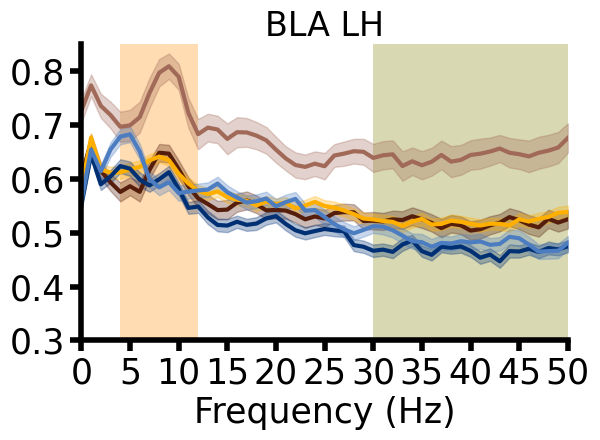

cluster_mean_trial_BLA_MD_coherence_all_frequencies_all_windows
(151, 56)
(65, 56)
(252, 56)
(192, 56)
(98, 56)


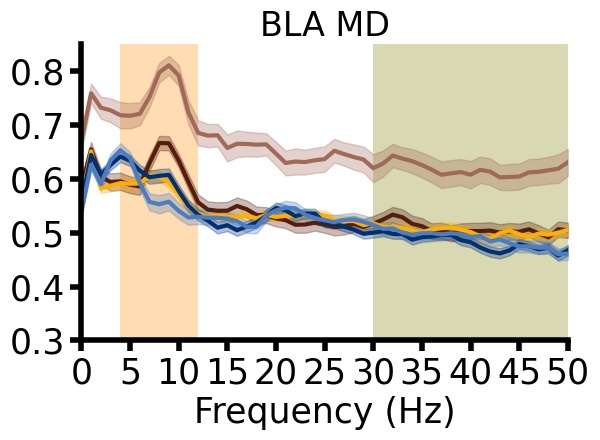

cluster_mean_trial_BLA_mPFC_coherence_all_frequencies_all_windows
(151, 56)
(65, 56)
(252, 56)
(192, 56)
(98, 56)


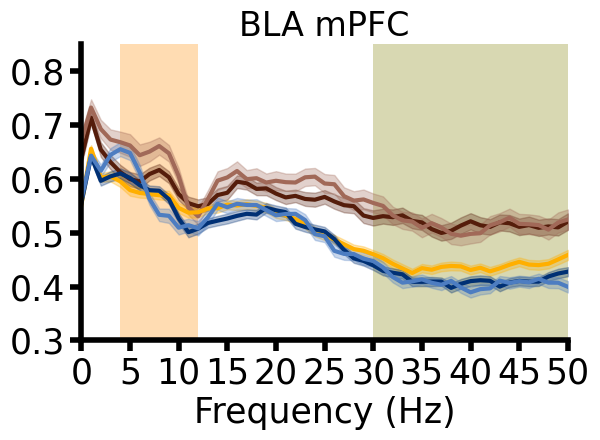

cluster_mean_trial_BLA_vHPC_coherence_all_frequencies_all_windows
(151, 56)
(65, 56)
(252, 56)
(192, 56)
(98, 56)


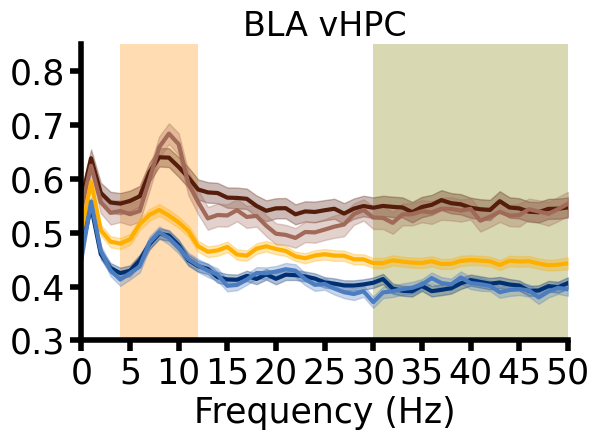

cluster_mean_trial_LH_MD_coherence_all_frequencies_all_windows
(151, 56)
(65, 56)
(252, 56)
(192, 56)
(98, 56)


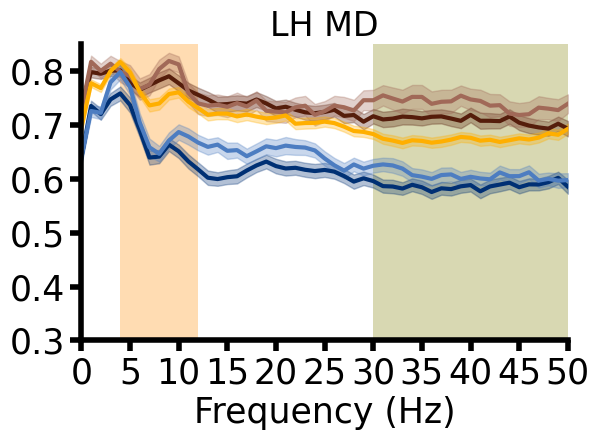

cluster_mean_trial_LH_mPFC_coherence_all_frequencies_all_windows
(151, 56)
(65, 56)
(252, 56)
(192, 56)
(98, 56)


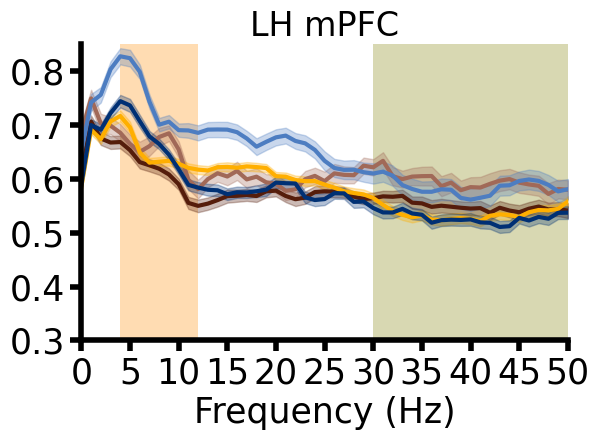

cluster_mean_trial_LH_vHPC_coherence_all_frequencies_all_windows
(151, 56)
(65, 56)
(252, 56)
(192, 56)
(98, 56)


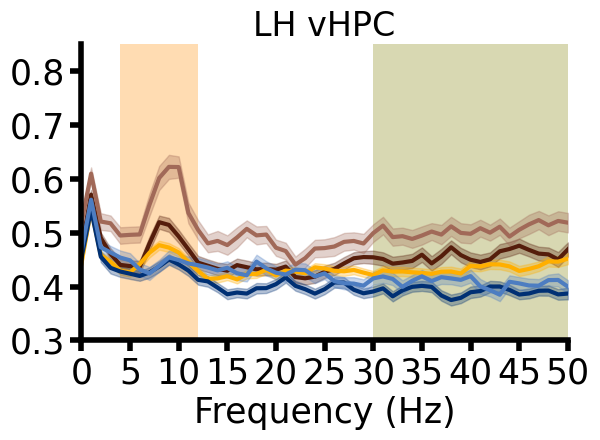

cluster_mean_trial_MD_mPFC_coherence_all_frequencies_all_windows
(151, 56)
(65, 56)
(252, 56)
(192, 56)
(98, 56)


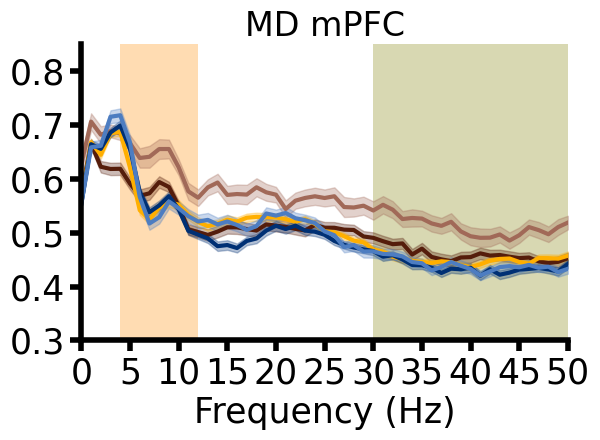

cluster_mean_trial_MD_vHPC_coherence_all_frequencies_all_windows
(151, 56)
(65, 56)
(252, 56)
(192, 56)
(98, 56)


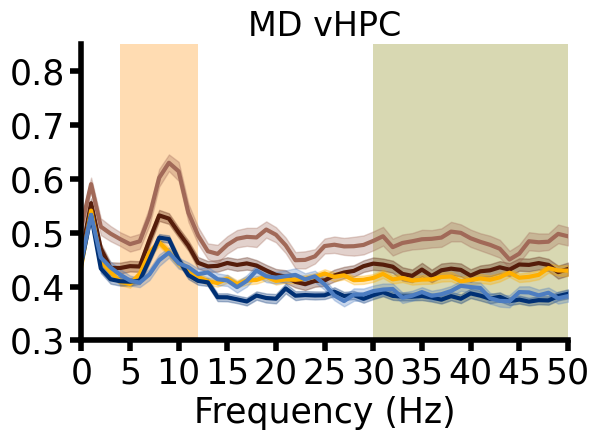

cluster_mean_trial_mPFC_vHPC_coherence_all_frequencies_all_windows
(151, 56)
(65, 56)
(252, 56)
(192, 56)
(98, 56)


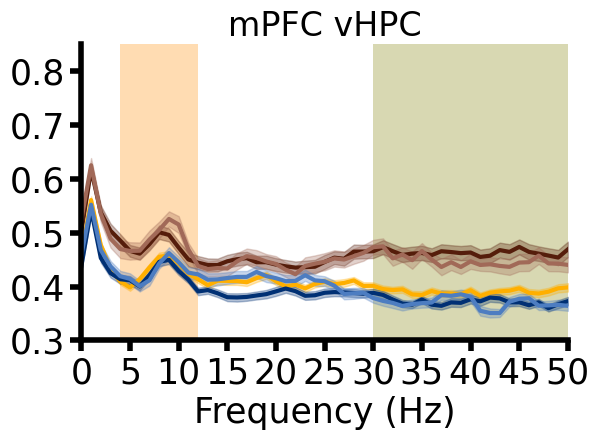

cluster_mean_trial_BLA_LH_granger_all_frequencies_all_windows
(151, 56)
(65, 56)
(252, 56)
(192, 56)
(98, 56)


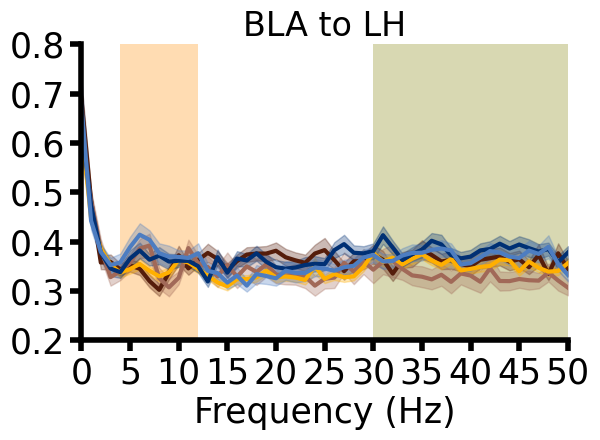

cluster_mean_trial_BLA_MD_granger_all_frequencies_all_windows
(151, 56)
(65, 56)
(252, 56)
(192, 56)
(98, 56)


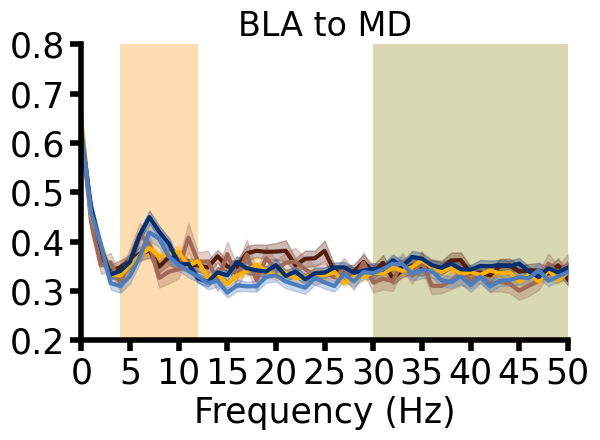

cluster_mean_trial_BLA_mPFC_granger_all_frequencies_all_windows
(151, 56)
(65, 56)
(252, 56)
(192, 56)
(98, 56)


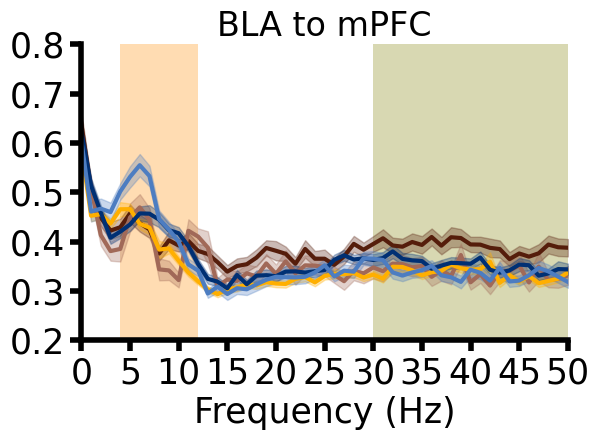

cluster_mean_trial_BLA_vHPC_granger_all_frequencies_all_windows
(151, 56)
(65, 56)
(252, 56)
(192, 56)
(98, 56)


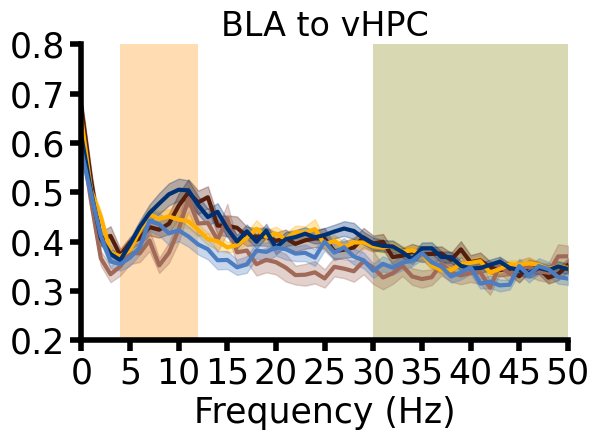

cluster_mean_trial_LH_BLA_granger_all_frequencies_all_windows
(151, 56)
(65, 56)
(252, 56)
(192, 56)
(98, 56)


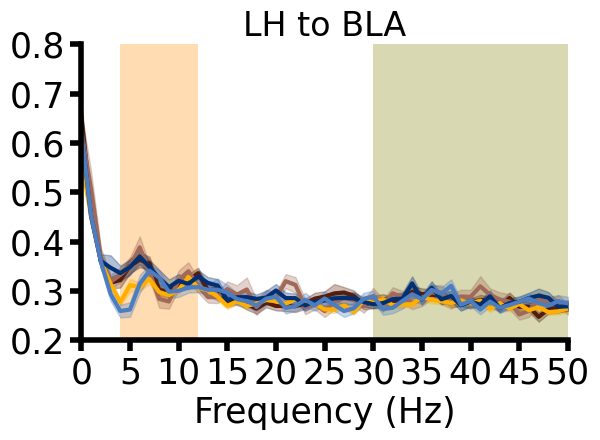

cluster_mean_trial_LH_MD_granger_all_frequencies_all_windows
(151, 56)
(65, 56)
(252, 56)
(192, 56)
(98, 56)


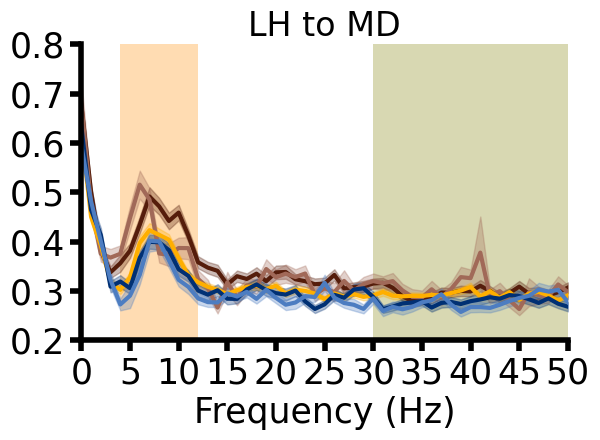

cluster_mean_trial_LH_mPFC_granger_all_frequencies_all_windows
(151, 56)
(65, 56)
(252, 56)
(192, 56)
(98, 56)


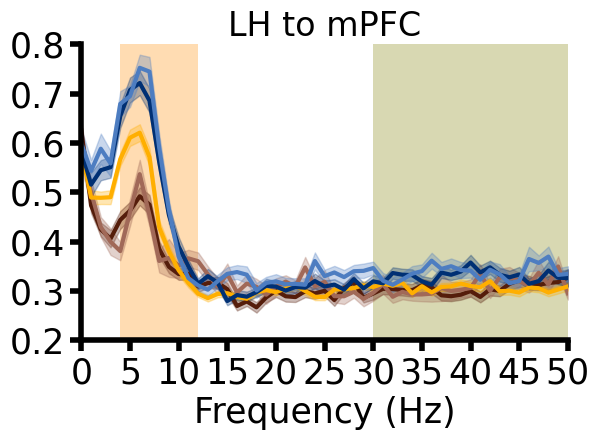

cluster_mean_trial_LH_vHPC_granger_all_frequencies_all_windows
(151, 56)
(65, 56)
(252, 56)
(192, 56)
(98, 56)


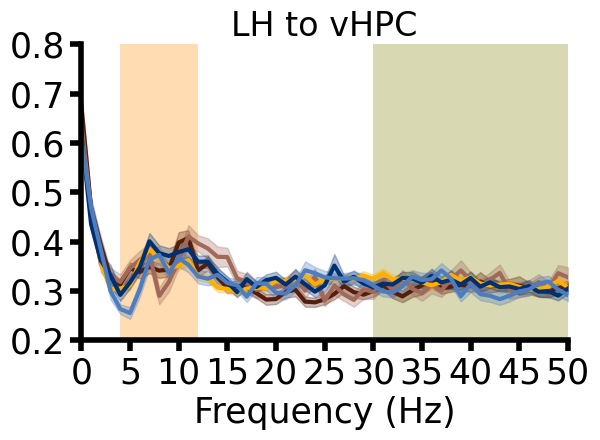

cluster_mean_trial_MD_BLA_granger_all_frequencies_all_windows
(151, 56)
(65, 56)
(252, 56)
(192, 56)
(98, 56)


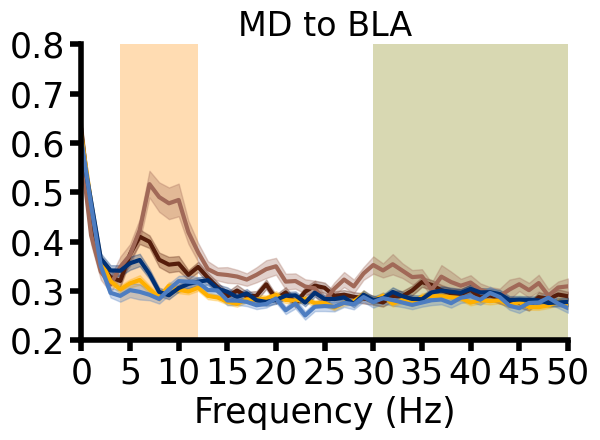

cluster_mean_trial_MD_LH_granger_all_frequencies_all_windows
(151, 56)
(65, 56)
(252, 56)
(192, 56)
(98, 56)


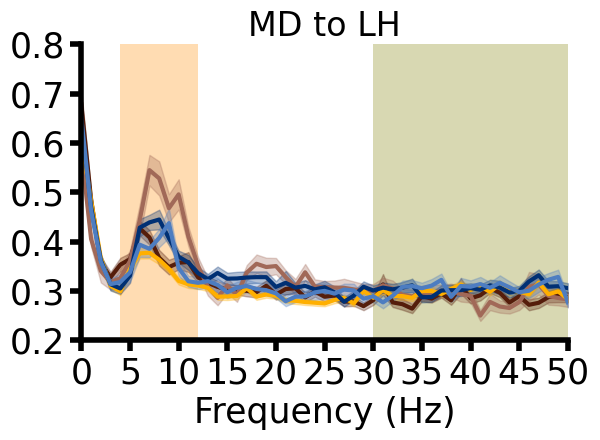

cluster_mean_trial_MD_mPFC_granger_all_frequencies_all_windows
(151, 56)
(65, 56)
(252, 56)
(192, 56)
(98, 56)


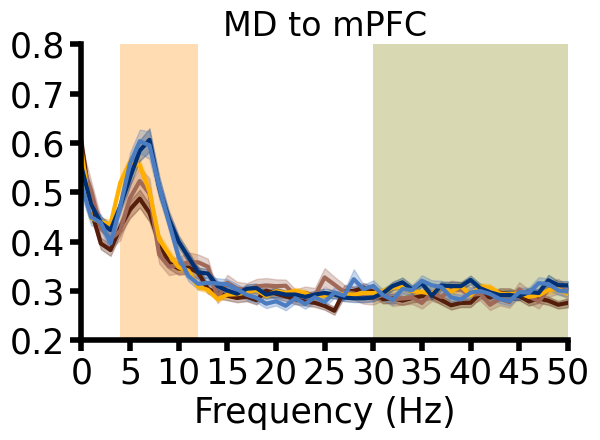

cluster_mean_trial_MD_vHPC_granger_all_frequencies_all_windows
(151, 56)
(65, 56)
(252, 56)
(192, 56)
(98, 56)


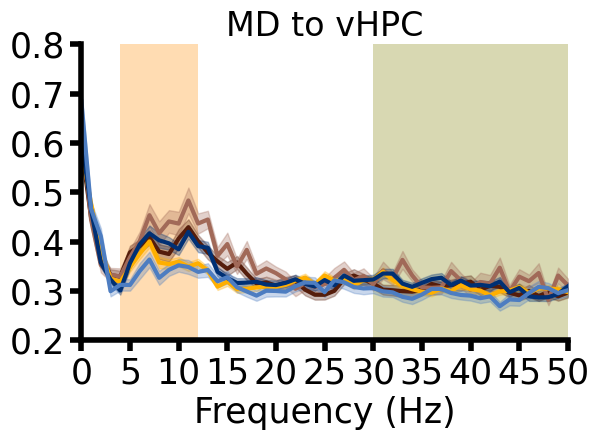

cluster_mean_trial_mPFC_BLA_granger_all_frequencies_all_windows
(151, 56)
(65, 56)
(252, 56)
(192, 56)
(98, 56)


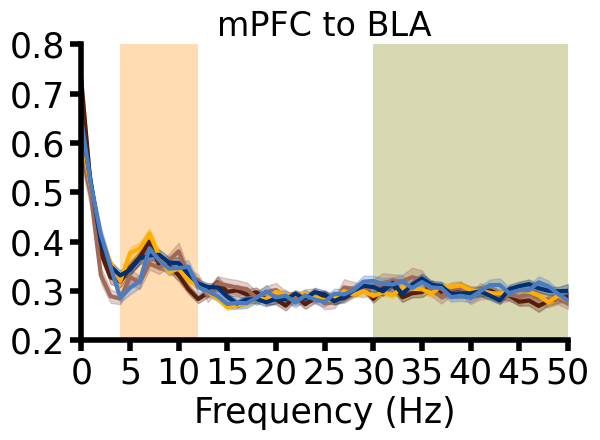

cluster_mean_trial_mPFC_LH_granger_all_frequencies_all_windows
(151, 56)
(65, 56)
(252, 56)
(192, 56)
(98, 56)


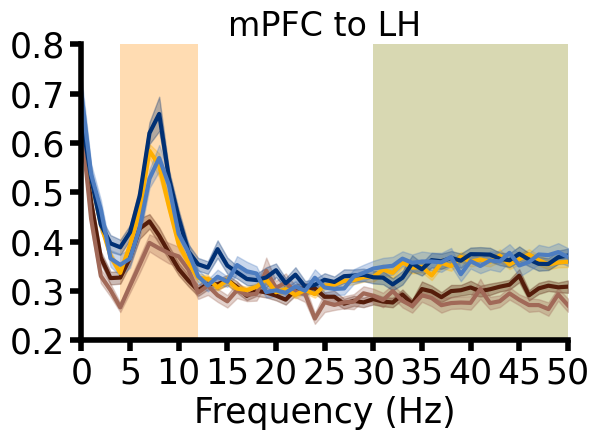

cluster_mean_trial_mPFC_MD_granger_all_frequencies_all_windows
(151, 56)
(65, 56)
(252, 56)
(192, 56)
(98, 56)


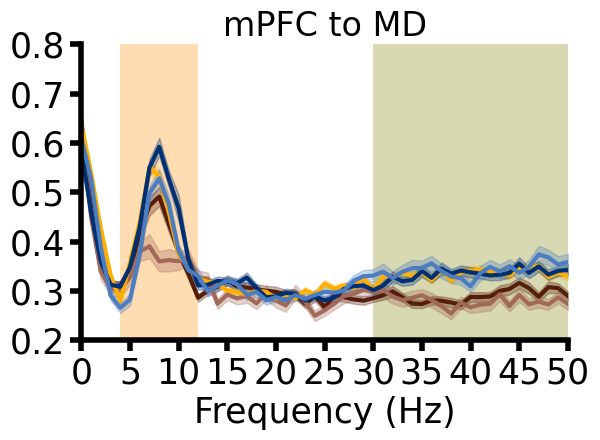

cluster_mean_trial_mPFC_vHPC_granger_all_frequencies_all_windows
(151, 56)
(65, 56)
(252, 56)
(192, 56)
(98, 56)


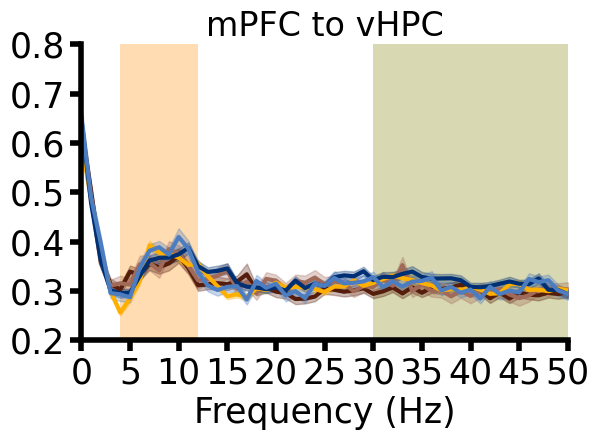

cluster_mean_trial_vHPC_BLA_granger_all_frequencies_all_windows
(151, 56)
(65, 56)
(252, 56)
(192, 56)
(98, 56)


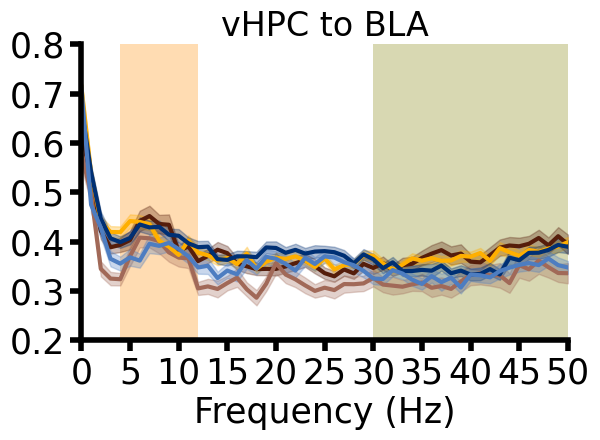

cluster_mean_trial_vHPC_LH_granger_all_frequencies_all_windows
(151, 56)
(65, 56)
(252, 56)
(192, 56)
(98, 56)


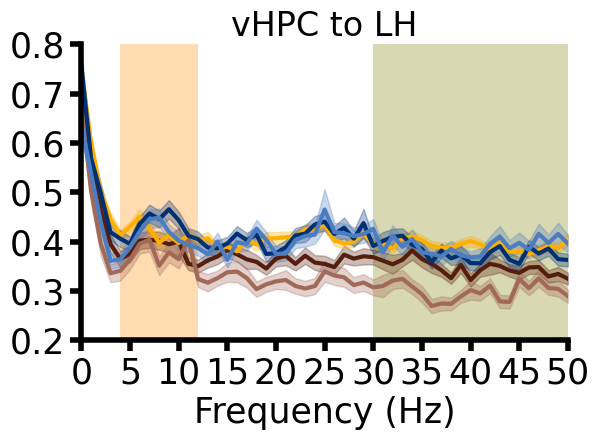

cluster_mean_trial_vHPC_MD_granger_all_frequencies_all_windows
(151, 56)
(65, 56)
(252, 56)
(192, 56)
(98, 56)


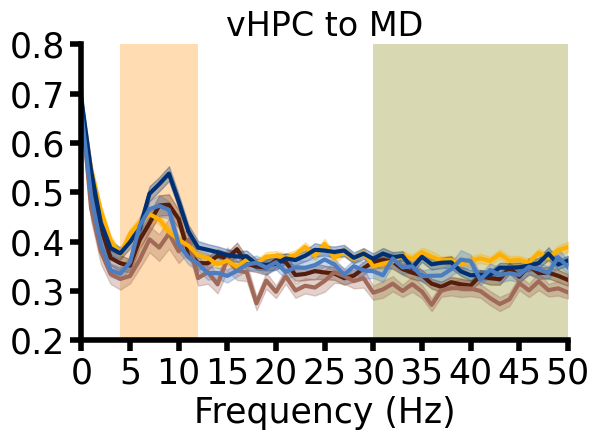

cluster_mean_trial_vHPC_mPFC_granger_all_frequencies_all_windows
(151, 56)
(65, 56)
(252, 56)
(192, 56)
(98, 56)


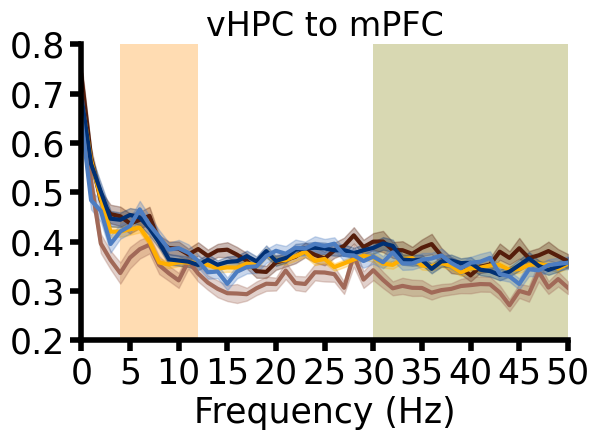

cluster_mean_trial_BLA_power_all_frequencies_all_windows
(151, 56)
(65, 56)
(252, 56)
(192, 56)
(98, 56)


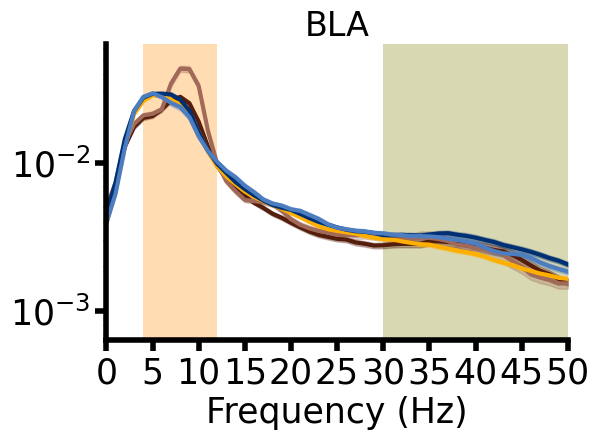

cluster_mean_trial_LH_power_all_frequencies_all_windows
(151, 56)
(65, 56)
(252, 56)
(192, 56)
(98, 56)


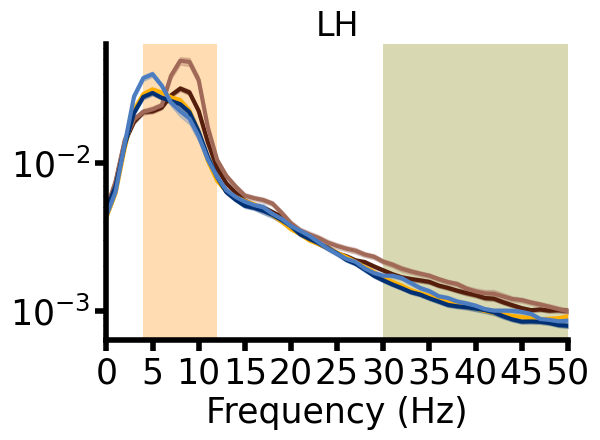

cluster_mean_trial_MD_power_all_frequencies_all_windows
(151, 56)
(65, 56)
(252, 56)
(192, 56)
(98, 56)


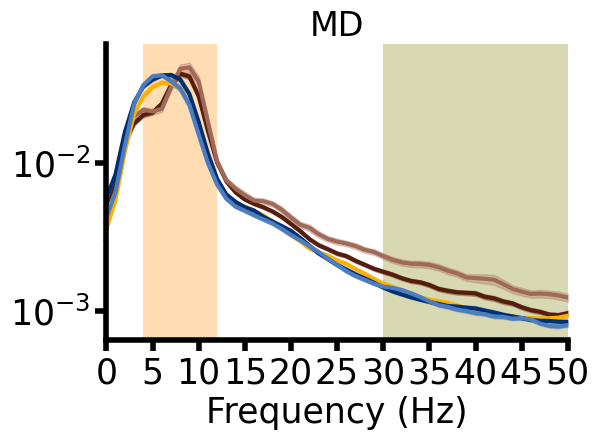

cluster_mean_trial_mPFC_power_all_frequencies_all_windows
(151, 56)
(65, 56)
(252, 56)
(192, 56)
(98, 56)


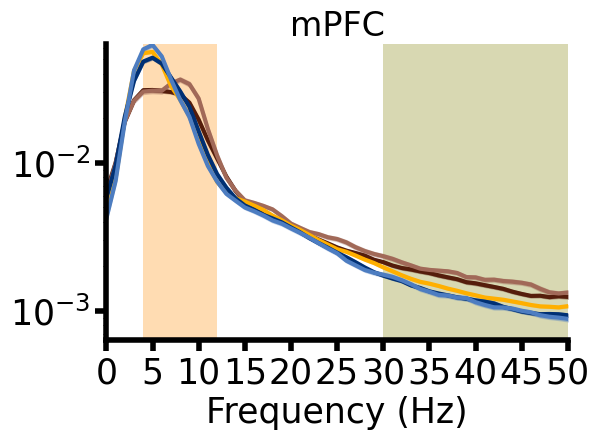

cluster_mean_trial_vHPC_power_all_frequencies_all_windows
(151, 56)
(65, 56)
(252, 56)
(192, 56)
(98, 56)


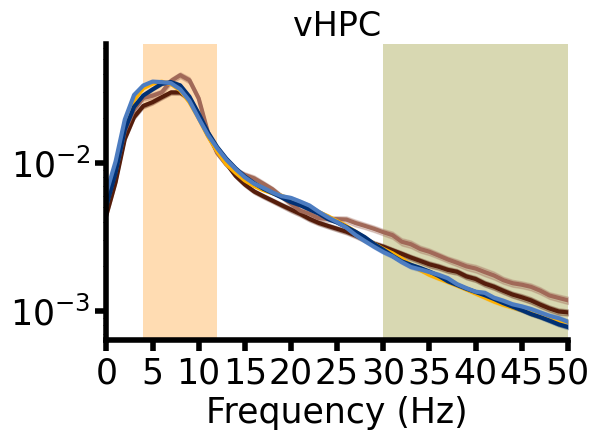

In [142]:
low_freq = 0
high_freq = 51
current_frequencies = range(low_freq, high_freq)

# Iterating through each brain region
for col in cluster_mean_columns:
    if "velocity" in col:
        continue
    if "all_frequencies" not in col:
        continue
    print(col)

    fig, ax = plt.subplots()
    plt.xlim(low_freq, high_freq-1) 
    plt.xticks(np.arange(low_freq, high_freq, 5))

    for band, (min_freq, max_freq) in BAND_TO_FREQ_PLOT.items():
        ax.axvspan(min_freq, max_freq, facecolor=BAND_TO_FREQ_COLOR[band], alpha=0.3, label=band)

    stacked_df = cluster_exploded_TRIALS_AND_SPECTRAL_DF.groupby("trial_and_competitiveness_label").agg({col: stack_arrays})
    # stacked_df = combined_sampled_df.groupby("trial_and_competitiveness_label").agg({col: stack_arrays})
    stacked_df = stacked_df.reset_index()
    stacked_df = stacked_df[~stacked_df["trial_and_competitiveness_label"].str.contains("tie")]

    stacked_df["color"] = stacked_df["trial_and_competitiveness_label"].map(comp_id_to_color)
    
    if "power" in col:
        # plt.ylim(0,0.01)
        # plt.yscale("log")
        plt.ylim((10**-3.2,10**-1.2))
        # plt.set_ylim(auto=True)
        # plt.ylim(0, 0.5)
        ax.set_yscale('log')
        # plt.ylim(0, max_value)
    elif "coherence" in col:
        plt.ylim(0.3, 0.85)
        plt.yticks(np.arange(0.3, 0.85, 0.1)) 
    elif "granger" in col:
        plt.ylim(0.2, 0.8)
        plt.yticks(np.arange(0.2, 0.85, 0.1)) 
    else:
        # pass
        plt.ylim()
    
    # Iterating through each trial type
    for index, row in stacked_df.iterrows():
        # print(row["trial_and_competitiveness_label"])
        print(row[col].shape)
        #### DURING TRIAL ####
        mean_power = np.nanmean(row[col], axis=0)[low_freq: high_freq]
        # mean_power = np.nanmedian(row[col], axis=0)[low_freq: high_freq]

        
        sem_power = np.nanstd(row[col], axis=0) / np.sqrt(row[col].shape[0])
        sem_power = sem_power[low_freq: high_freq]
        # print(sem_power)

        plt.fill_between(current_frequencies, 
        mean_power - sem_power, mean_power + sem_power, \
        alpha=0.3, color=row["color"])

        plt.plot(current_frequencies, mean_power, \
        label="{}".format(row["trial_and_competitiveness_label"]), linewidth=3, color=row["color"])
    
    if "granger" in col:
        title = "{}".format(col.replace("cluster_mean_trial_", "").replace("cluster_mean_trial_and_post_", "").replace("RMS_filtered_", "").replace("all_frequencies_all_windows", "").replace("power", "").replace("granger", "")).replace("coherence", "").replace("_", " ").replace("  ", " ").strip().replace(" ", " to ").strip()
    else:
        title = "{}".format(col.replace("cluster_mean_trial_", "").replace("cluster_mean_trial_and_post_", "").replace("RMS_filtered_", "").replace("all_frequencies_all_windows", "").replace("power", "").replace("granger", "")).replace("coherence", "").replace("_", " ").replace("  ", " ").strip()

    plt.title(title)
    plt.xlabel("Frequency (Hz)", fontsize=25)
    
    if "power" in col:
        # plt.ylabel("Normalized Power (a.u.)")
        output_dir = "./proc/cluster_spectra_plots/power"

    elif "coherence" in col:
        # plt.ylabel("Coherence")
        output_dir = "./proc/cluster_spectra_plots/coherence"

    elif "granger" in col:
        # plt.ylabel("Granger's Causality")
        output_dir = "./proc/cluster_spectra_plots/granger"
    
    os.makedirs(output_dir, exist_ok=True)

    # plt.legend(fontsize=10)
    
    # Hide top and right borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Leave bottom and left spines
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_linewidth(4)
    ax.spines['left'].set_linewidth(4)

    ax.tick_params(length=8, width=4)
    plt.yticks(fontsize=25)
    plt.xticks(fontsize=25)

    plt.tight_layout()    
    plt.savefig(os.path.join(output_dir, "cluster_{}.png".format(col.replace("cluster_mean_trial_and_post_", "").replace("RMS_filtered_", "").replace("all_frequencies_all_windows", "").strip("_").strip())), transparent=True)
    plt.savefig(os.path.join(output_dir, "cluster_{}.svg".format(col.replace("cluster_mean_trial_and_post_", "").replace("RMS_filtered_", "").replace("all_frequencies_all_windows", "").strip("_").strip())), transparent=True)
    plt.show()


In [143]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF.to_pickle("./proc/cluster_exploded_TRIALS_AND_SPECTRAL_DF.pkl")

In [144]:
export_cluster_exploded_TRIALS_AND_SPECTRAL_DF = cluster_exploded_TRIALS_AND_SPECTRAL_DF.copy()

(array([525., 117.,  49.,  29.,  11.,  10.,   9.,   6.,   1.,   1.]),
 array([3.44797708e-02, 3.87529707e+00, 7.71611404e+00, 1.15569315e+01,
        1.53977489e+01, 1.92385654e+01, 2.30793819e+01, 2.69202003e+01,
        3.07610168e+01, 3.46018372e+01, 3.84426537e+01]),
 <BarContainer object of 10 artists>)

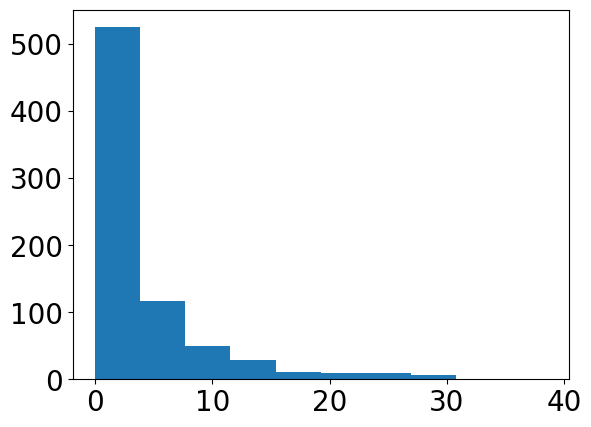

In [145]:
plt.hist(export_cluster_exploded_TRIALS_AND_SPECTRAL_DF["cluster_mean_trial_subject_thorax_velocity"])

In [146]:
export_cluster_exploded_TRIALS_AND_SPECTRAL_DF["velocity_zscore"] = stats.zscore(export_cluster_exploded_TRIALS_AND_SPECTRAL_DF["cluster_mean_trial_subject_thorax_velocity"])

In [147]:
# export_cluster_exploded_TRIALS_AND_SPECTRAL_DF = export_cluster_exploded_TRIALS_AND_SPECTRAL_DF[export_cluster_exploded_TRIALS_AND_SPECTRAL_DF["velocity_zscore"] <= 2]

(array([525., 117.,  49.,  29.,  11.,  10.,   9.,   6.,   1.,   1.]),
 array([3.44797708e-02, 3.87529707e+00, 7.71611404e+00, 1.15569315e+01,
        1.53977489e+01, 1.92385654e+01, 2.30793819e+01, 2.69202003e+01,
        3.07610168e+01, 3.46018372e+01, 3.84426537e+01]),
 <BarContainer object of 10 artists>)

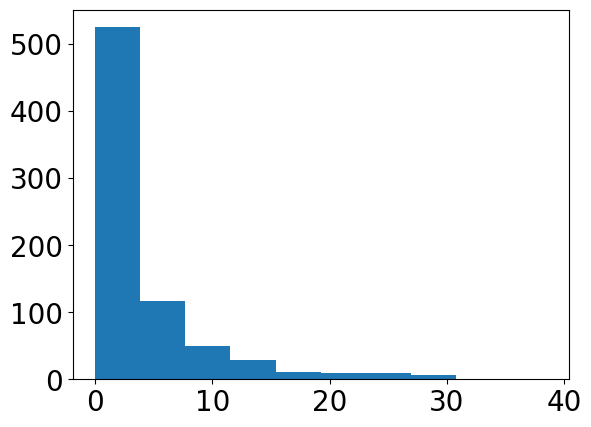

In [148]:
plt.hist(export_cluster_exploded_TRIALS_AND_SPECTRAL_DF["cluster_mean_trial_subject_thorax_velocity"])

In [149]:
export_cluster_exploded_TRIALS_AND_SPECTRAL_DF

tone_start_frame  reward_start  reward_dispensed  tone_stop_frame  \
1                 1272          1352            1372.0             1471   
3                 3268          3348            3368.0             3469   
5                 4466          4546            4566.0             4667   
7                 5465          5545            5565.0             5664   
9                 6962          7042            7062.0             7161   
...                ...           ...               ...              ...   
1136             49514         49594           49614.0            49713   
1139             51909         51989           52009.0            52108   
1140             51909         51989           52009.0            52108   
1141             54104         54184           54204.0            54304   
1142             54104         54184           54204.0            54304   

     condition competition_closeness  get_reward_frame  out_reward_frame  \
1     rewarded              rewarded               NaN               NaN   
3     rewarded              rewarded               NaN               NaN   
5     rewarded              rewarded               NaN               NaN   
7     rewarded              rewarded               NaN               NaN   
9     rewarded              rewarded               NaN               NaN   
...        ...                   ...               ...               ...   
1136       5.3           competitive           49592.0           49703.0   
1139       5.3           competitive           51972.0           52121.0   
1140       5.3           competitive           51972.0           52121.0   
1141       5.3           competitive           54157.0           54286.0   
1142       5.3           competitive           54157.0           54286.0   

      experiment                                     video_name  ...  \
1     alone_comp  20240320_142408_alone_comp_subj_3-1_and_3-3.1  ...   
3     alone_comp  20240320_142408_alone_comp_subj_3-1_and_3-3.1  ...   
5     alone_comp  20240320_142408_alone_comp_subj_3-1_and_3-3.1  ...   
7     alone_comp  20240320_142408_alone_comp_subj_3-1_and_3-3.1  ...   
9     alone_comp  20240320_142408_alone_comp_subj_3-1_and_3-3.1  ...   
...          ...                                            ...  ...   
1136   long_comp   20240321_114851_long_comp_subj_5-2_and_5-3.1  ...   
1139   long_comp   20240321_114851_long_comp_subj_5-2_and_5-3.1  ...   
1140   long_comp   20240321_114851_long_comp_subj_5-2_and_5-3.1  ...   
1141   long_comp   20240321_114851_long_comp_subj_5-2_and_5-3.1  ...   
1142   long_comp   20240321_114851_long_comp_subj_5-2_and_5-3.1  ...   

      cluster_mean_trial_MD_power_gamma  cluster_mean_trial_MD_power_theta  \
1                              0.000861                           0.011037   
3                              0.000872                           0.009743   
5                              0.001129                           0.028845   
7                              0.000949                           0.007470   
9                              0.001055                           0.011852   
...                                 ...                                ...   
1136                           0.000630                           0.029646   
1139                           0.000882                           0.039440   
1140                           0.000579                           0.028071   
1141                           0.000903                           0.040261   
1142                           0.000697                           0.039654   

     cluster_mean_trial_mPFC_power_all_frequencies_all_windows  \
1     [0.0025098089, 0.004177024, 0.0070650093, 0.01...          
3     [0.0018210271, 0.0033454504, 0.009506376, 0.02...          
5     [0.0053991014, 0.008289773, 0.015829232, 0.022...          
7     [0.0013570499, 0.0022594756, 0.006442896, 0.02...          
9     [0.0019887087, 0.0041727247, 0.010153458, 0.01...     

In [150]:
for col in export_cluster_exploded_TRIALS_AND_SPECTRAL_DF.columns:
    print(col)

tone_start_frame
reward_start
reward_dispensed
tone_stop_frame
condition
competition_closeness
get_reward_frame
out_reward_frame
experiment
video_name
tone_start_timestamp
tone_stop_timestamp
cohort
session_dir
tone_frames
box_1_port_entry_frames
box_2_port_entry_frames
notes
session_path
recording
current_subject
subject
all_subjects
first_timestamp
last_timestamp
video_timestamps
tone_timestamps
box_1_port_entry_timestamps
box_2_port_entry_timestamps
power_calculation_frequencies
coherence_calculation_frequencies
granger_calculation_frequencies
tone_start_frame_remove
agent_tail_base
agent_to_reward_port_angle
subject_tail_base
subject_to_reward_port_angle
to_reward_port_angle_diff
to_reward_port_angle_sum
within_trial_index
agent
10s_after_tone_frame
10s_before_tone_frame
all_subjects_remove
body_parts
box_bottom_left
box_bottom_right
box_number
box_top_left
box_top_right
color
comp_id
competition_closeness_remove
condition 
experiment_remove
first_timestamp_remove
get_reward_frame_

In [151]:
export_cluster_exploded_TRIALS_AND_SPECTRAL_DF = export_cluster_exploded_TRIALS_AND_SPECTRAL_DF.reset_index().rename({"index": "index_num"})

In [152]:
# combined_sampled_df = 
combined_sampled_df = combined_sampled_df[[col for col in export_cluster_exploded_TRIALS_AND_SPECTRAL_DF if ("cluster_mean_trial" in col and "all_frequencies" not in col) or (col in ["trial_and_competitiveness_label", "current_subject", "index_num"])]]

In [153]:
export_cluster_exploded_TRIALS_AND_SPECTRAL_DF = export_cluster_exploded_TRIALS_AND_SPECTRAL_DF[[col for col in export_cluster_exploded_TRIALS_AND_SPECTRAL_DF if ("cluster_mean_trial" in col and "all_frequencies" not in col) or (col in ["trial_and_competitiveness_label", "current_subject", "index_num"])]]

In [154]:
export_cluster_exploded_TRIALS_AND_SPECTRAL_DF.to_csv("./proc/export_cluster_exploded_TRIALS_AND_SPECTRAL_DF.csv")
export_cluster_exploded_TRIALS_AND_SPECTRAL_DF.to_csv("../../export_cluster_exploded_TRIALS_AND_SPECTRAL_DF.csv")

In [155]:
export_cluster_exploded_TRIALS_AND_SPECTRAL_DF["current_subject"].unique()

array(['3.3', '3.1', '4.3', '4.2', '3.4', '5.2', '5.3'], dtype=object)

In [156]:
export_cluster_exploded_TRIALS_AND_SPECTRAL_DF.shape

(758, 76)

In [157]:
export_cluster_exploded_TRIALS_AND_SPECTRAL_DF[["trial_and_competitiveness_label", "cluster_mean_trial_subject_thorax_velocity"]].groupby(["trial_and_competitiveness_label"]).mean()

cluster_mean_trial_subject_thorax_velocity
trial_and_competitiveness_label                                            
lose_competitive                                                   5.428585
lose_no_comp                                                       7.588606
rewarded                                                           2.368193
win_competitive                                                    4.525214
win_no_comp                                                        2.623162

## Plotting

In [158]:
export_cluster_exploded_TRIALS_AND_SPECTRAL_DF["trial_and_competitiveness_label"].unique()

array(['rewarded', 'win_no_comp', 'lose_no_comp', 'win_competitive',
       'lose_competitive'], dtype=object)

In [159]:
export_cluster_exploded_TRIALS_AND_SPECTRAL_DF["bar_ticks"] = export_cluster_exploded_TRIALS_AND_SPECTRAL_DF["trial_and_competitiveness_label"].map(label_to_ticks)
combined_sampled_df["bar_ticks"] = combined_sampled_df["trial_and_competitiveness_label"].map(label_to_ticks)
combined_sampled_df = combined_sampled_df.reset_index(drop=True)

- Plotting with the predicted values

In [160]:
all_predicted_df = []
for file_path in glob.glob("../../output_lmer_velocity/predicted/*"):
    current_df = pd.read_csv(file_path, index_col=0)
    current_df = current_df.rename(columns={"predicted_value": "predicted_" + current_df["col_name"].iloc[0]})
    current_df = current_df.rename(columns={"original_value": "original_" + current_df["col_name"].iloc[0]})
    current_df = current_df.drop(columns=["col_name"], errors="ignore")
    all_predicted_df.append(current_df)


In [161]:
current_df

subject_id  original_cluster_mean_trial_vHPC_power_theta  \
1           3.3                                      0.018229   
2           3.3                                      0.016937   
3           3.3                                      0.027546   
4           3.3                                      0.013017   
5           3.3                                      0.013900   
..          ...                                           ...   
750         5.3                                      0.024333   
751         5.2                                      0.013437   
752         5.3                                      0.035511   
753         5.2                                      0.009998   
754         5.3                                      0.032559   

     predicted_cluster_mean_trial_vHPC_power_theta  \
1                                         0.026583   
2                                         0.026761   
3                                         0.026566   
4                                         0.026524   
5                                         0.026545   
..                                             ...   
750                                       0.026606   
751                                       0.023398   
752                                       0.026591   
753                                       0.023506   
754                                       0.026861   

    trial_and_competitiveness_label  \
1                          rewarded   
2                          rewarded   
3                          rewarded   
4                          rewarded   
5                          rewarded   
..                              ...   
750                 win_competitive   
751                lose_competitive   
752                 win_competitive   
753                lose_competitive   
754                 win_competitive   

     cluster_mean_trial_subject_thorax_velocity  index_num  
1                                      1.926471          0  
2                                      6.647217          1  
3                                      1.471431          2  
4                                      0.355456          3  
5                                      0.897140          4  
..                                          ...        ...  
750                                    0.965120        753  
751                                    0.946990        754  
752                                    0.589087        755  
753                                    3.813045        756  
754                                    7.756946        757  

[754 rows x 6 columns]

In [162]:
joined_df = all_predicted_df[0]
for current_df in all_predicted_df[1:]:
    joined_df = pd.merge(joined_df, current_df, on="index_num", suffixes=("", "_drop"))
    joined_df = joined_df.drop(columns=[col for col in joined_df if "_drop" in col])

In [163]:
joined_df

subject_id  original_cluster_mean_trial_BLA.to.LH_granger_gamma  \
0           3.3                                           0.230326     
1           3.3                                           0.286650     
2           3.3                                           0.282608     
3           3.3                                           0.322555     
4           3.3                                           0.281289     
..          ...                                                ...     
718         5.2                                           0.392838     
719         5.2                                           0.392234     
720         5.3                                           0.366391     
721         5.2                                           0.275074     
722         5.3                                           0.290592     

     predicted_cluster_mean_trial_BLA.to.LH_granger_gamma  \
0                                             0.356243      
1                                             0.356201      
2                                             0.356247      
3                                             0.356257      
4                                             0.356252      
..                                                 ...      
718                                           0.361677      
719                                           0.361672      
720                                           0.383513      
721                                           0.361647      
722                                           0.383449      

    trial_and_competitiveness_label  \
0                          rewarded   
1                          rewarded   
2                          rewarded   
3                          rewarded   
4                          rewarded   
..                              ...   
718                lose_competitive   
719                lose_competitive   
720                 win_competitive   
721                lose_competitive   
722                 win_competitive   

     cluster_mean_trial_subject_thorax_velocity  index_num  \
0                                      1.926471          0   
1                                      6.647217          1   
2                                      1.471431          2   
3                                      0.355456          3   
4                                      0.897140          4   
..                                          ...        ...   
718                                    0.427833        752   
719                                    0.946990        754   
720                                    0.589087        755   
721                                    3.813045        756   
722                                    7.756946        757   

     original_cluster_mean_trial_BLA.to.LH_granger_theta  \
0                                             0.324221     
1                                             0.353703     
2                                             0.255349     
3                                             0.299213     
4                                             0.239289     
..                                                 ...     
718                                           0.181533     
719                                           0.341963     
720                                           0.297457     
721                                           0.307052     
722                                           0.339362     

     predicted_cluster_mean_trial_BLA.to.LH_granger_theta  \
0                                             0.345817      
1                                             0.353088      
2                                             0.345116      
3                                             0.343397      
4                                             0.344231      
..                                                 ...      
718                                          

- Plotting the emmeans

In [164]:
all_emmeans_df = []
for file_path in glob.glob("../../output_lmer_velocity/emmeans_csv/*with_CI*"):
    current_df = pd.read_csv(file_path, index_col=0)
    # current_df = current_df.rename(columns={"predicted_value": "predicted_" + current_df["col_name"].iloc[0]})
    # current_df = current_df.rename(columns={"original_value": "original_" + current_df["col_name"].iloc[0]})
    current_df = current_df.drop(columns=["col_name"], errors="ignore")
    current_df = current_df.dropna(subset=["emmean"])
    all_emmeans_df.append(current_df)
combined_emmeans_df = pd.concat(all_emmeans_df)


In [165]:
combined_emmeans_df["color"] = combined_emmeans_df["trial_and_competitiveness_label"].map(comp_id_to_color)

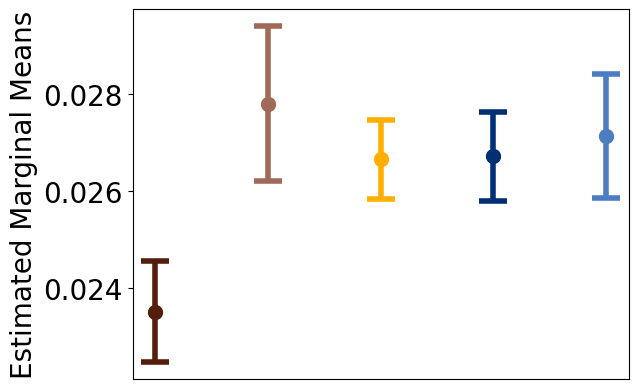

In [166]:
current_df = combined_emmeans_df[combined_emmeans_df["spectra_metric"] == "cluster_mean_trial_vHPC_power_theta"]
for index, row in current_df.sort_values(by=["trial_and_competitiveness_label"]).iterrows():
    plt.errorbar(row["trial_and_competitiveness_label"], row["emmean"], yerr=row["upper.CL"] - row["emmean"], fmt='o', color=row["color"],elinewidth=4, capsize=10, markeredgewidth=4)
    plt.scatter(row["trial_and_competitiveness_label"], row["emmean"], s = 100, marker = "o", color = row["color"])
    # plt.barh(row["trial_and_competitiveness_label"], row["emmean"], yerr=row["upper.CL"] - row["emmean"], fmt='o', color=row["color"])

    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    
    plt.ylabel('Estimated Marginal Means', size=20)

    # means.index, means, yerr=sems, fmt='o', color='black')


In [167]:

export_cluster_exploded_TRIALS_AND_SPECTRAL_DF["bar_ticks"]

0      alone\nrewarded
1      alone\nrewarded
2      alone\nrewarded
3      alone\nrewarded
4      alone\nrewarded
            ...       
753          win\ncomp
754         lose\ncomp
755          win\ncomp
756         lose\ncomp
757          win\ncomp
Name: bar_ticks, Length: 758, dtype: object

In [168]:
combined_sampled_df

current_subject trial_and_competitiveness_label  \
0               3.1                        rewarded   
1               3.1                        rewarded   
2               3.1                        rewarded   
3               3.1                        rewarded   
4               3.1                        rewarded   
..              ...                             ...   
226             3.4                lose_competitive   
227             4.2                lose_competitive   
228             4.3                lose_competitive   
229             5.2                lose_competitive   
230             5.3                lose_competitive   

     cluster_mean_trial_subject_thorax_velocity  \
0                                      0.636275   
1                                      0.765179   
2                                      7.975111   
3                                      1.283374   
4                                      0.840628   
..                                          ...   
226                                    8.347641   
227                                    2.051313   
228                                    3.975572   
229                                    0.946990   
230                                    3.742544   

     cluster_mean_trial_BLA_LH_coherence_gamma  \
0                                     0.463456   
1                                     0.419544   
2                                     0.373365   
3                                     0.441960   
4                                     0.393662   
..                                         ...   
226                                   0.464783   
227                                   0.475851   
228                                   0.491493   
229                                   0.426038   
230                                   0.329544   

     cluster_mean_trial_BLA_LH_coherence_theta  \
0                                     0.542759   
1                                     0.477585   
2                                     0.497652   
3                                     0.620867   
4                                     0.378706   
..                                         ...   
226                                   0.559125   
227                                   0.492528   
228                                   0.599133   
229                                   0.493915   
230                                   0.527894   

     cluster_mean_trial_BLA_MD_coherence_gamma  \
0                                     0.386747   
1                                     0.404670   
2                                     0.392866   
3                                     0.382539   
4                                     0.347618   
..                                         ...   
226                                   0.571377   
227                                   0.465646   
228                                   0.421631   
229                                   0.394870   
230                                   0.513340   

     cluster_mean_trial_BLA_MD_coherence_theta  \
0                                     0.482433   
1                                     0.512496   
2                                     0.514437   
3                                     0.550048   
4                                     0.425492   
..                                         ...   
226                                   0.508159   
227                                   0.701073   
228                                   0.490803   
229                                   0.488026   
230                                   0.719853   

     cluster_mean_trial_BLA_mPFC_coherence_gamma  \
0                                       0.333077   
1                                       0.379389   
2                                       0.335841   
3                                       0.363365   
4                                       0.353341   
..            

In [169]:
combined_sampled_df = combined_sampled_df.reset_index(drop=True)

In [170]:
combined_sampled_df = combined_sampled_df.sort_values(["trial_and_competitiveness_label"])

cluster_mean_trial_BLA_LH_coherence_gamma


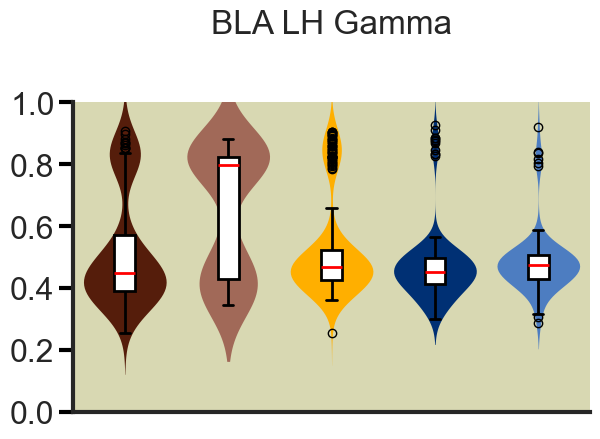

cluster_mean_trial_BLA_LH_coherence_theta


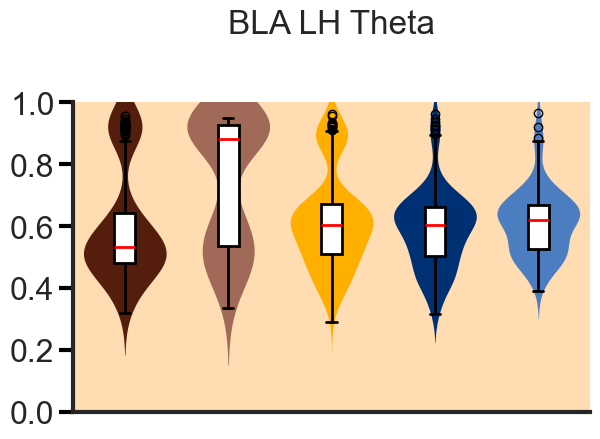

cluster_mean_trial_BLA_MD_coherence_gamma


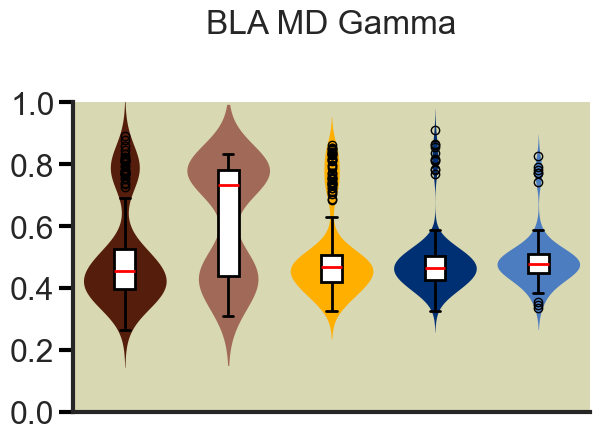

cluster_mean_trial_BLA_MD_coherence_theta


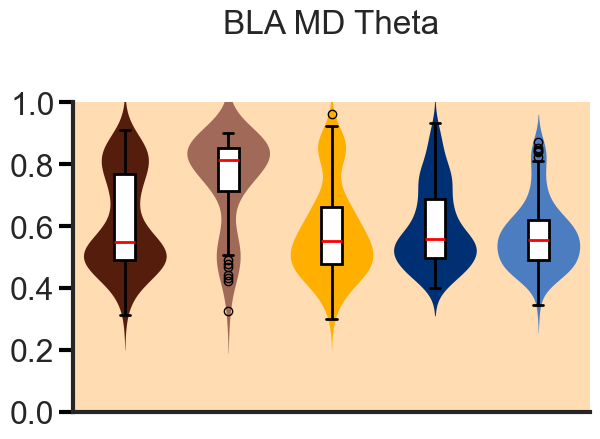

cluster_mean_trial_BLA_mPFC_coherence_gamma


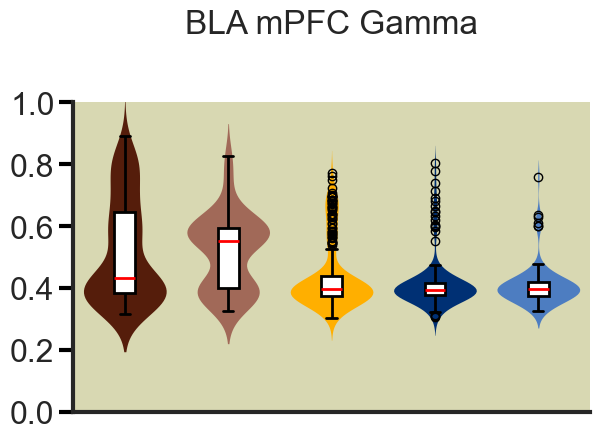

cluster_mean_trial_BLA_mPFC_coherence_theta


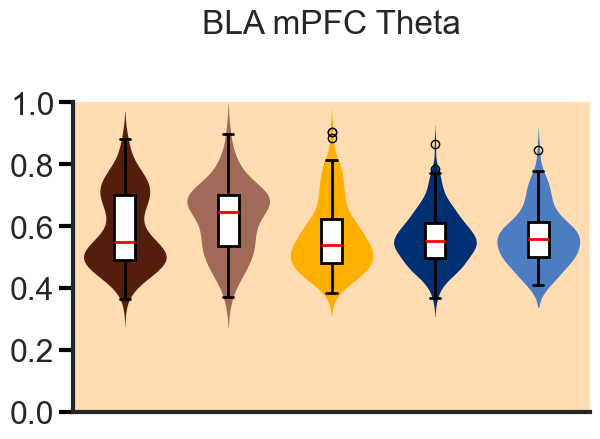

cluster_mean_trial_BLA_vHPC_coherence_gamma


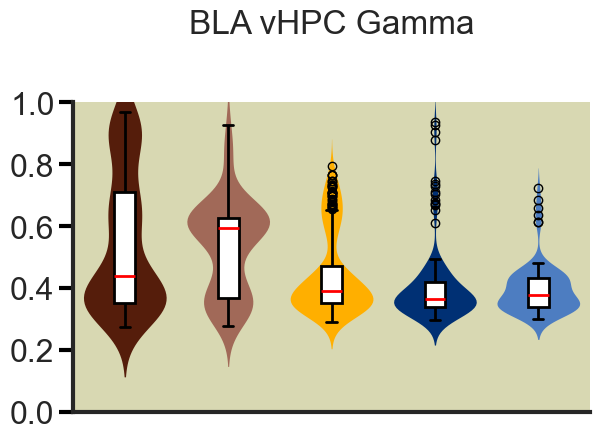

cluster_mean_trial_BLA_vHPC_coherence_theta


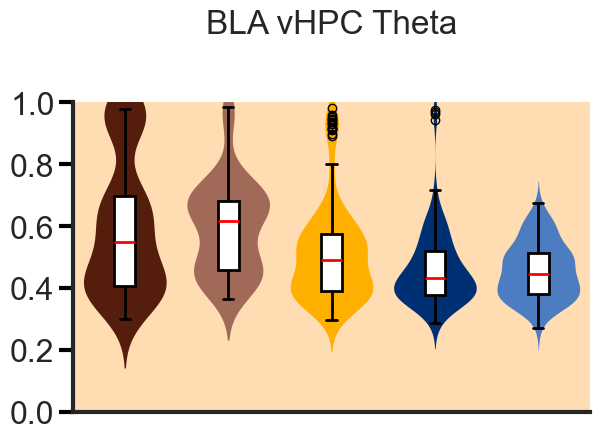

cluster_mean_trial_LH_MD_coherence_gamma


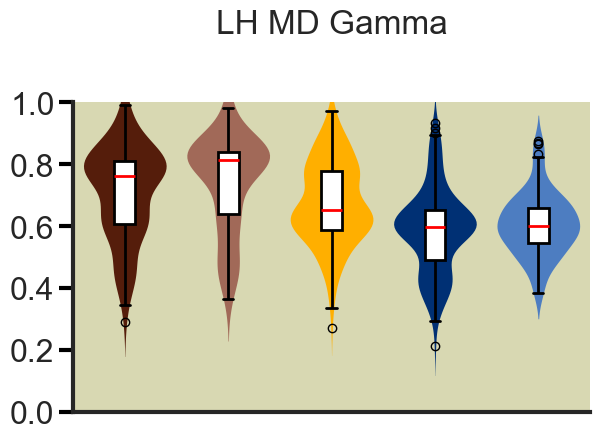

cluster_mean_trial_LH_MD_coherence_theta


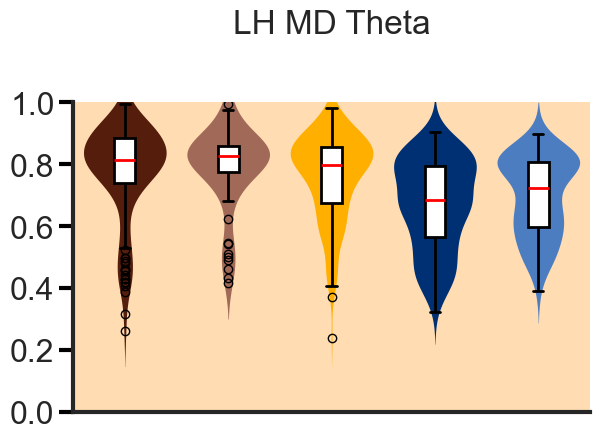

cluster_mean_trial_LH_mPFC_coherence_gamma


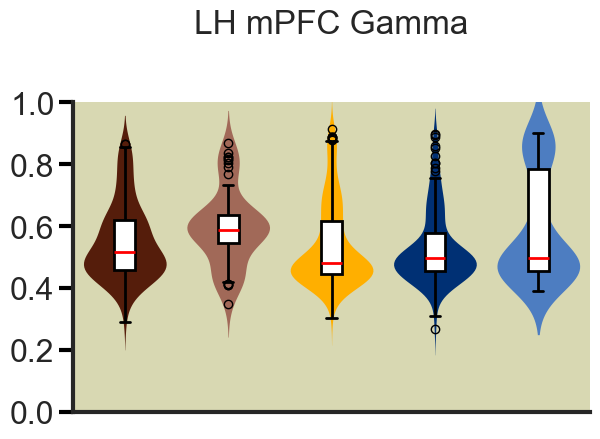

cluster_mean_trial_LH_mPFC_coherence_theta


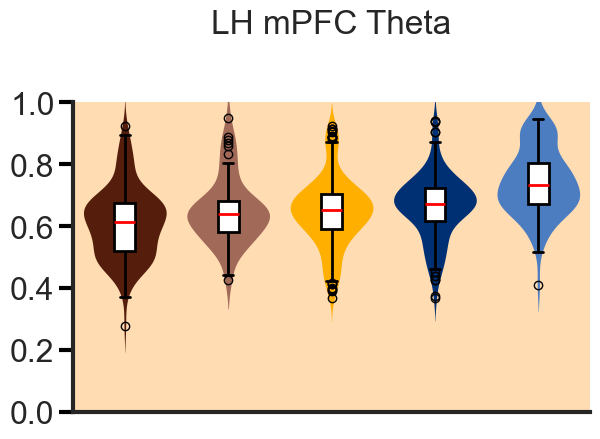

cluster_mean_trial_LH_vHPC_coherence_gamma


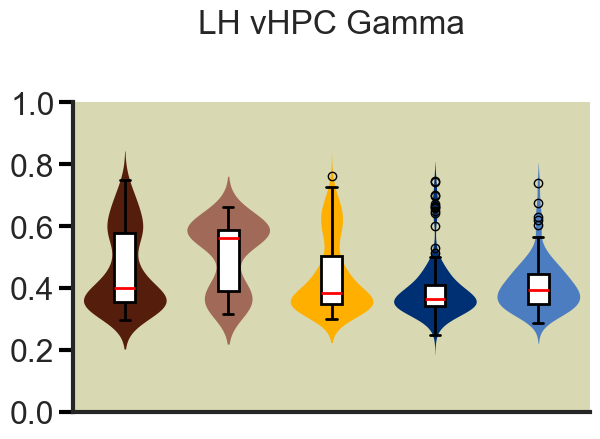

cluster_mean_trial_LH_vHPC_coherence_theta


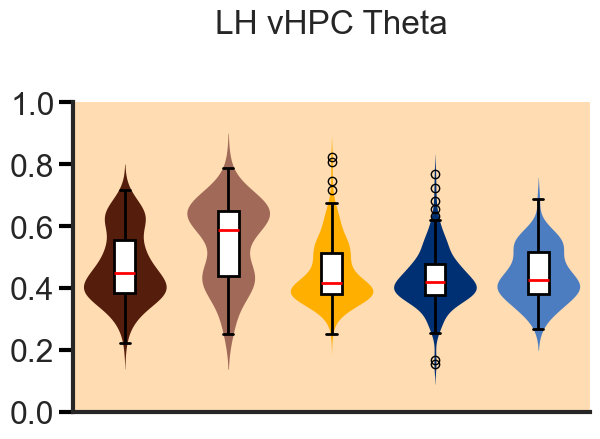

cluster_mean_trial_MD_mPFC_coherence_gamma


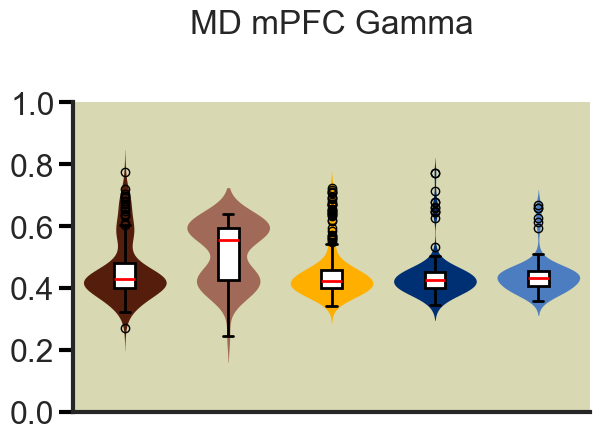

cluster_mean_trial_MD_mPFC_coherence_theta


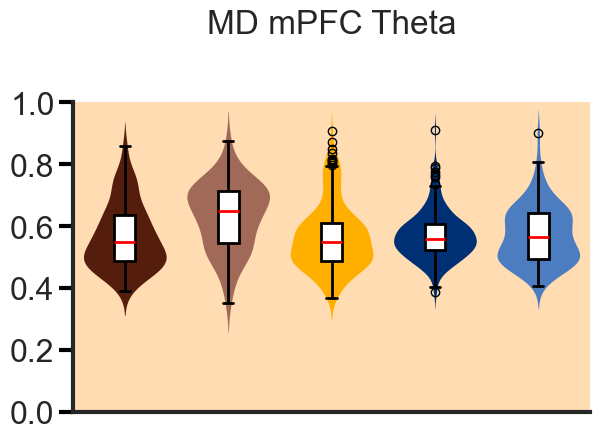

cluster_mean_trial_MD_vHPC_coherence_gamma


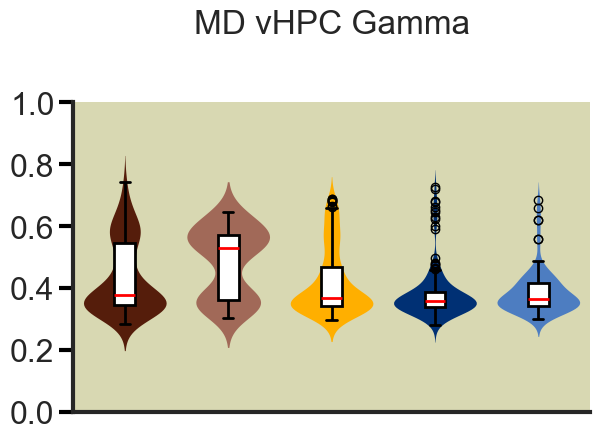

cluster_mean_trial_MD_vHPC_coherence_theta


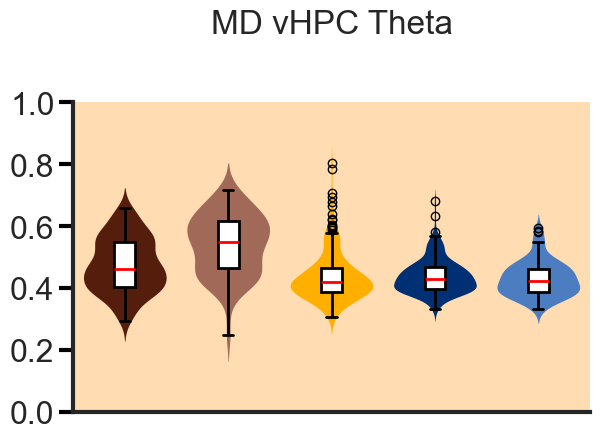

cluster_mean_trial_mPFC_vHPC_coherence_gamma


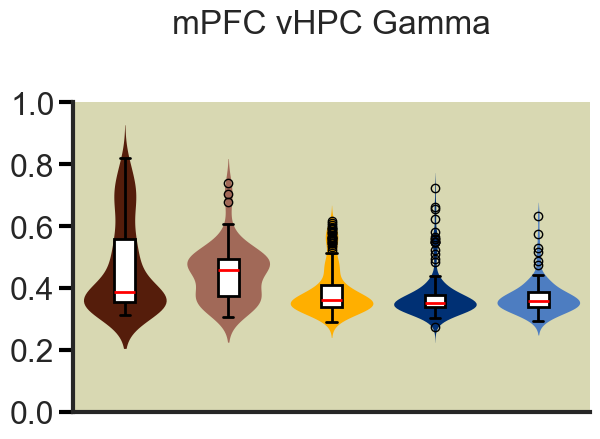

cluster_mean_trial_mPFC_vHPC_coherence_theta


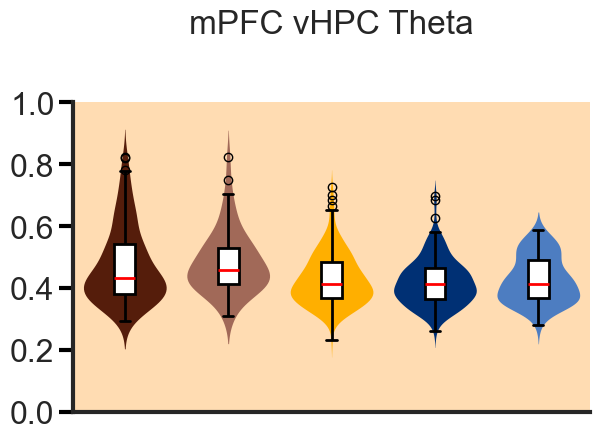

cluster_mean_trial_BLA-to-LH_granger_gamma


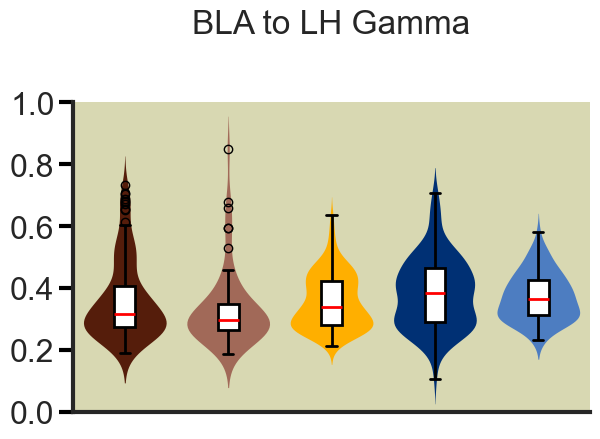

cluster_mean_trial_BLA-to-LH_granger_theta


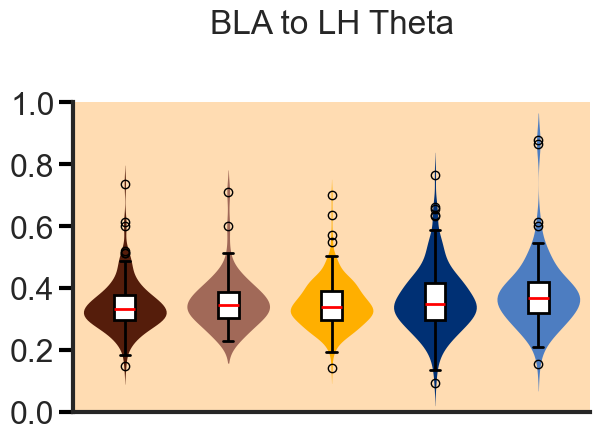

cluster_mean_trial_BLA-to-MD_granger_gamma


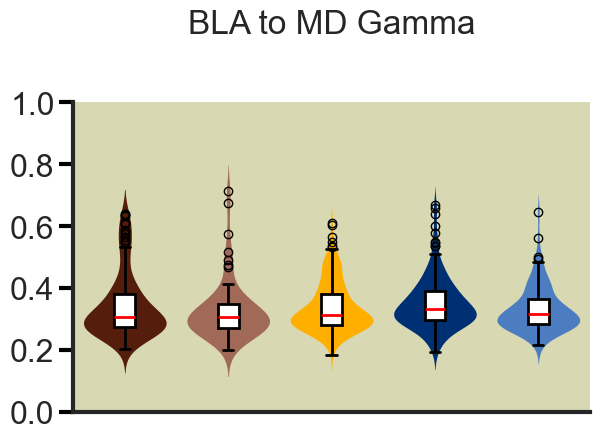

cluster_mean_trial_BLA-to-MD_granger_theta


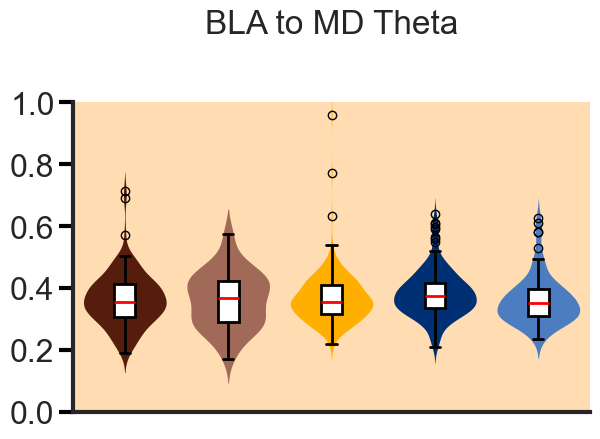

cluster_mean_trial_BLA-to-mPFC_granger_gamma


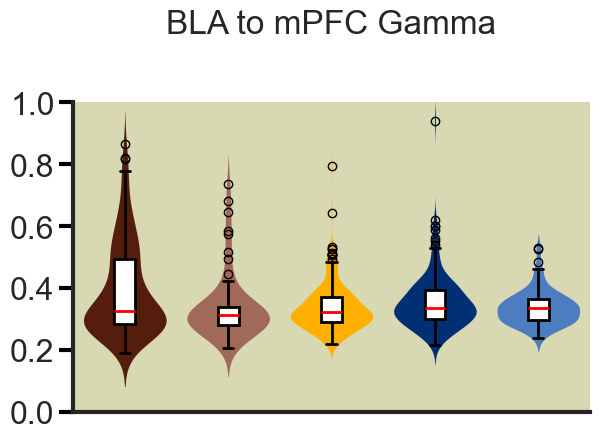

cluster_mean_trial_BLA-to-mPFC_granger_theta


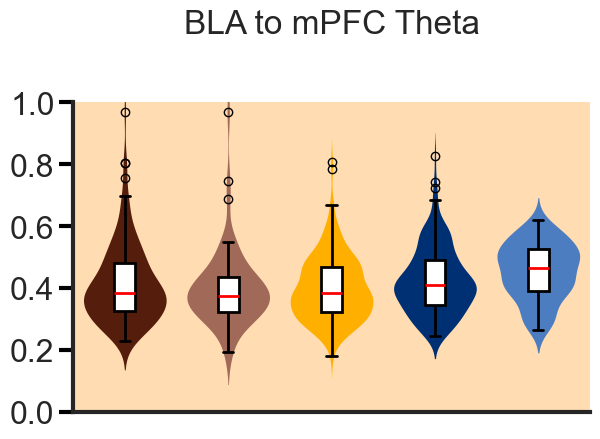

cluster_mean_trial_BLA-to-vHPC_granger_gamma


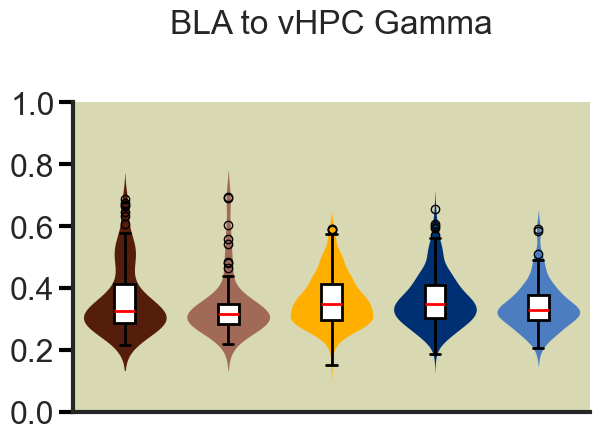

cluster_mean_trial_BLA-to-vHPC_granger_theta


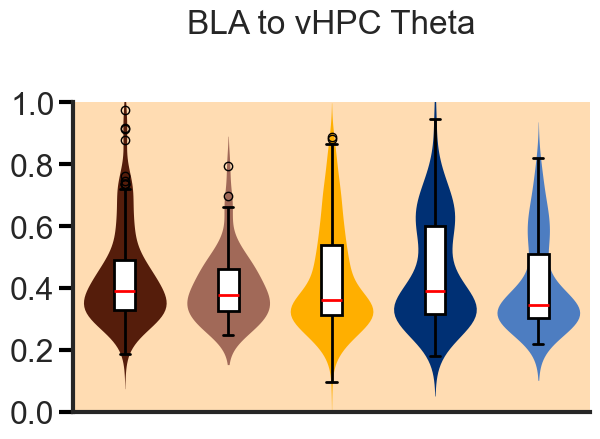

cluster_mean_trial_LH-to-BLA_granger_gamma


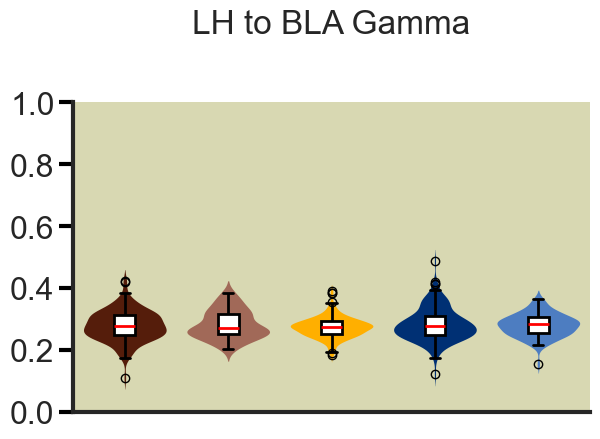

cluster_mean_trial_LH-to-BLA_granger_theta


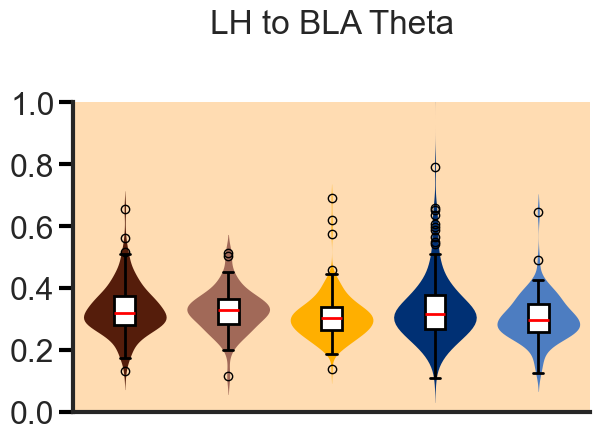

cluster_mean_trial_LH-to-MD_granger_gamma


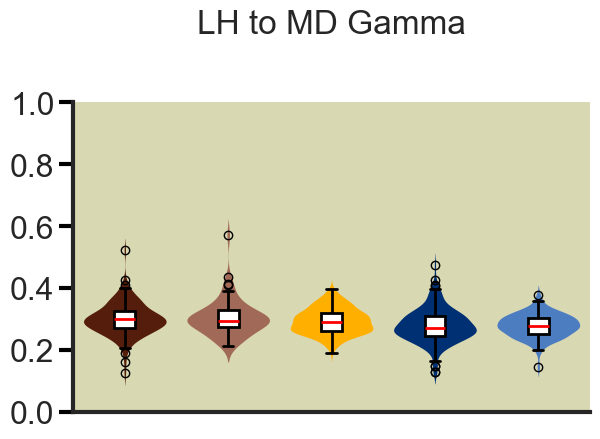

cluster_mean_trial_LH-to-MD_granger_theta


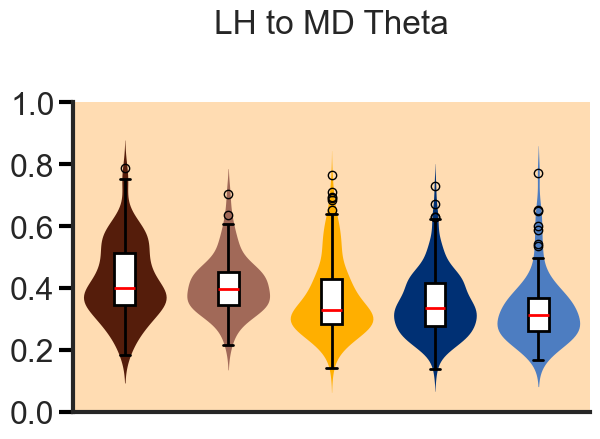

cluster_mean_trial_LH-to-mPFC_granger_gamma


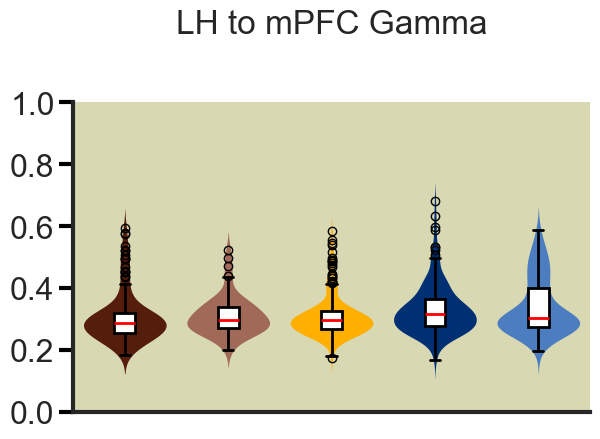

cluster_mean_trial_LH-to-mPFC_granger_theta


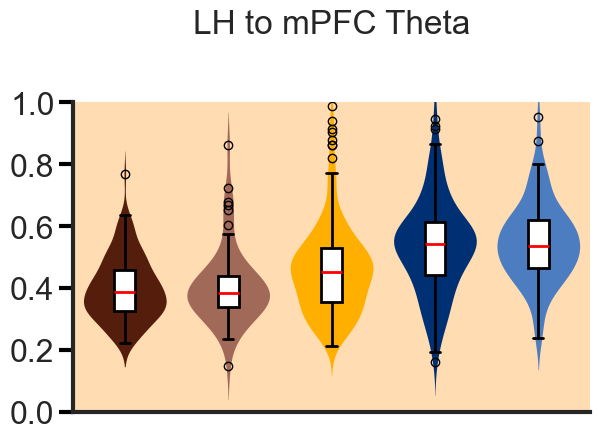

cluster_mean_trial_LH-to-vHPC_granger_gamma


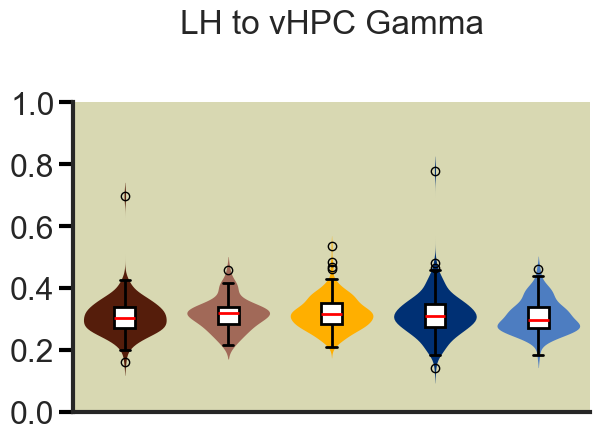

cluster_mean_trial_LH-to-vHPC_granger_theta


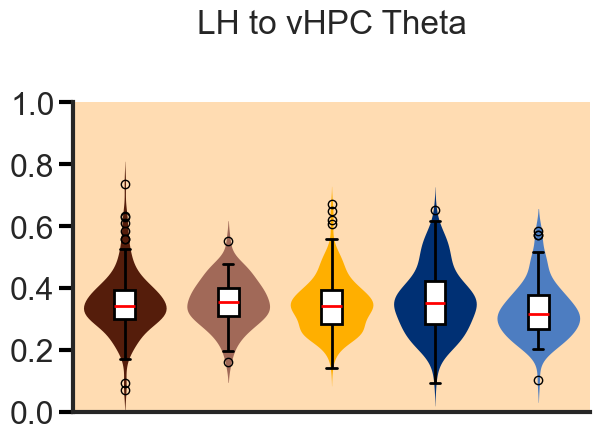

cluster_mean_trial_MD-to-BLA_granger_gamma


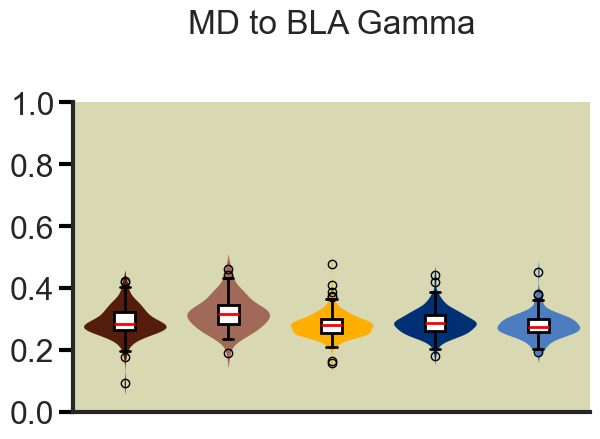

cluster_mean_trial_MD-to-BLA_granger_theta


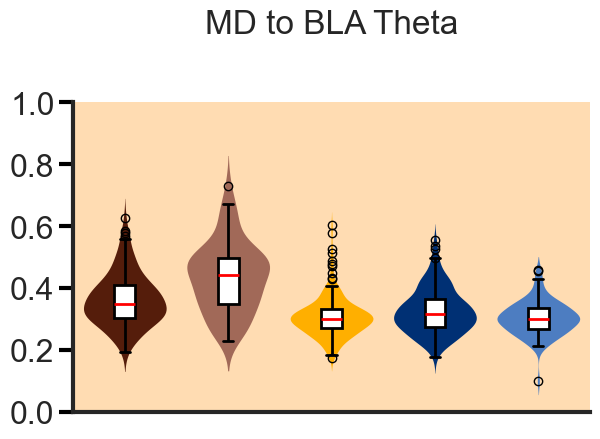

cluster_mean_trial_MD-to-LH_granger_gamma


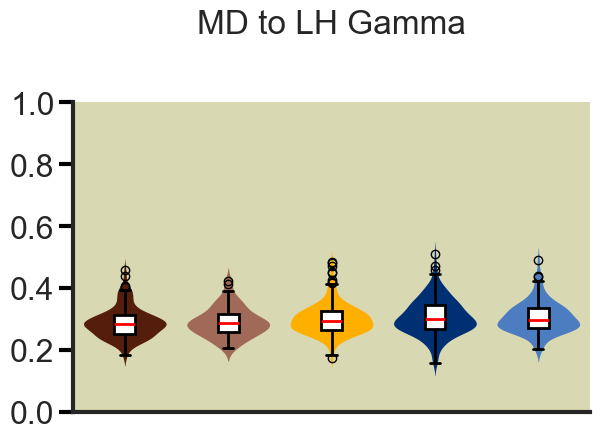

cluster_mean_trial_MD-to-LH_granger_theta


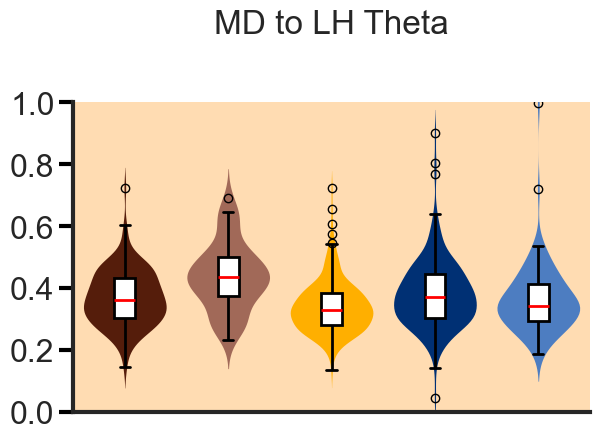

cluster_mean_trial_MD-to-mPFC_granger_gamma


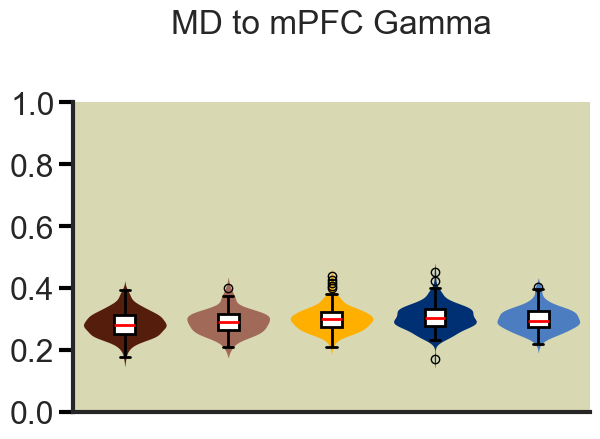

cluster_mean_trial_MD-to-mPFC_granger_theta


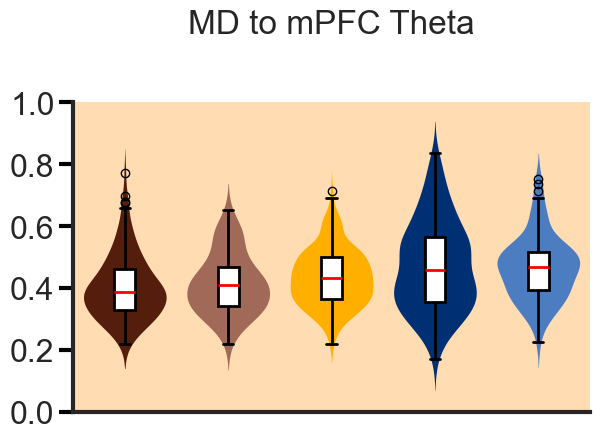

cluster_mean_trial_MD-to-vHPC_granger_gamma


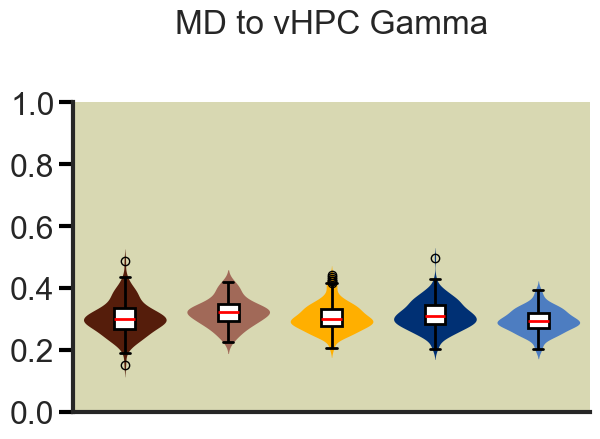

cluster_mean_trial_MD-to-vHPC_granger_theta


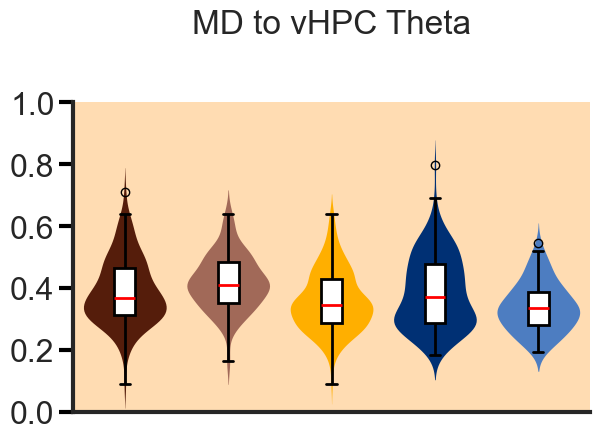

cluster_mean_trial_mPFC-to-BLA_granger_gamma


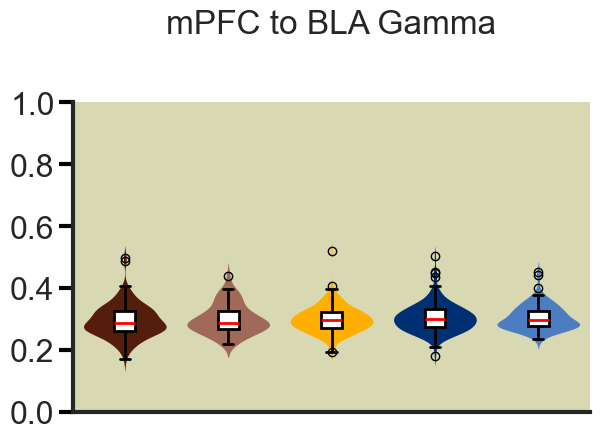

cluster_mean_trial_mPFC-to-BLA_granger_theta


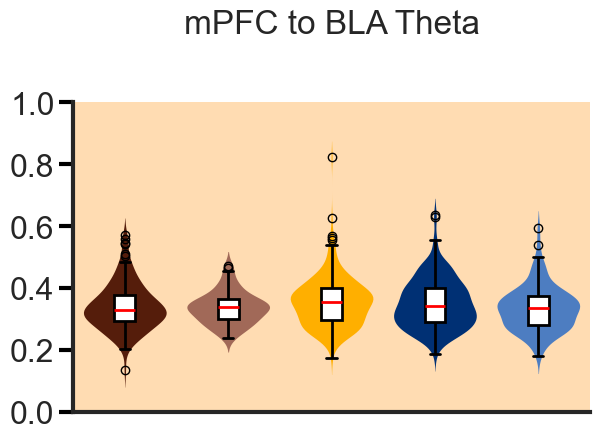

cluster_mean_trial_mPFC-to-LH_granger_gamma


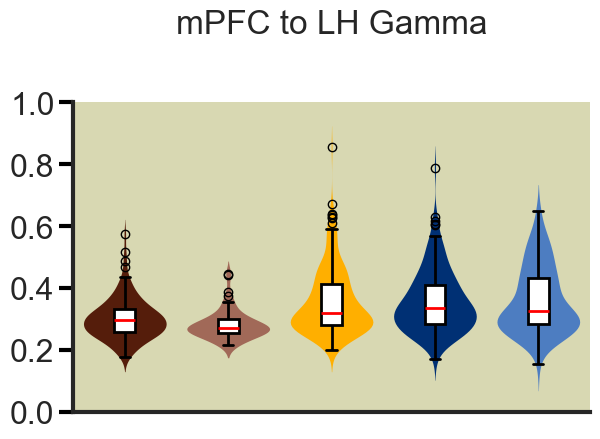

cluster_mean_trial_mPFC-to-LH_granger_theta


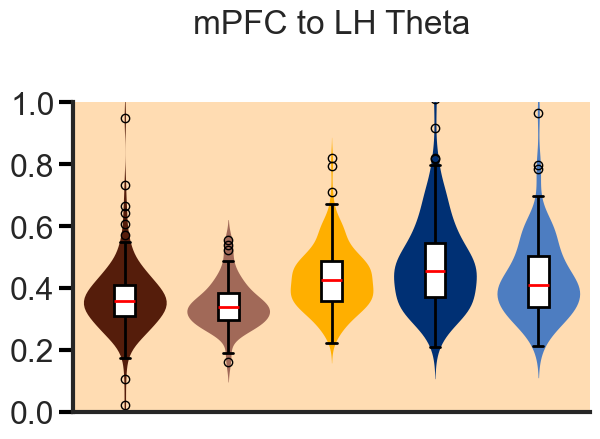

cluster_mean_trial_mPFC-to-MD_granger_gamma


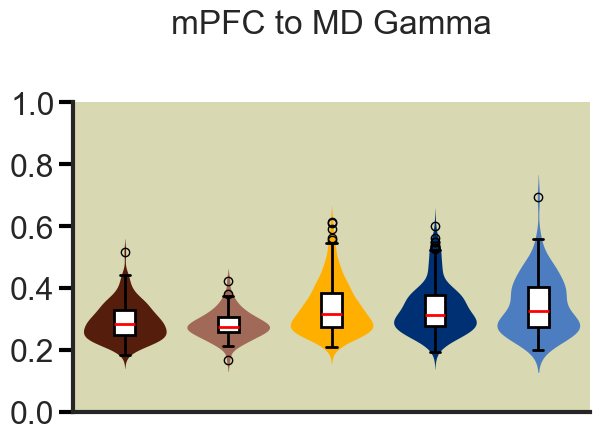

cluster_mean_trial_mPFC-to-MD_granger_theta


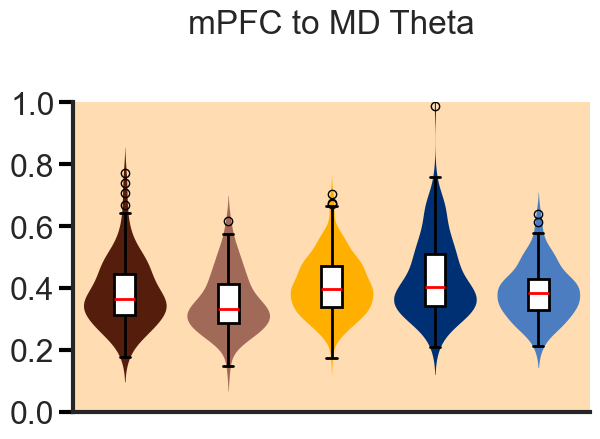

cluster_mean_trial_mPFC-to-vHPC_granger_gamma


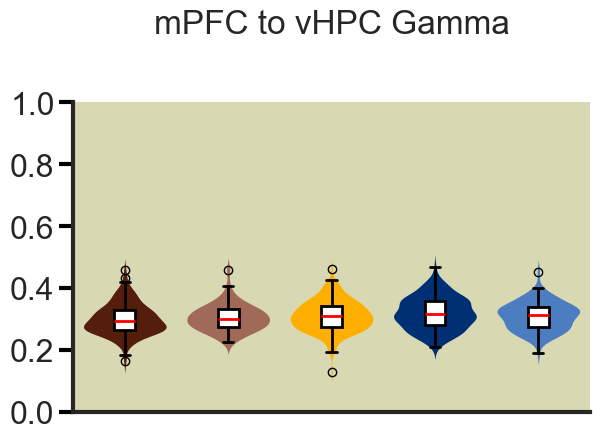

cluster_mean_trial_mPFC-to-vHPC_granger_theta


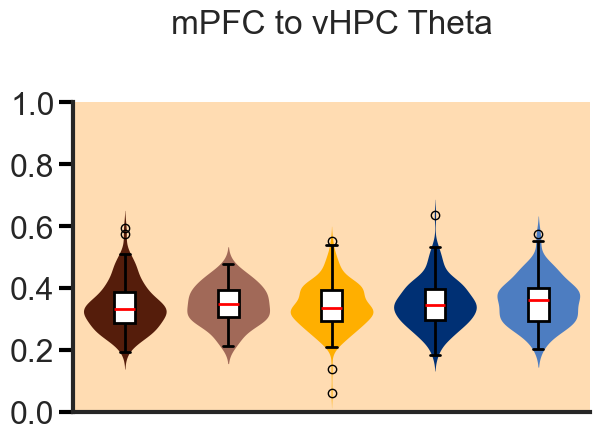

cluster_mean_trial_vHPC-to-BLA_granger_gamma


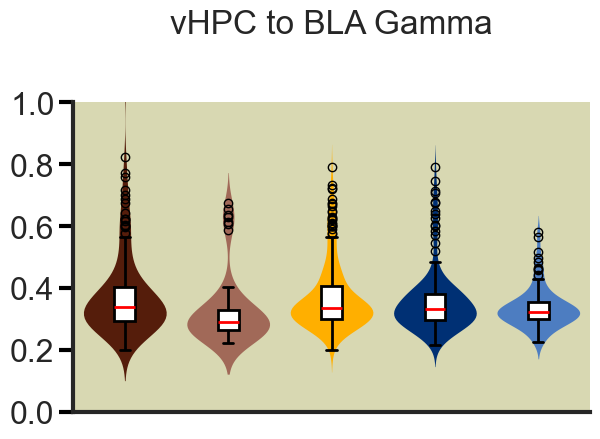

cluster_mean_trial_vHPC-to-BLA_granger_theta


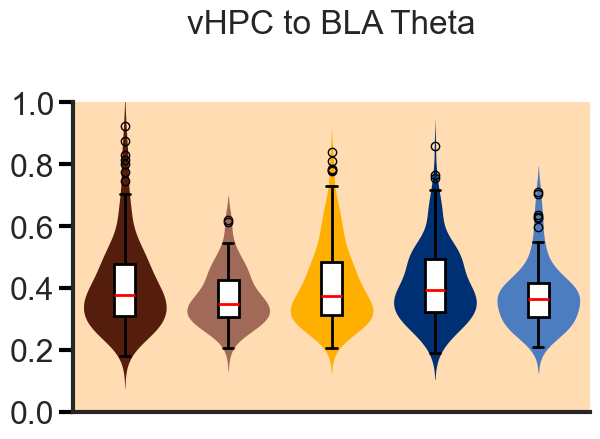

cluster_mean_trial_vHPC-to-LH_granger_gamma


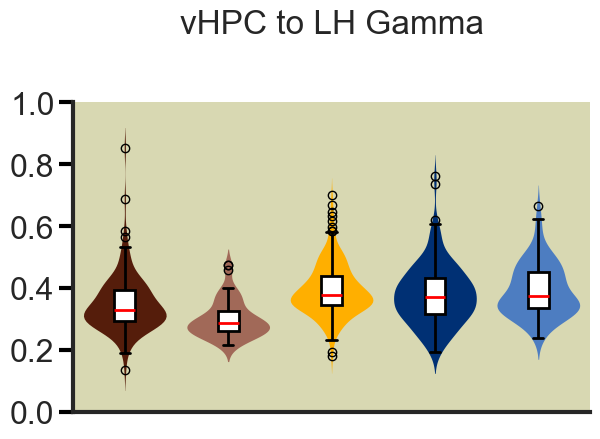

cluster_mean_trial_vHPC-to-LH_granger_theta


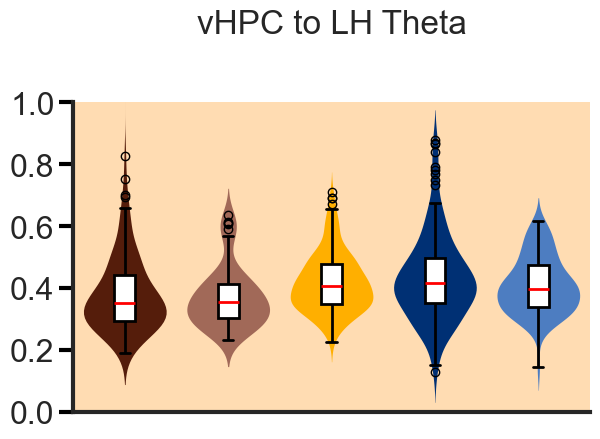

cluster_mean_trial_vHPC-to-MD_granger_gamma


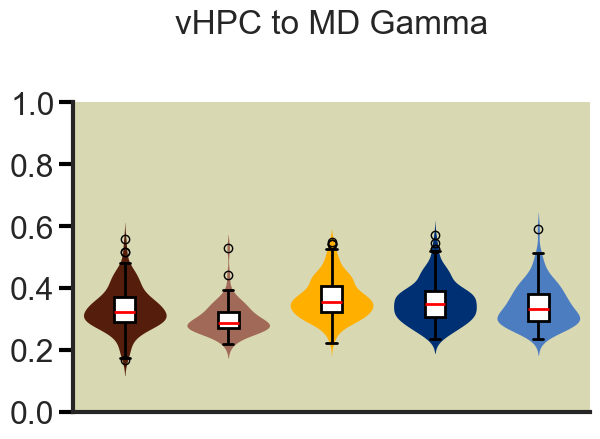

cluster_mean_trial_vHPC-to-MD_granger_theta


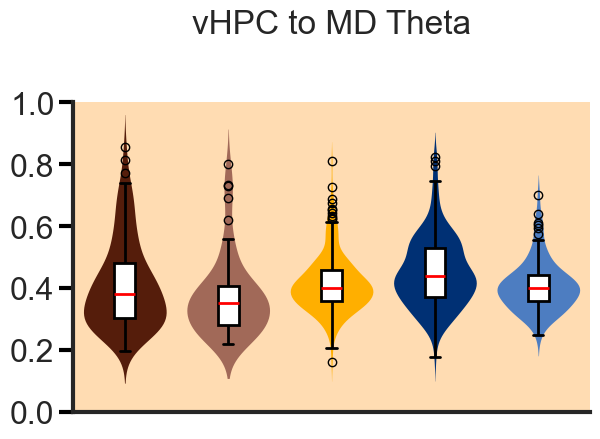

cluster_mean_trial_vHPC-to-mPFC_granger_gamma


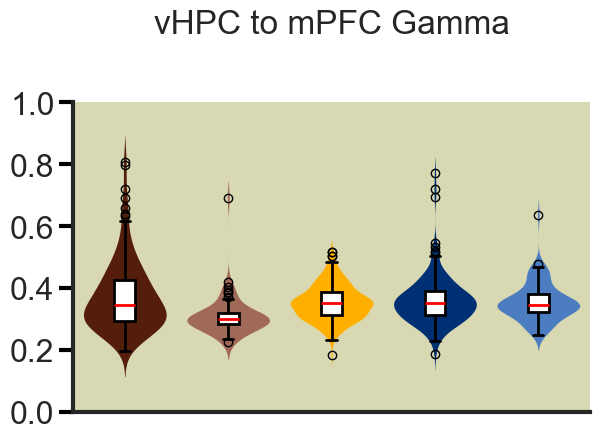

cluster_mean_trial_vHPC-to-mPFC_granger_theta


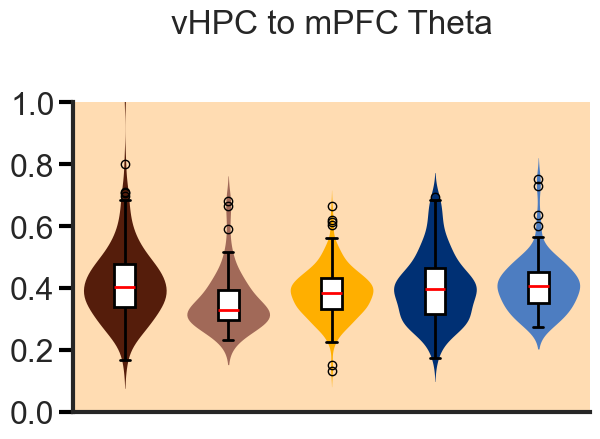

cluster_mean_trial_BLA_power_gamma


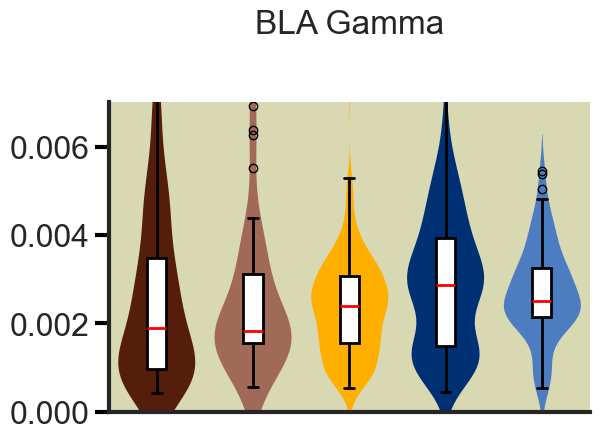

cluster_mean_trial_BLA_power_theta


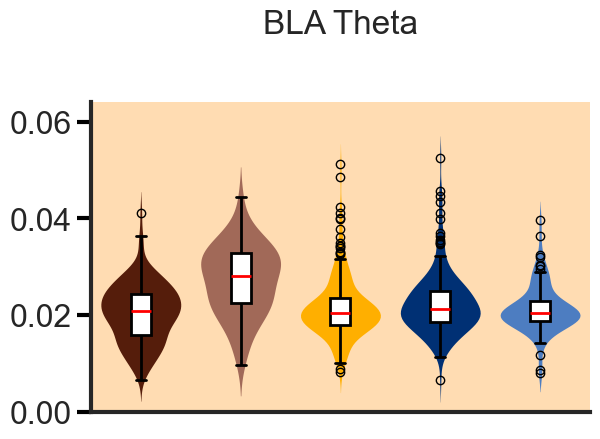

cluster_mean_trial_LH_power_gamma


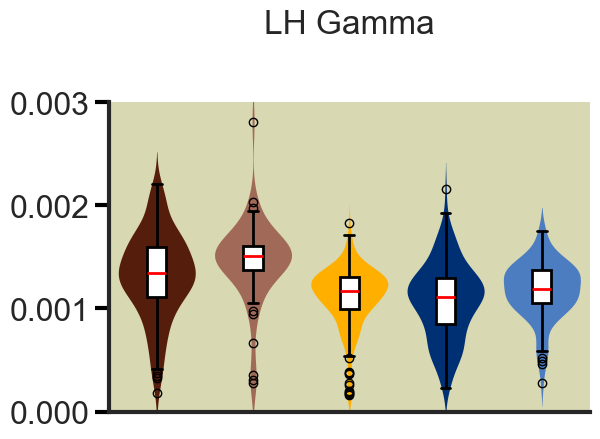

cluster_mean_trial_LH_power_theta


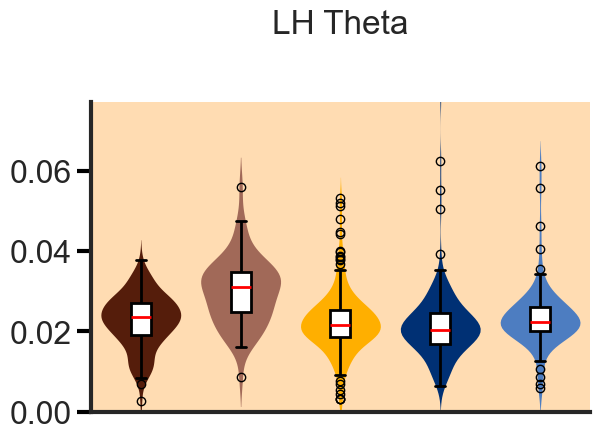

cluster_mean_trial_MD_power_gamma


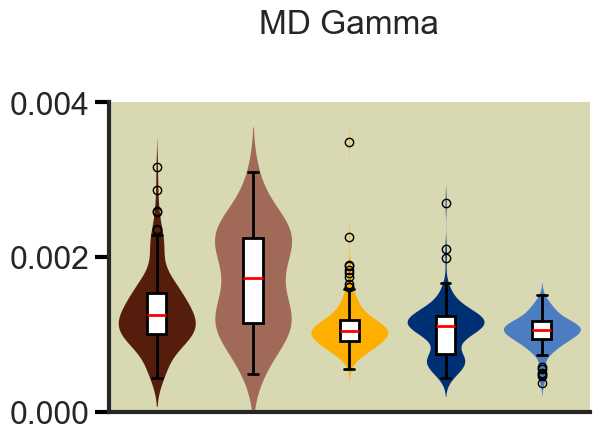

cluster_mean_trial_MD_power_theta


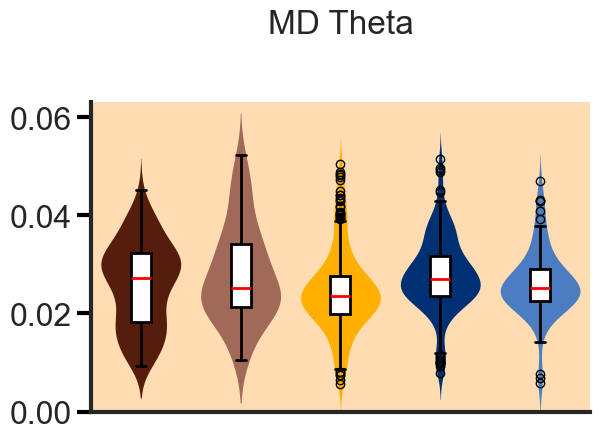

cluster_mean_trial_mPFC_power_gamma


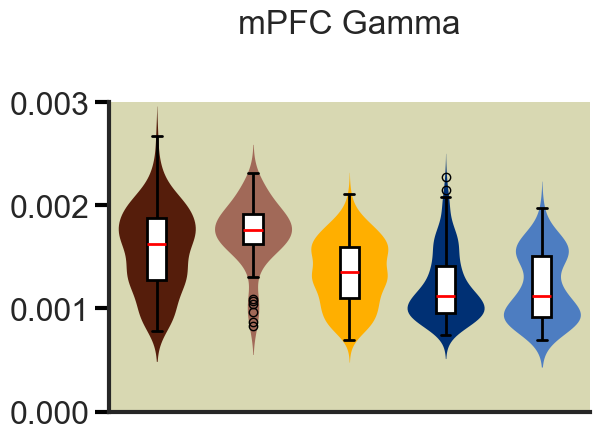

cluster_mean_trial_mPFC_power_theta


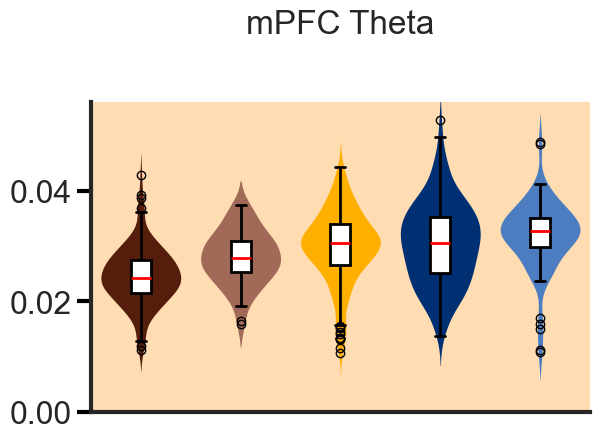

cluster_mean_trial_vHPC_power_gamma


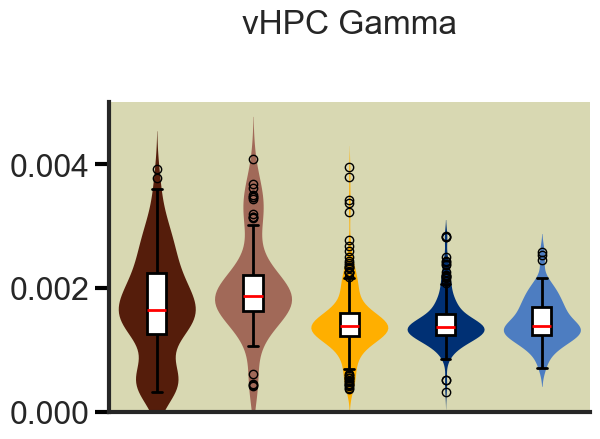

cluster_mean_trial_vHPC_power_theta


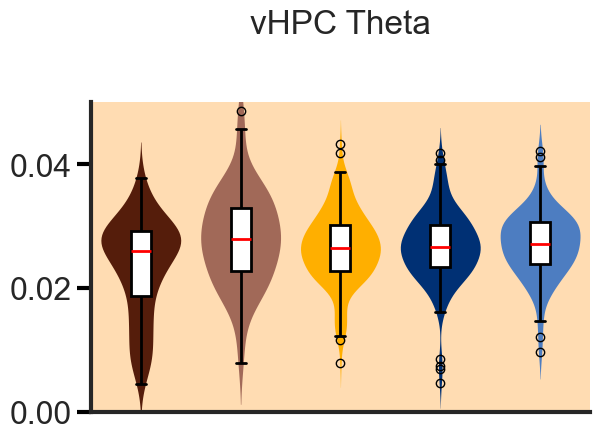

In [171]:
for col in [col for col in export_cluster_exploded_TRIALS_AND_SPECTRAL_DF if ("cluster_mean_trial" in col and "all_frequencies" not in col)]:
    if "timestamps" in col or "velocity" in col:
        continue  
    
    print(col)
    sns.set_style('white', {'axes.linewidth': 0.5})
    plt.rcParams['xtick.major.size'] = 20
    plt.rcParams['xtick.major.width'] = 4
    plt.rcParams['xtick.bottom'] = True
    plt.rcParams['ytick.left'] = True

    # Plot the transition matrix using only matplotlib
    fig, ax = plt.subplots(figsize=(6.4, 4.8))

    # ax = sns.violinplot(data=combined_sampled_df, x='bar_ticks', y=col, hue='trial_and_competitiveness_label',
    #     palette=comp_id_to_color,
    #                     inner=None, linewidth=0, saturation=1)
    
    # sns.boxplot(x='bar_ticks', y=col, data=combined_sampled_df.sort_values(["trial_and_competitiveness_label"]), color='white',            # hue='competitiveness_grouping',    palette=comp_to_color, 
    #             width=0.2,
    #             # boxprops={'zorder': 2}, 
    #             ax=ax, fill=True, linecolor="black", linewidth=2, medianprops=dict(color="red", alpha=1))

    ax = sns.violinplot(data=export_cluster_exploded_TRIALS_AND_SPECTRAL_DF.sort_values(["trial_and_competitiveness_label"]), x='bar_ticks', y=col, hue='trial_and_competitiveness_label',
        palette=comp_id_to_color,
                        inner=None, linewidth=0, saturation=1)
    
    sns.boxplot(x='bar_ticks', y=col, data=export_cluster_exploded_TRIALS_AND_SPECTRAL_DF.sort_values(["trial_and_competitiveness_label"]), color='white',            # hue='competitiveness_grouping',    palette=comp_to_color, 
                width=0.2,
                # boxprops={'zorder': 2}, 
                ax=ax, fill=True, linecolor="black", linewidth=2, medianprops=dict(color="red", alpha=1))

    plt.legend([],[], frameon=False)

        # Hide top and right borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Leave bottom and left spines
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['left'].set_linewidth(3)

    ax.tick_params(axis='both', which='major', labelsize=23, length=10, width=3, color='black')
    ax.tick_params(axis='both', which='minor', labelsize=23, length=10, width=3, color='black')

    if "granger" in col:
        # title = "{}".format(col.replace(".", "-").replace("cluster_mean_trial_", "").replace("cluster_mean_trial_and_post_", "").replace("RMS_filtered_", "").replace("all_frequencies_all_windows", "").replace("power", "").replace("granger", "")).replace("coherence", "").replace("_", " ").replace("  ", " ").strip().replace(" ", " to ").replace("predicted", "").strip()
        title = col.replace("cluster_mean_trial_", "").replace("predicted_cluster_mean_trial_", "").replace("power", "").replace("granger", "").replace("coherence", "").replace("_", " ").replace("  ", " ").replace(".", " ").replace("-to-", " to ")

    else:
        # title = "{}".format(col.replace(".", "-").replace("cluster_mean_trial_", "").replace("cluster_mean_trial_and_post_", "").replace("RMS_filtered_", "").replace("all_frequencies_all_windows", "").replace("power", "").replace("granger", "")).replace("coherence", "").replace("_", " ").replace("  ", " ").replace("predicted", "").strip()
        title = col.replace("cluster_mean_trial_", "").replace("predicted_cluster_mean_trial_", "").replace("power", "").replace("granger", "").replace("coherence", "").replace("_", " ").replace("  ", " ").replace(".", " ")
    
    if "coherence" in col:
        plt.ylim(0, 1)
        plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1]) 
    if "granger" in col:
        plt.ylim(0, 1)
        plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1]) 
    elif "power" in col:
        plt.ylim(0, np.round(combined_sampled_df[col].max() * 1.25, decimals=3))
        if "theta" in col:
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        elif "gamma" in col:
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

    if "coherence" in col:
        plt.ylabel('Coherence', size=30)

    elif "granger" in col:
        plt.ylabel('Granger Causality', size=30)

    elif "power" in col: 
        plt.ylabel('Normalized Power (a.u.)', size=30)
    
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off

    plt.xticks(visible=False)

    ax.set(xlabel=None)
    ax.set(ylabel=None)

    plt.title(title.replace("theta", "Theta").replace("gamma", "Gamma"), pad=50)
    plt.tight_layout()
    
    if "coherence" in col:
        sub_dir = "coherence"

    elif "granger" in col:
        sub_dir = "granger"

    elif "power" in col: 
        sub_dir = "power"

    if "theta" in col:
        ax.patch.set_facecolor(BAND_TO_FREQ_COLOR["theta"])
        ax.patch.set_alpha(0.3)

    elif "gamma" in col:
        ax.patch.set_facecolor(BAND_TO_FREQ_COLOR["gamma"])
        ax.patch.set_alpha(0.3)

    plt.savefig("./proc/spectra_bar/{}/{}_bar.png".format(sub_dir, col.replace("cluster_mean_trial_", "").replace("predicted_", "")))
    plt.savefig("./proc/spectra_bar/{}/{}_bar.svg".format(sub_dir, col.replace("cluster_mean_trial_", "").replace("predicted_", "")))
    plt.show()
    






predicted_cluster_mean_trial_BLA.to.LH_granger_gamma


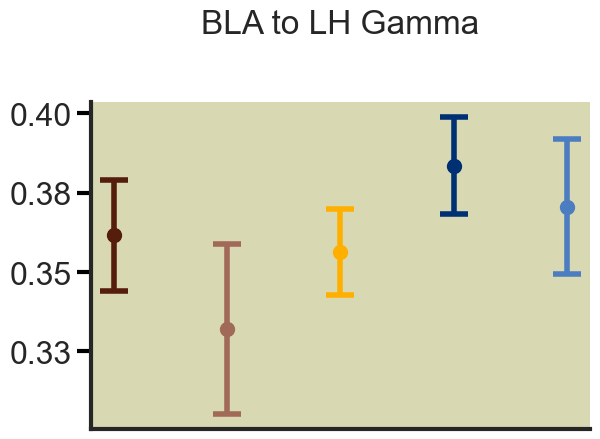

predicted_cluster_mean_trial_BLA.to.LH_granger_theta


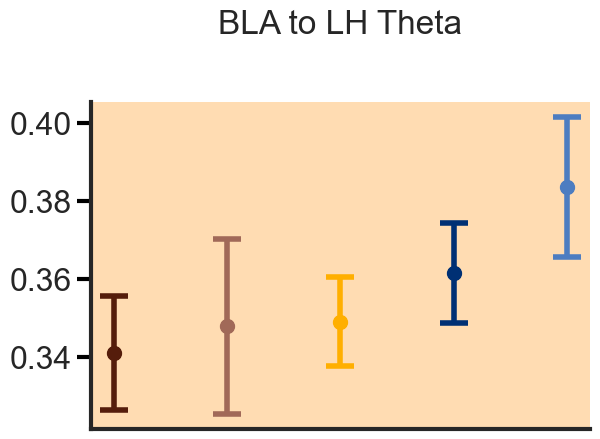

predicted_cluster_mean_trial_BLA.to.MD_granger_gamma


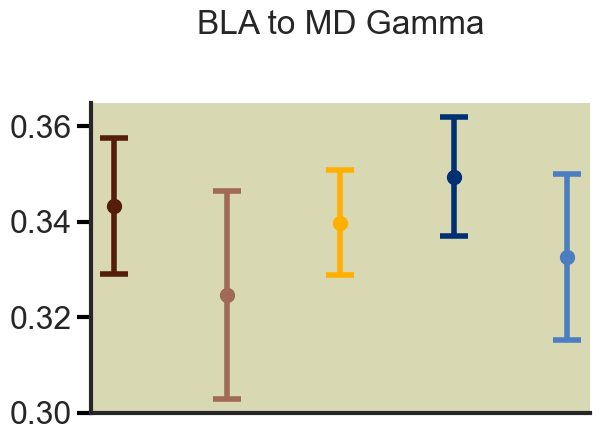

predicted_cluster_mean_trial_BLA.to.MD_granger_theta


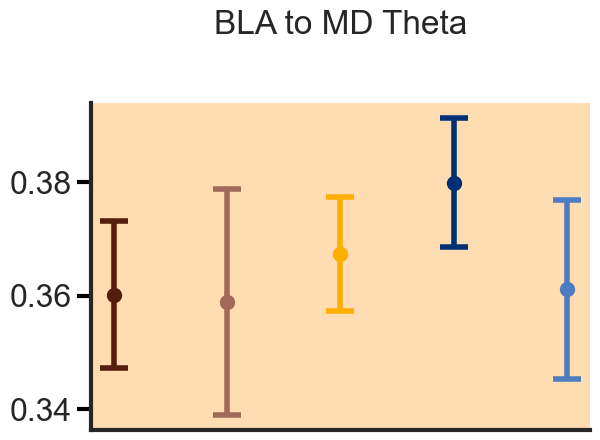

predicted_cluster_mean_trial_BLA.to.mPFC_granger_gamma


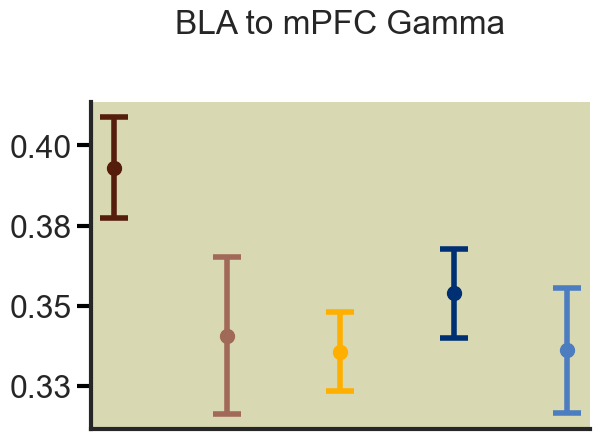

predicted_cluster_mean_trial_BLA.to.mPFC_granger_theta


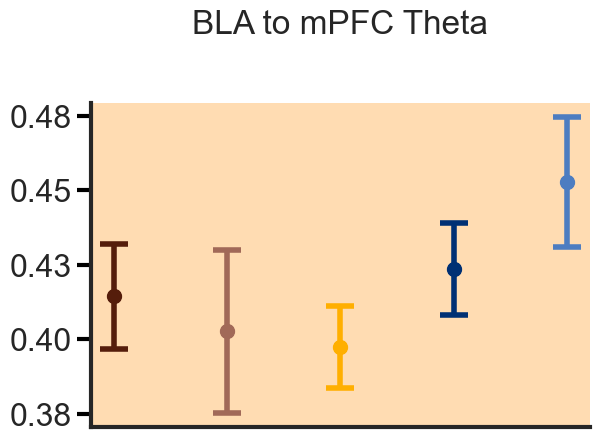

predicted_cluster_mean_trial_BLA.to.vHPC_granger_gamma


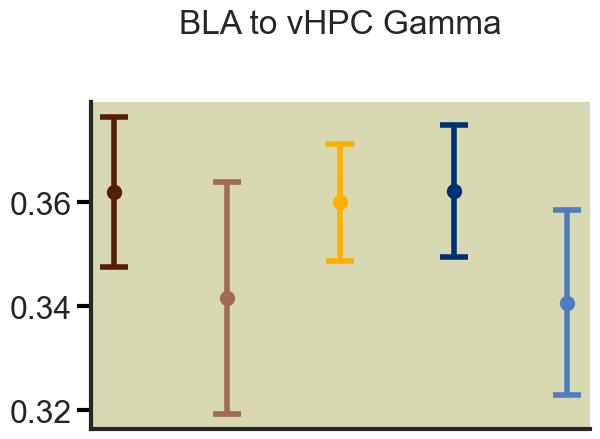

predicted_cluster_mean_trial_BLA.to.vHPC_granger_theta


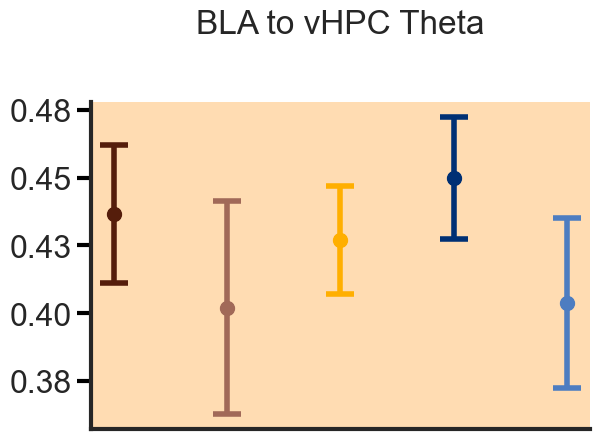

predicted_cluster_mean_trial_BLA_LH_coherence_gamma


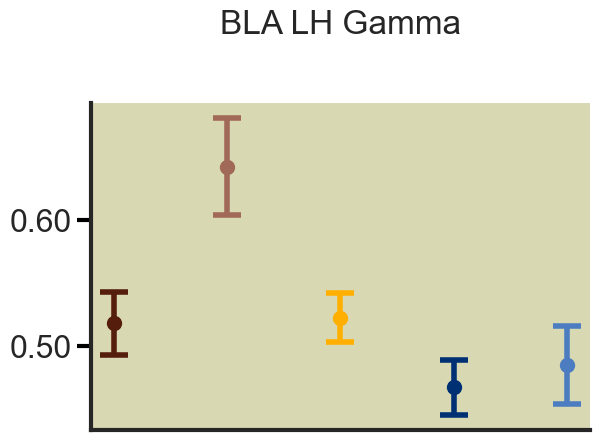

predicted_cluster_mean_trial_BLA_LH_coherence_theta


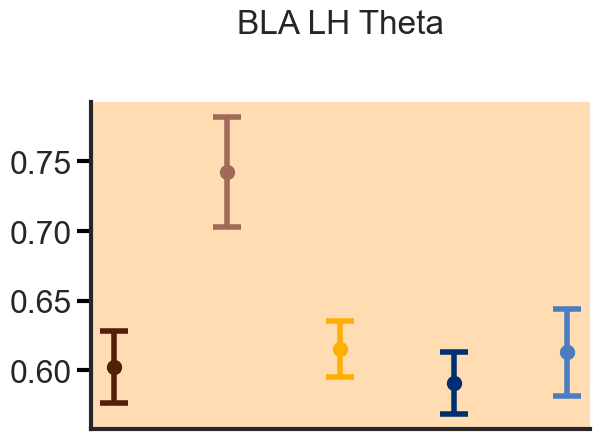

predicted_cluster_mean_trial_BLA_MD_coherence_gamma


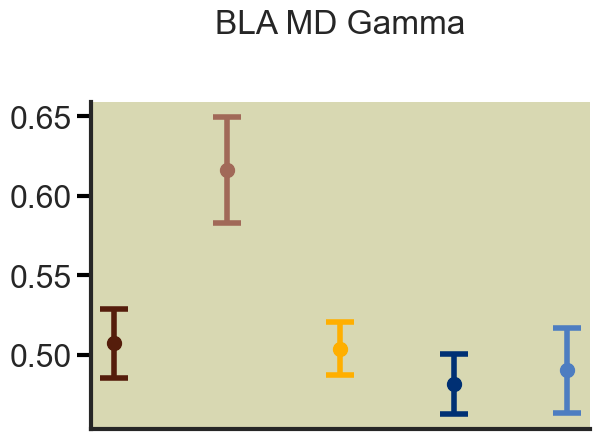

predicted_cluster_mean_trial_BLA_MD_coherence_theta


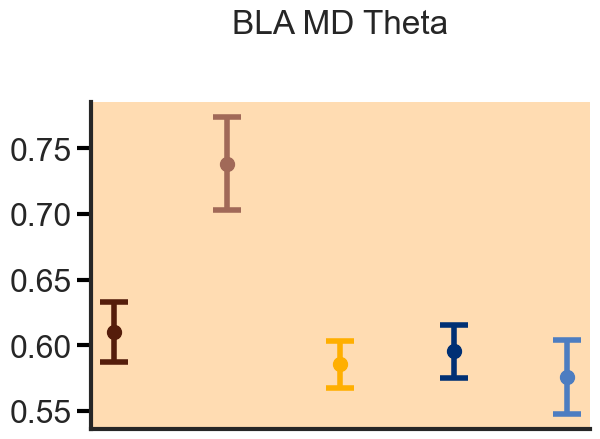

predicted_cluster_mean_trial_BLA_mPFC_coherence_gamma


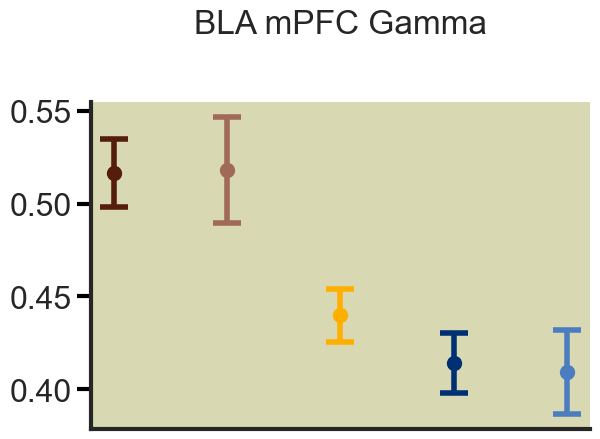

predicted_cluster_mean_trial_BLA_mPFC_coherence_theta


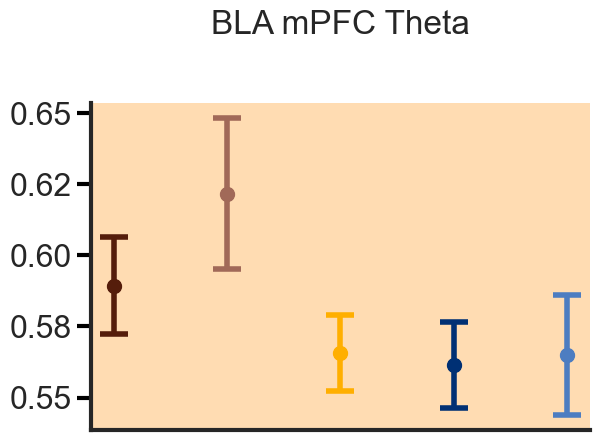

predicted_cluster_mean_trial_BLA_power_gamma


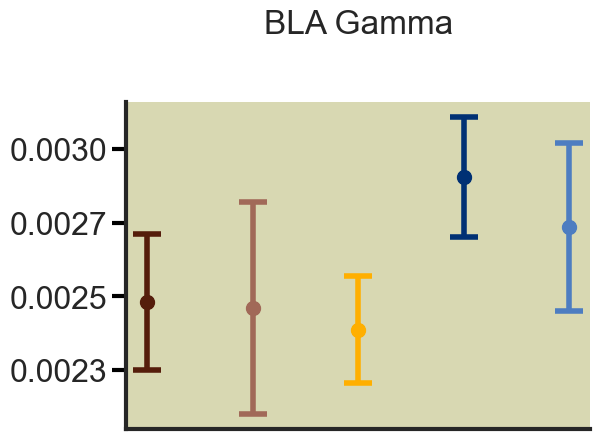

predicted_cluster_mean_trial_BLA_power_theta


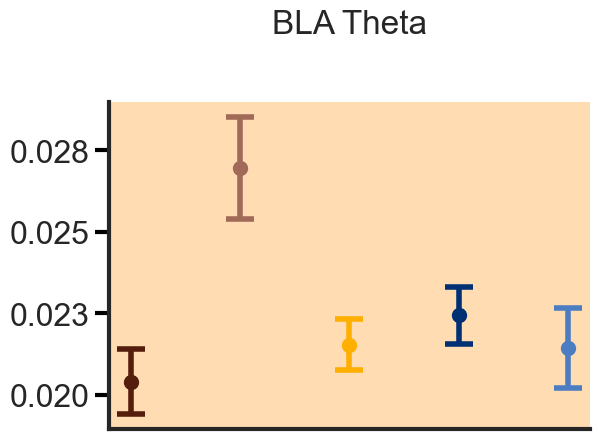

predicted_cluster_mean_trial_BLA_vHPC_coherence_gamma


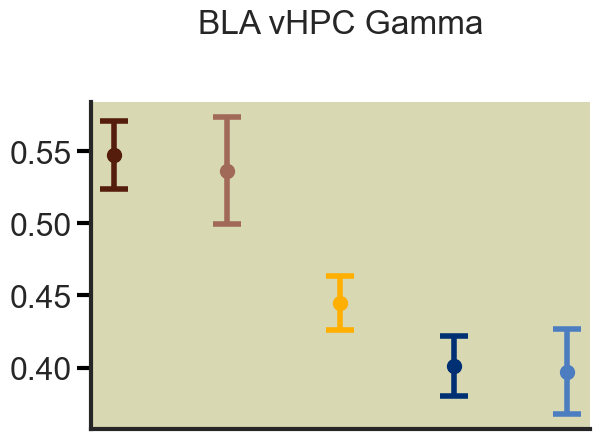

predicted_cluster_mean_trial_BLA_vHPC_coherence_theta


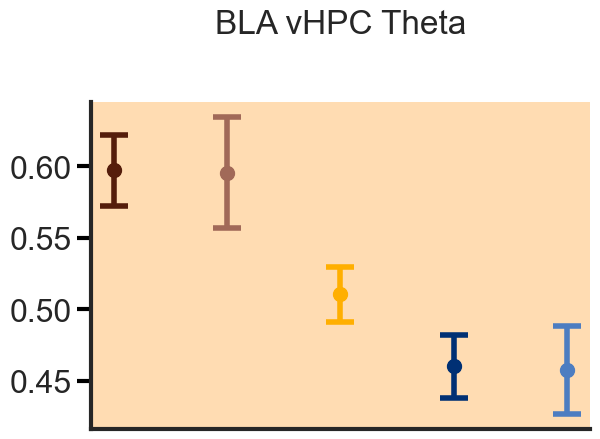

predicted_cluster_mean_trial_LH.to.BLA_granger_gamma


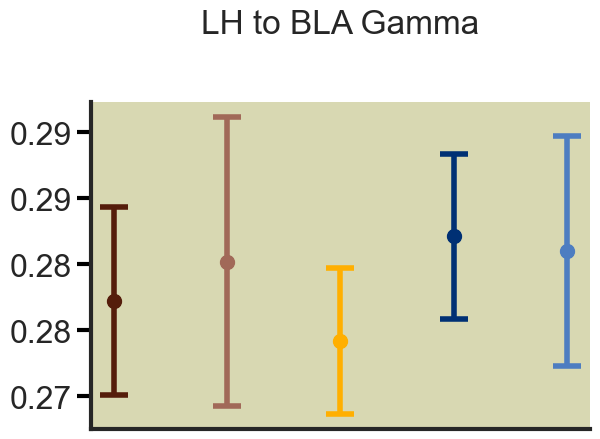

predicted_cluster_mean_trial_LH.to.BLA_granger_theta


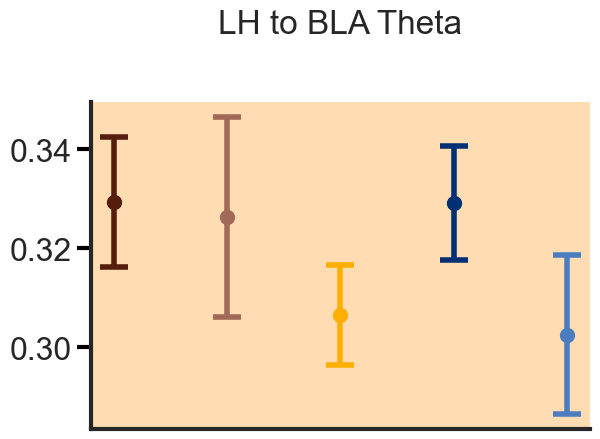

predicted_cluster_mean_trial_LH.to.MD_granger_gamma


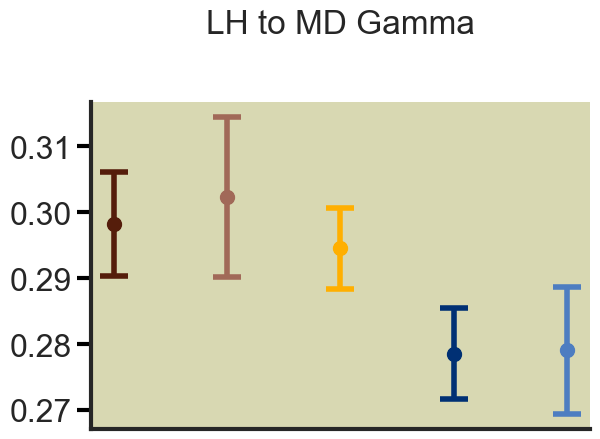

predicted_cluster_mean_trial_LH.to.MD_granger_theta


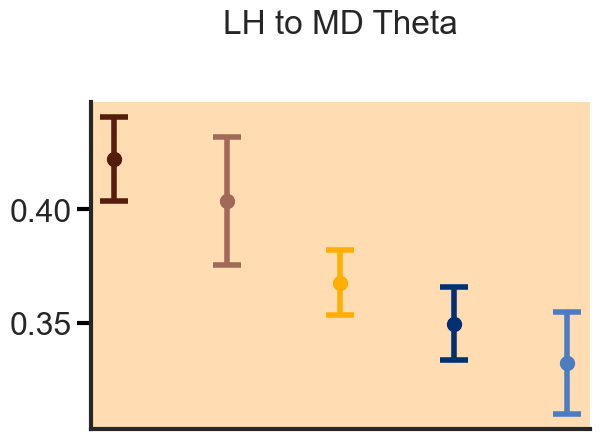

predicted_cluster_mean_trial_LH.to.mPFC_granger_gamma


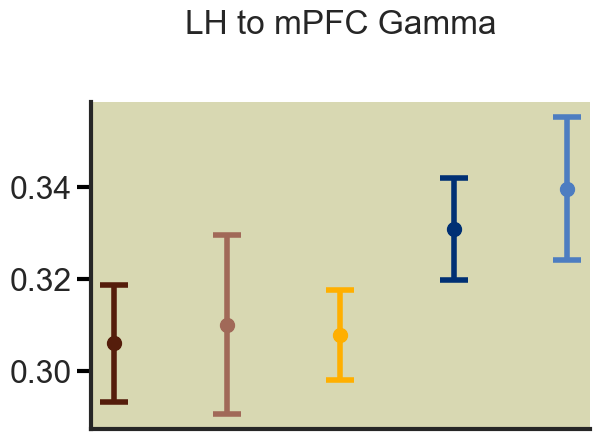

predicted_cluster_mean_trial_LH.to.mPFC_granger_theta


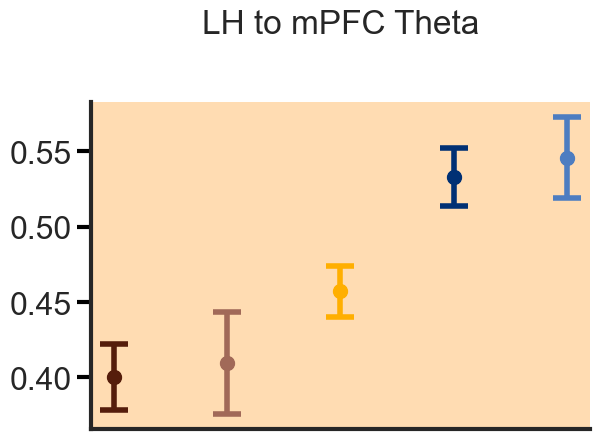

predicted_cluster_mean_trial_LH.to.vHPC_granger_gamma


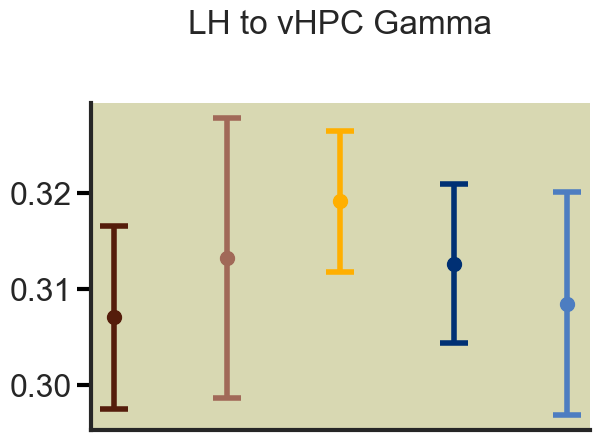

predicted_cluster_mean_trial_LH.to.vHPC_granger_theta


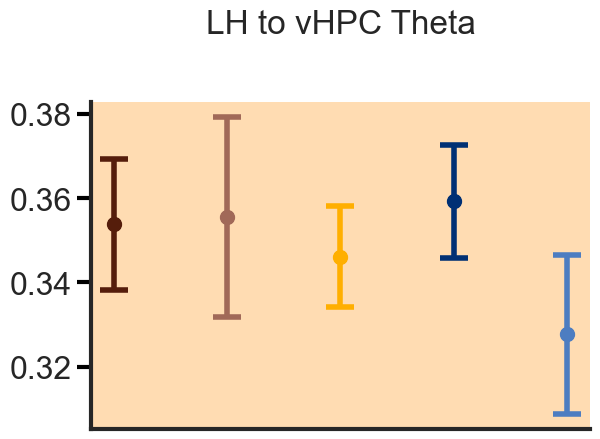

predicted_cluster_mean_trial_LH_MD_coherence_gamma


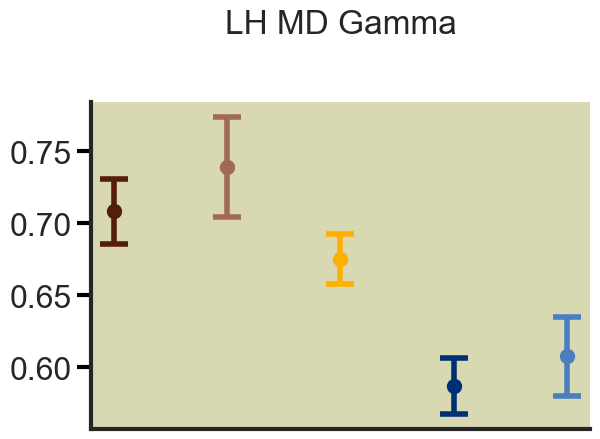

predicted_cluster_mean_trial_LH_MD_coherence_theta


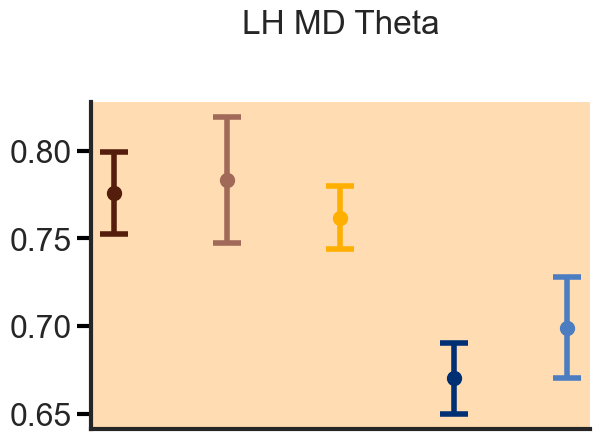

predicted_cluster_mean_trial_LH_mPFC_coherence_gamma


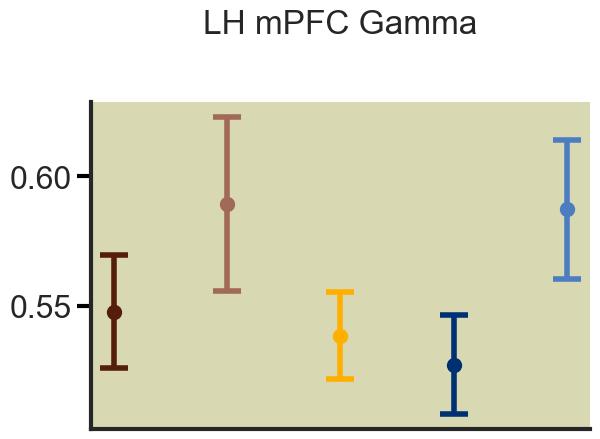

predicted_cluster_mean_trial_LH_mPFC_coherence_theta


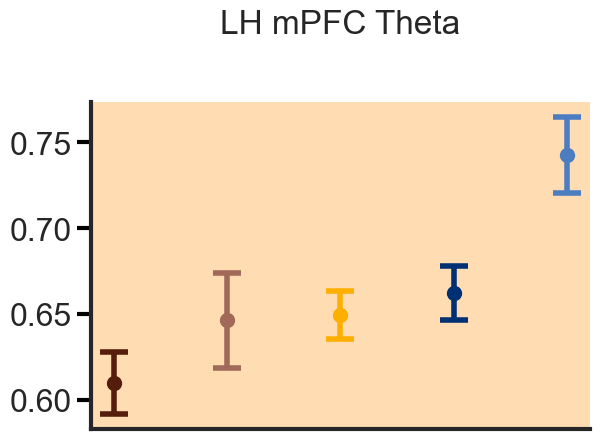

predicted_cluster_mean_trial_LH_power_gamma


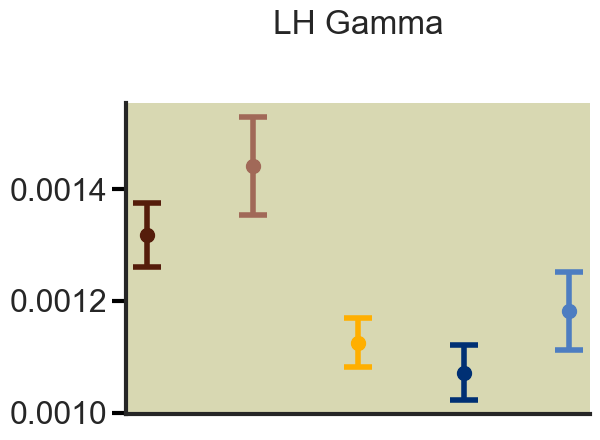

predicted_cluster_mean_trial_LH_power_theta


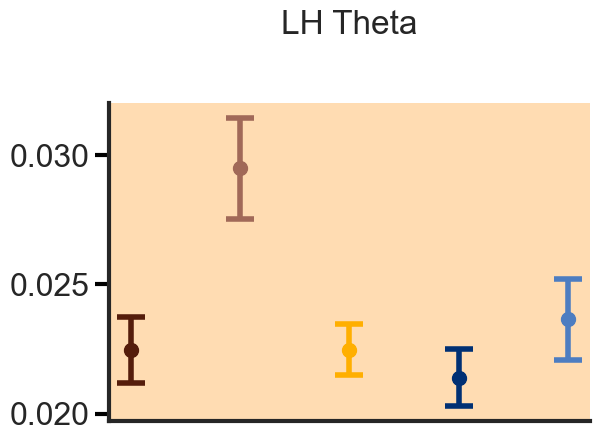

predicted_cluster_mean_trial_LH_vHPC_coherence_gamma


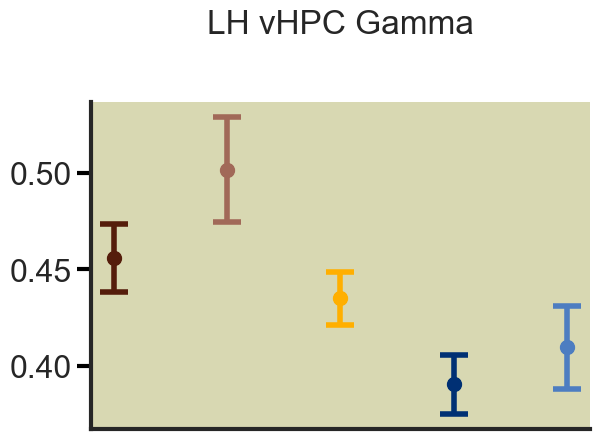

predicted_cluster_mean_trial_LH_vHPC_coherence_theta


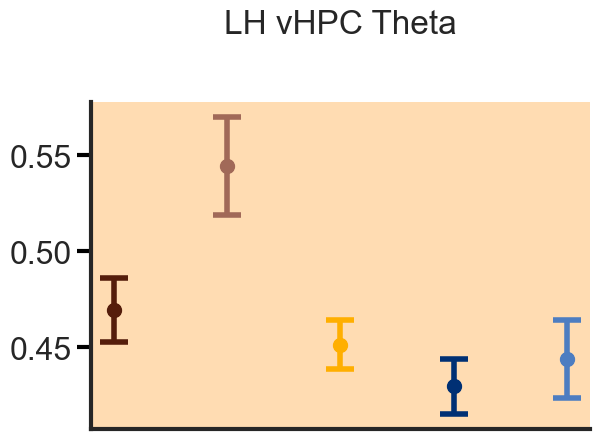

predicted_cluster_mean_trial_MD.to.BLA_granger_gamma


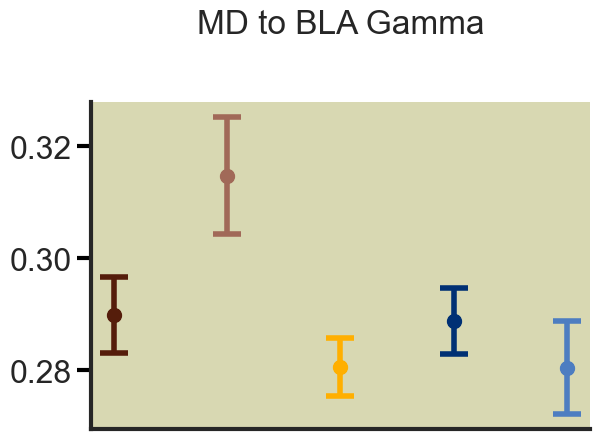

predicted_cluster_mean_trial_MD.to.BLA_granger_theta


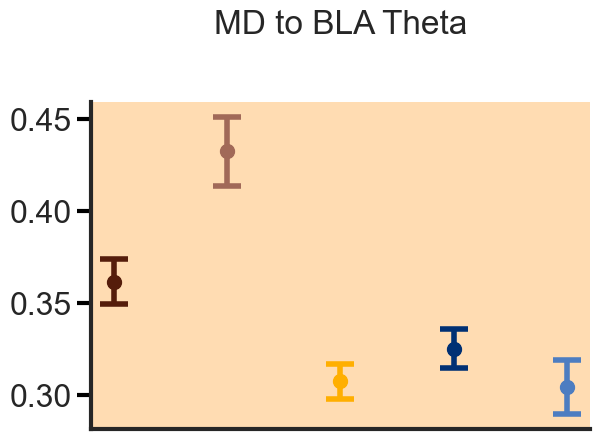

predicted_cluster_mean_trial_MD.to.LH_granger_gamma


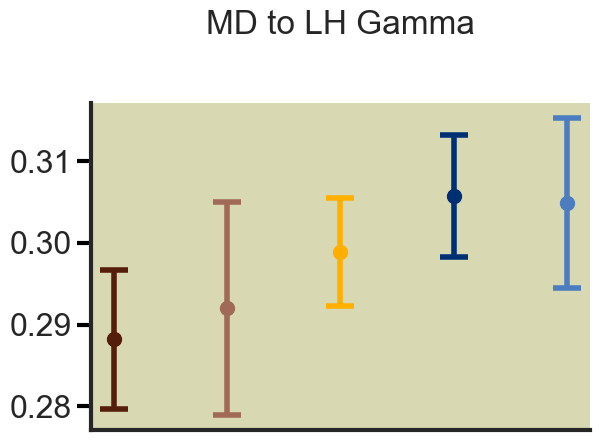

predicted_cluster_mean_trial_MD.to.LH_granger_theta


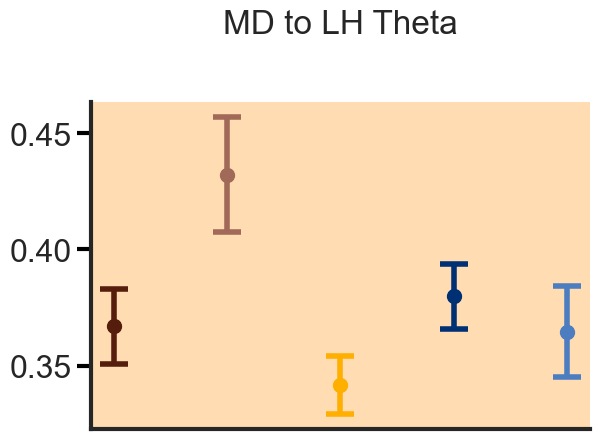

predicted_cluster_mean_trial_MD.to.mPFC_granger_gamma


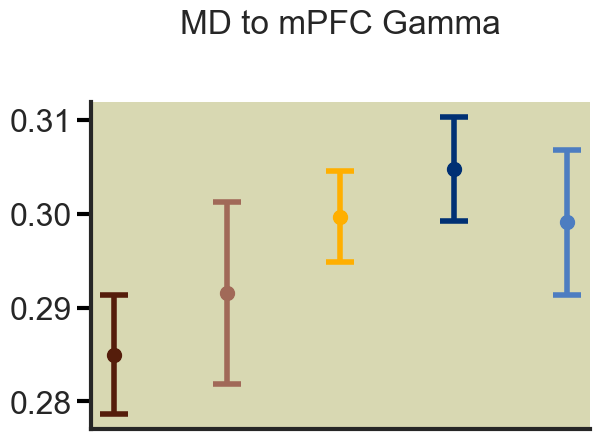

predicted_cluster_mean_trial_MD.to.mPFC_granger_theta


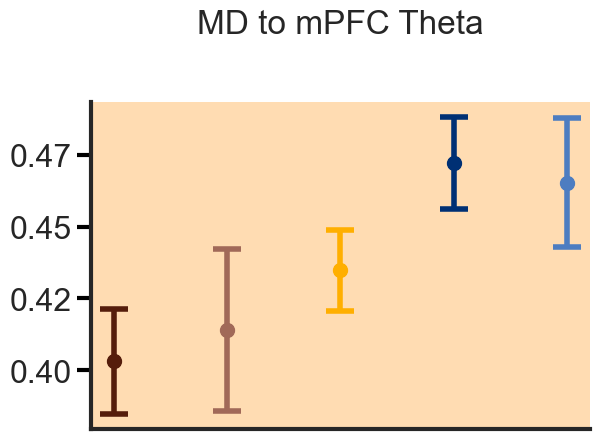

predicted_cluster_mean_trial_MD.to.vHPC_granger_gamma


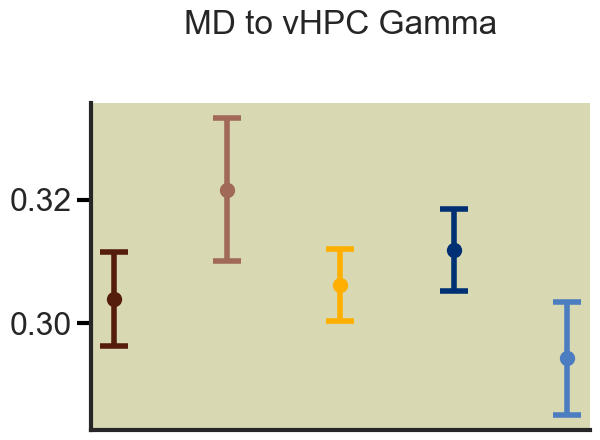

predicted_cluster_mean_trial_MD.to.vHPC_granger_theta


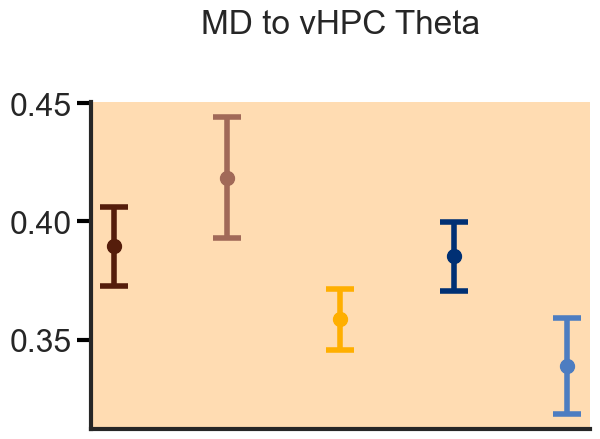

predicted_cluster_mean_trial_MD_mPFC_coherence_gamma


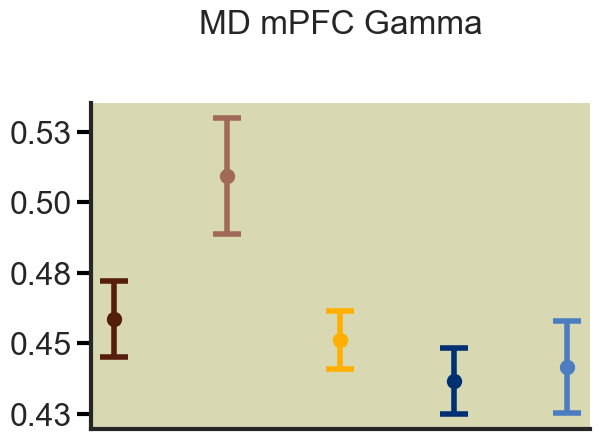

predicted_cluster_mean_trial_MD_mPFC_coherence_theta


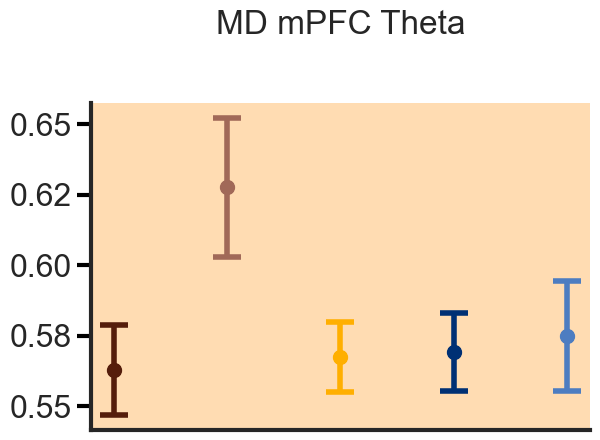

predicted_cluster_mean_trial_MD_power_gamma


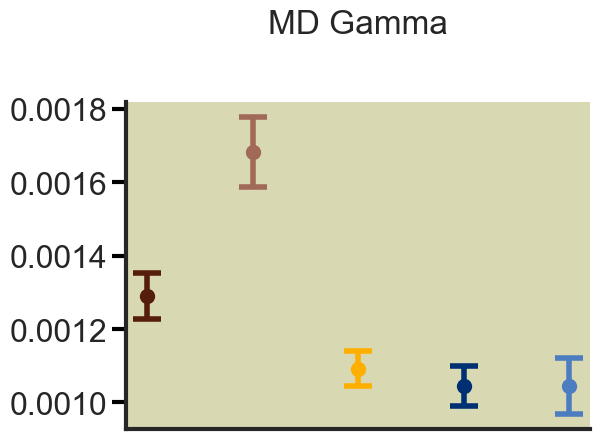

predicted_cluster_mean_trial_MD_power_theta


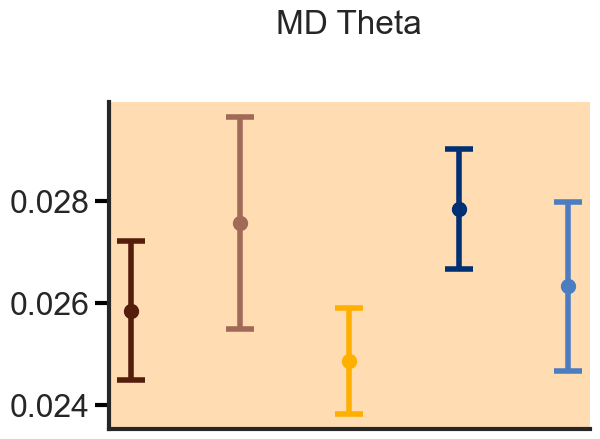

predicted_cluster_mean_trial_MD_vHPC_coherence_gamma


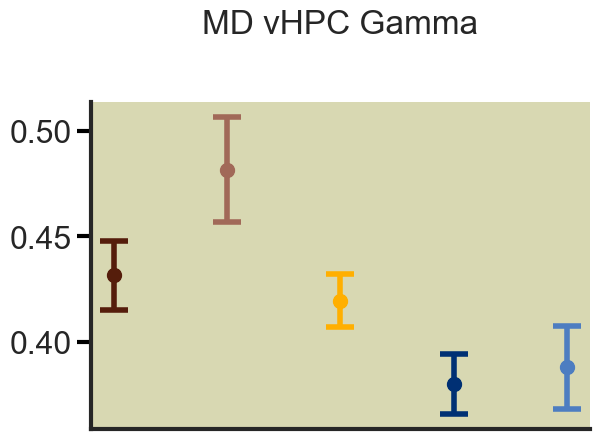

predicted_cluster_mean_trial_MD_vHPC_coherence_theta


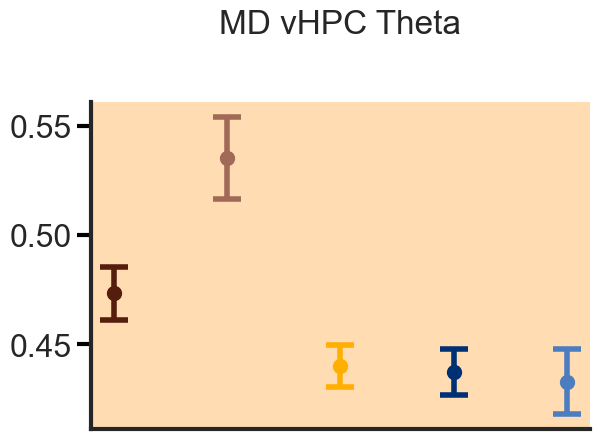

predicted_cluster_mean_trial_mPFC.to.BLA_granger_gamma


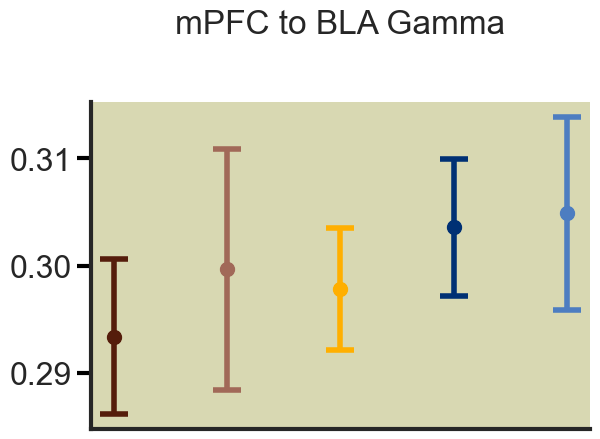

predicted_cluster_mean_trial_mPFC.to.BLA_granger_theta


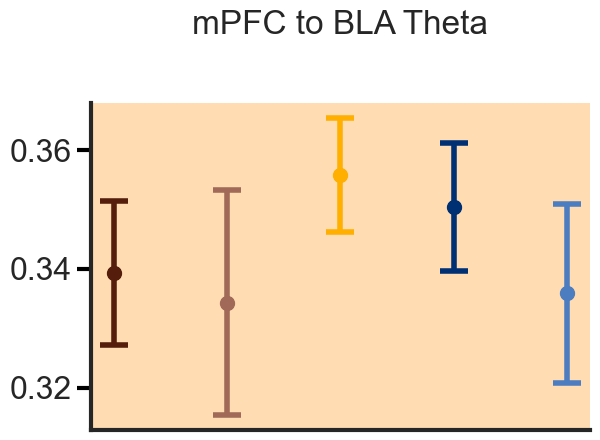

predicted_cluster_mean_trial_mPFC.to.LH_granger_gamma


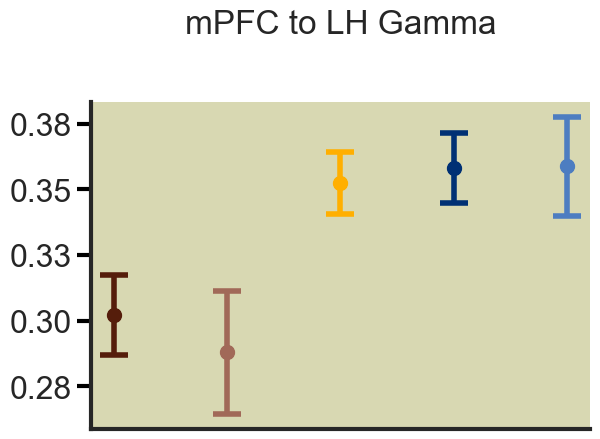

predicted_cluster_mean_trial_mPFC.to.LH_granger_theta


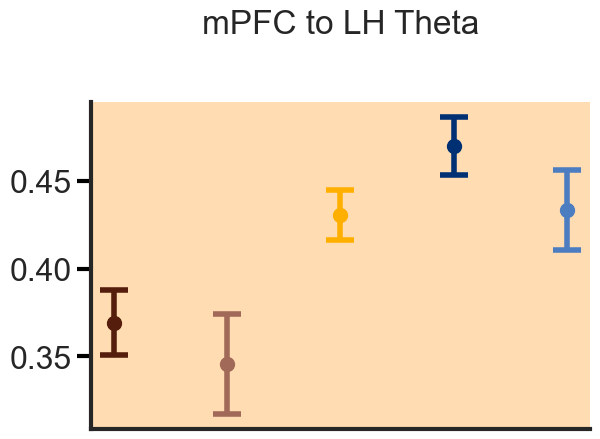

predicted_cluster_mean_trial_mPFC.to.MD_granger_gamma


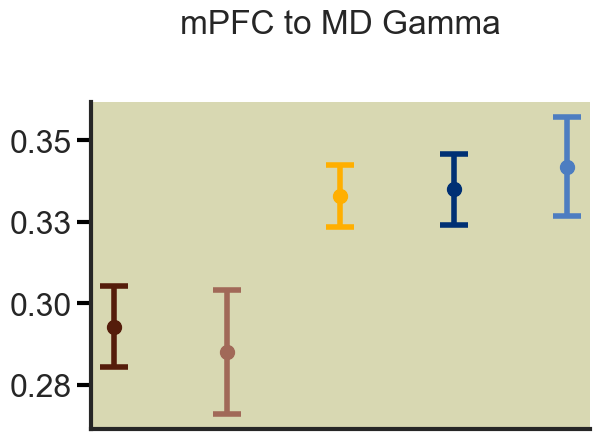

predicted_cluster_mean_trial_mPFC.to.MD_granger_theta


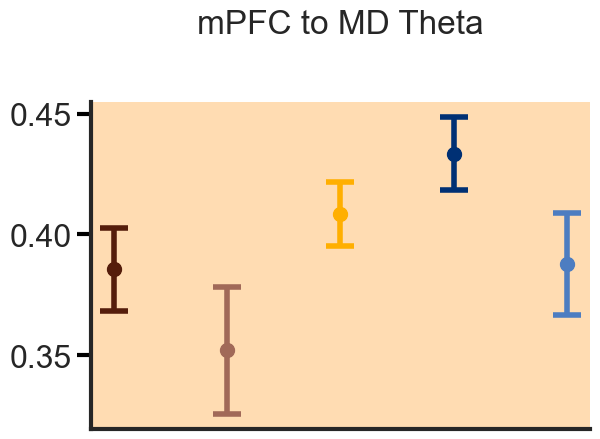

predicted_cluster_mean_trial_mPFC.to.vHPC_granger_gamma


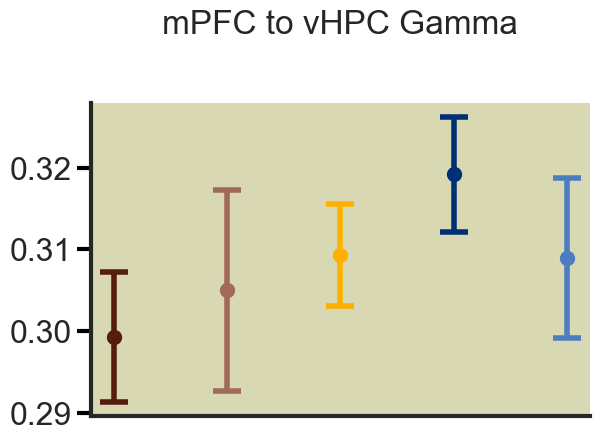

predicted_cluster_mean_trial_mPFC.to.vHPC_granger_theta


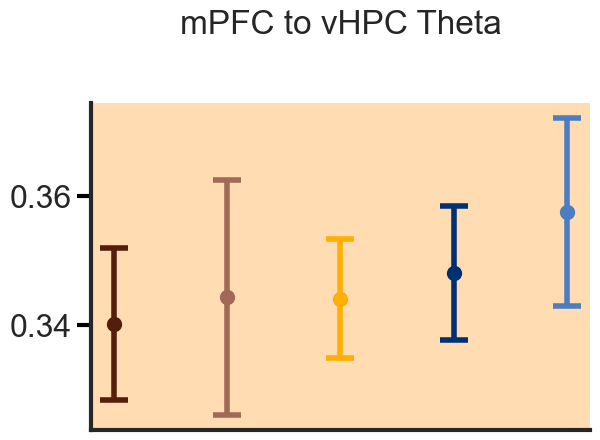

predicted_cluster_mean_trial_mPFC_power_gamma


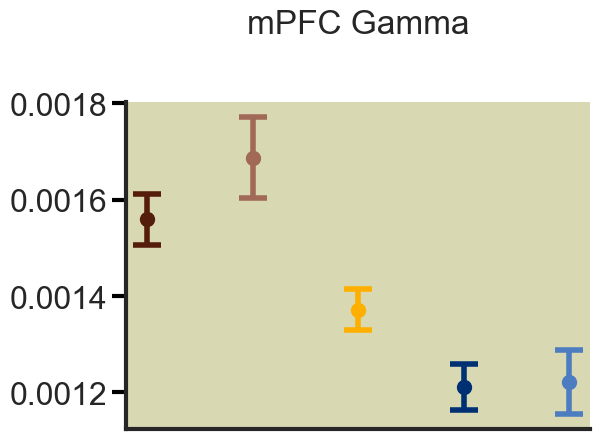

predicted_cluster_mean_trial_mPFC_power_theta


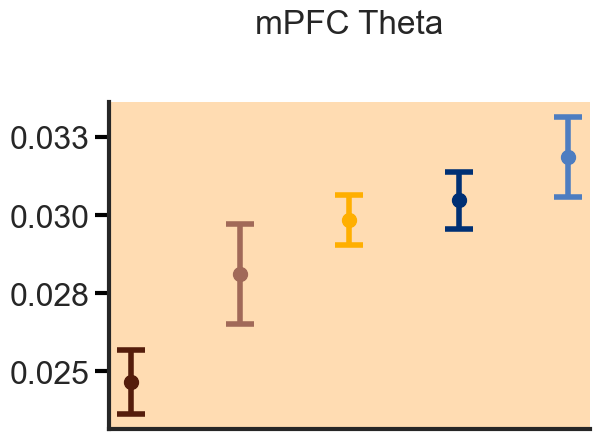

predicted_cluster_mean_trial_mPFC_vHPC_coherence_gamma


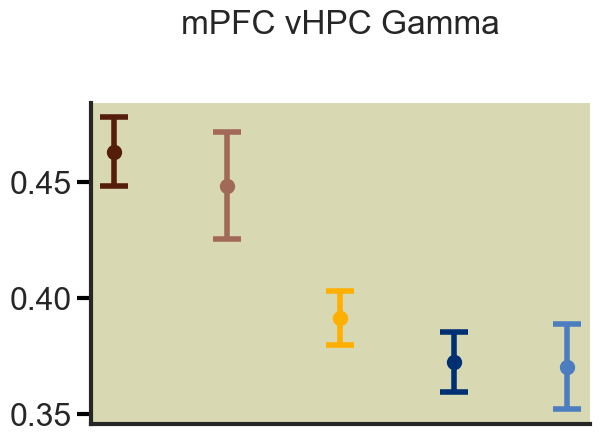

predicted_cluster_mean_trial_mPFC_vHPC_coherence_theta


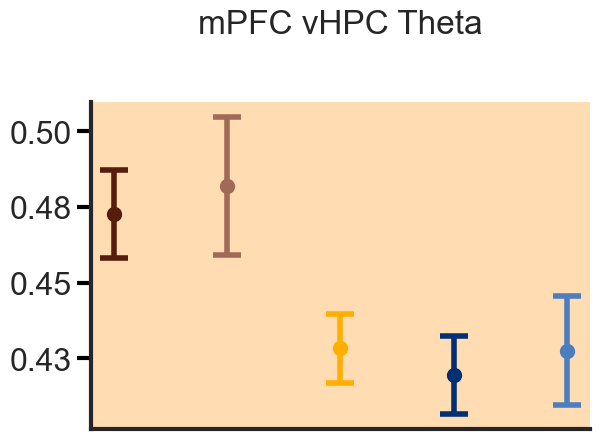

predicted_cluster_mean_trial_vHPC.to.BLA_granger_gamma


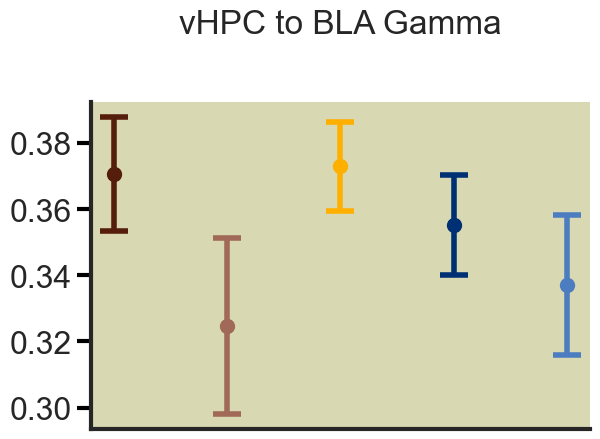

predicted_cluster_mean_trial_vHPC.to.BLA_granger_theta


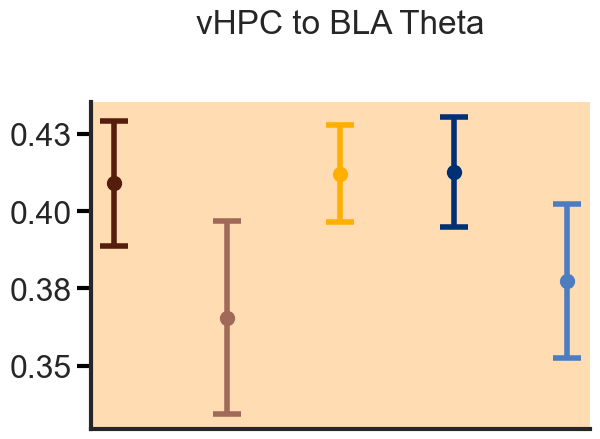

predicted_cluster_mean_trial_vHPC.to.LH_granger_gamma


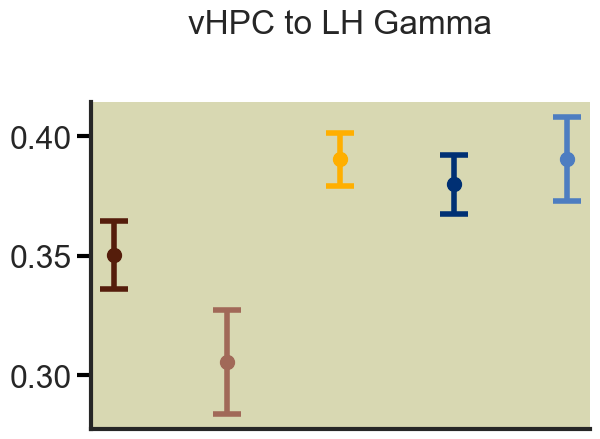

predicted_cluster_mean_trial_vHPC.to.LH_granger_theta


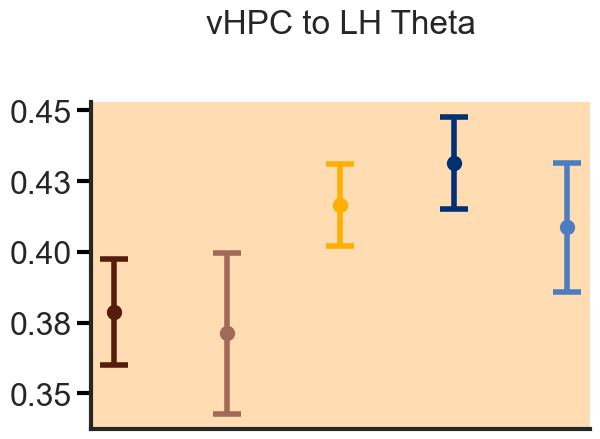

predicted_cluster_mean_trial_vHPC.to.MD_granger_gamma


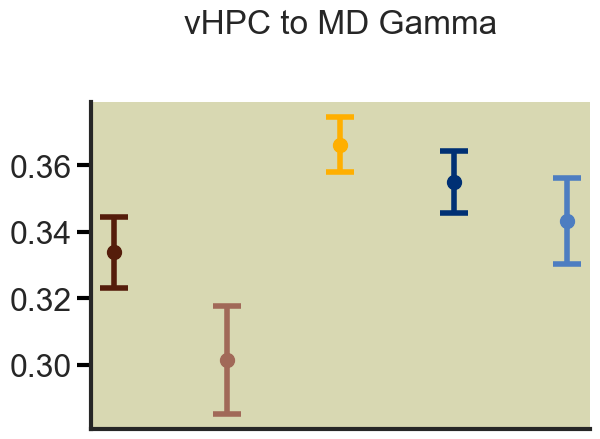

predicted_cluster_mean_trial_vHPC.to.MD_granger_theta


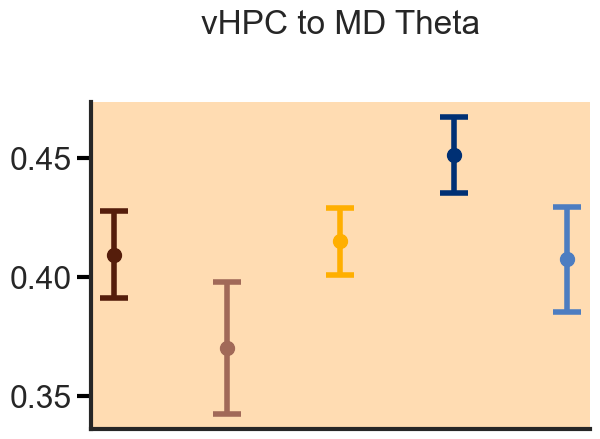

predicted_cluster_mean_trial_vHPC.to.mPFC_granger_gamma


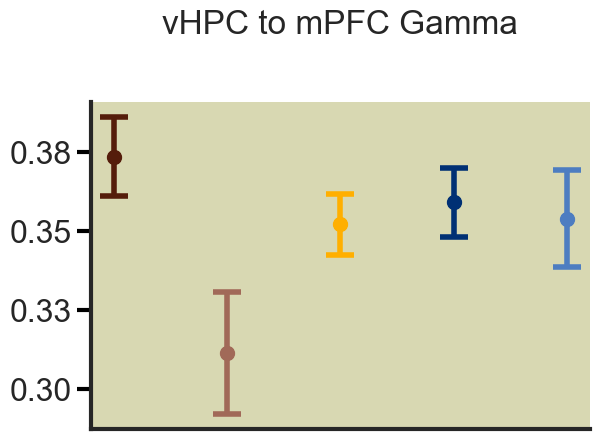

predicted_cluster_mean_trial_vHPC.to.mPFC_granger_theta


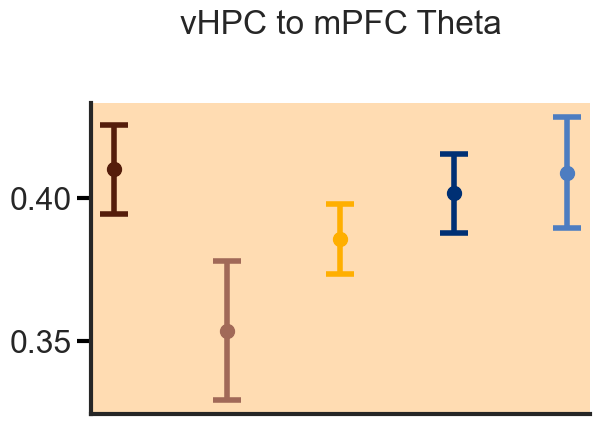

predicted_cluster_mean_trial_vHPC_power_gamma


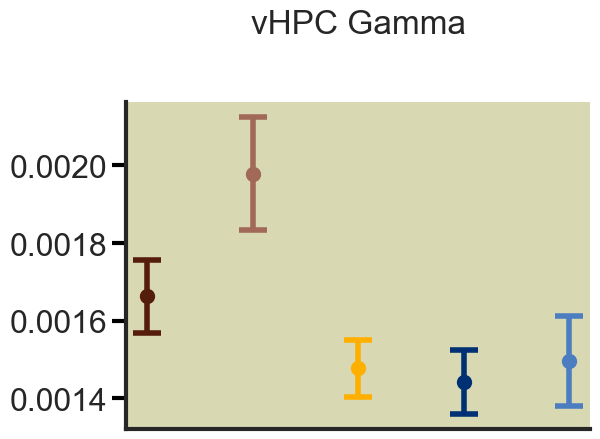

predicted_cluster_mean_trial_vHPC_power_theta


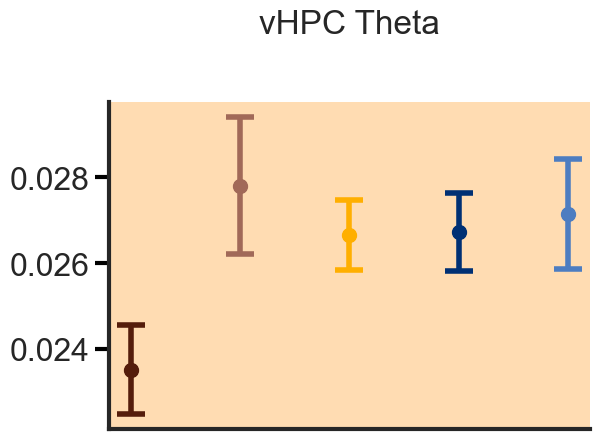

In [172]:
for col in [col for col in joined_df if ("cluster_mean_trial" in col and "all_frequencies" not in col and "predicted" in col)]:
    if "timestamps" in col:
        continue
    
    print(col)


    # Plot the transition matrix using only matplotlib
    fig, ax = plt.subplots(figsize=(6.4, 4.8))


    current_df = combined_emmeans_df[combined_emmeans_df["spectra_metric"] == col.replace("predicted_", "")]
    for index, row in current_df.sort_values(by=["trial_and_competitiveness_label"]).iterrows():
        plt.errorbar(row["trial_and_competitiveness_label"], row["emmean"], yerr=row["upper.CL"] - row["emmean"], fmt='o', color=row["color"],elinewidth=4, capsize=10, markeredgewidth=4)
        plt.scatter(row["trial_and_competitiveness_label"], row["emmean"], s = 100, marker = "o", color = row["color"])
        # plt.barh(row["trial_and_competitiveness_label"], row["emmean"], yerr=row["upper.CL"] - row["emmean"], fmt='o', color=row["color"])

        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False) # labels along the bottom edge are off
        
    # plt.ylabel('Estimated Marginal Means', size=20)

        # means.index, means, yerr=sems, fmt='o', color='black')

    # Hide top and right borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Leave bottom and left spines
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['left'].set_linewidth(3)

    ax.tick_params(axis='both', which='major', labelsize=23, length=10, width=3, color='black')
    ax.tick_params(axis='both', which='minor', labelsize=23, length=10, width=3, color='black')


    if "granger" in col:
        # title = "{}".format(col.replace(".", "-").replace("cluster_mean_trial_", "").replace("cluster_mean_trial_and_post_", "").replace("RMS_filtered_", "").replace("all_frequencies_all_windows", "").replace("power", "").replace("granger", "")).replace("coherence", "").replace("_", " ").replace("  ", " ").strip().replace(" ", " to ").replace("predicted", "").strip()
        title = col.replace("predicted_cluster_mean_trial_", "").replace("power", "").replace("granger", "").replace("coherence", "").replace("_", " ").replace("  ", " ").replace(".", " ")

    else:
        # title = "{}".format(col.replace(".", "-").replace("cluster_mean_trial_", "").replace("cluster_mean_trial_and_post_", "").replace("RMS_filtered_", "").replace("all_frequencies_all_windows", "").replace("power", "").replace("granger", "")).replace("coherence", "").replace("_", " ").replace("  ", " ").replace("predicted", "").strip()
        title = col.replace("predicted_cluster_mean_trial_", "").replace("power", "").replace("granger", "").replace("coherence", "").replace("_", " ").replace("  ", " ").replace(".", " ")

    if "coherence" in col or "granger" in col:
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    elif "power" in col:
        if "theta" in col:
            # ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
        elif "gamma" in col:
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))


    plt.title(title.replace("theta", "Theta").replace("gamma", "Gamma").replace("predicted", "").strip(),  pad=50)
    plt.tight_layout()
    
    if "coherence" in col:
        sub_dir = "coherence"

    elif "granger" in col:
        sub_dir = "granger"

    elif "power" in col: 
        sub_dir = "power"

    if "theta" in col:
        ax.patch.set_facecolor(BAND_TO_FREQ_COLOR["theta"])
        ax.patch.set_alpha(0.3)

    elif "gamma" in col:
        ax.patch.set_facecolor(BAND_TO_FREQ_COLOR["gamma"])
        ax.patch.set_alpha(0.3)

    plt.savefig("./proc/emmeans/{}/{}_emmeans.png".format(sub_dir, col.replace("cluster_mean_trial_", "").replace("predicted_", "")))
    plt.savefig("./proc/emmeans/{}/{}_emmeans.svg".format(sub_dir, col.replace("cluster_mean_trial_", "").replace("predicted_", "")))
    
    plt.show()


- Getting all the significant values

In [173]:
all_significance_df = []
for file_path in glob.glob("../../output_lmer_velocity/emmeans_csv/*"):
    if "with_CI" in file_path:
        continue
    current_df = pd.read_csv(file_path, index_col=0)
    all_significance_df.append(current_df)
combined_significance_df = pd.concat(all_significance_df)


In [174]:
combined_significance_df["contrast"].unique()

array(['rewarded - win_no_comp', 'rewarded - lose_no_comp',
       'rewarded - win_competitive', 'rewarded - lose_competitive',
       'win_no_comp - lose_no_comp', 'win_no_comp - win_competitive',
       'win_no_comp - lose_competitive', 'lose_no_comp - win_competitive',
       'lose_no_comp - lose_competitive',
       'win_competitive - lose_competitive'], dtype=object)

In [175]:
combined_significance_df = combined_significance_df[combined_significance_df["p.value"] <= 0.05]

In [176]:
combined_significance_df = combined_significance_df[combined_significance_df["contrast"].isin(valid_comparisons)]

In [177]:
combined_significance_df["signficance_stars"] = combined_significance_df["p.value"].apply(lambda x: get_signficance_stars(x))

In [178]:
combined_significance_df["metric"] = combined_significance_df["spectra_metric"].apply(lambda x: x.split("_")[-2])
combined_significance_df["band"] = combined_significance_df["spectra_metric"].apply(lambda x: x.split("_")[-1])

In [179]:
combined_significance_df["contrast"] = combined_significance_df["contrast"].apply(lambda x: sorted([word.strip() for word in x.split("-")]))

In [180]:
combined_significance_df["label_1"] = combined_significance_df["contrast"].apply(lambda x: x[0])
combined_significance_df["label_2"] = combined_significance_df["contrast"].apply(lambda x: x[1])

In [181]:
combined_significance_df["is_comp_comparison"] = combined_significance_df["contrast"].apply(lambda x: x[0].split("_")[0] == x[1].split("_")[0])

In [182]:
combined_significance_df = combined_significance_df.sort_values(["metric", "band", "spectra_metric", "label_1", "label_2"])

In [183]:
combined_significance_df[combined_significance_df["metric"] == "power"].tail(n=50)
# combined_significance_df[combined_significance_df["metric"] == "coherence"].head(n=50)
# combined_significance_df[(combined_significance_df["metric"] == "granger") & (combined_significance_df["spectra_metric"].str.contains("mPFC"))].shape

contrast  estimate        SE   df    t.ratio  \
3           [rewarded, win_competitive] -0.000517  0.000139  749  -3.708269   
4          [lose_competitive, rewarded] -0.000192  0.000037  734  -5.212095   
10  [lose_competitive, win_competitive] -0.000246  0.000038  734  -6.432820   
5           [lose_no_comp, win_no_comp] -0.000259  0.000057  734  -4.508952   
9      [lose_competitive, lose_no_comp]  0.000391  0.000057  745   6.808991   
4          [lose_competitive, rewarded] -0.000198  0.000040  745  -4.891679   
10  [lose_competitive, win_competitive] -0.000245  0.000042  745  -5.849936   
5           [lose_no_comp, win_no_comp] -0.000637  0.000063  745 -10.163659   
4          [lose_competitive, rewarded] -0.000187  0.000035  751  -5.327691   
10  [lose_competitive, win_competitive] -0.000348  0.000036  751  -9.547793   
5           [lose_no_comp, win_no_comp] -0.000466  0.000055  751  -8.477992   
3           [rewarded, win_competitive]  0.000161  0.000032  751   4.956136   
1               [rewarded, win_no_comp]  0.000151  0.000040  751   3.780779   
9      [lose_competitive, lose_no_comp]  0.000315  0.000087  748   3.617078   
4          [lose_competitive, rewarded] -0.000185  0.000062  748  -3.010085   
10  [lose_competitive, win_competitive] -0.000220  0.000064  748  -3.454344   
5           [lose_no_comp, win_no_comp] -0.000481  0.000096  748  -5.038139   
9      [lose_competitive, lose_no_comp]  0.006550  0.000934  749   7.015304   
10  [lose_competitive, win_competitive]  0.002027  0.000678  749   2.987804   
5           [lose_no_comp, win_no_comp] -0.005523  0.001024  749  -5.393550   
9      [lose_competitive, lose_no_comp]  0.007043  0.001181  734   5.964089   
5           [lose_no_comp, win_no_comp] -0.005843  0.001291  734  -4.524030   
3           [rewarded, win_competitive] -0.002984  0.000807  745  -3.698255   
9      [lose_competitive, lose_no_comp]  0.003452  0.000965  751   3.578105   
4          [lose_competitive, rewarded]  0.005194  0.000676  751   7.684939   
10  [lose_competitive, win_competitive]  0.005826  0.000701  751   8.312655   
5           [lose_no_comp, win_no_comp]  0.003745  0.001058  751   3.539521   
9      [lose_competitive, lose_no_comp]  0.004287  0.000963  748   4.454501   
4          [lose_competitive, rewarded]  0.003148  0.000680  748   4.629961   
10  [lose_competitive, win_competitive]  0.003206  0.000705  748   4.549755   

         p.value                       spectra_metric signficance_stars  \
3   2.240904e-03   cluster_mean_trial_BLA_power_gamma                **   
4   2.429461e-06    cluster_mean_trial_LH_power_gamma               ***   
10  2.258156e-09    cluster_mean_trial_LH_power_gamma               ***   
5   7.581698e-05    cluster_mean_trial_LH_power_gamma               ***   
9   2.024478e-10    cluster_mean_trial_MD_power_gamma               ***   
4   1.225650e-05    cluster_mean_trial_MD_power_gamma               ***   
10  7.362289e-08    cluster_mean_trial_MD_power_gamma               ***   
5   8.173106e-22    cluster_mean_trial_MD_power_gamma               ***   
4   1.315993e-06  cluster_mean_trial_mPFC_power_gamma               ***   
10  1.816330e-19  cluster_mean_trial_mPFC_power_gamma               ***   
5   1.208321e-15  cluster_mean_trial_mPFC_power_gamma               ***   
3   8.892710e-06  cluster_mean_trial_mPFC_power_gamma               ***   
1   1.687479e-03  cluster_mean_trial_mPFC_power_gamma                **   
9   3.179633e-03  cluster_mean_trial_vHPC_power_gamma                **   
4   2.699552e-02  cluster_mean_trial_vHPC_power_gamma                 *   
10  5.827108e-03  cluster_mean_trial_vHPC_power_gamma                **   
5   5.898823e-06  cluster_mean_trial_vHPC_power_gamma               ***   
9   5.138300e-11   cluster_mean_trial_BLA_power_theta               ***   
10  2.901686e-02   cluster_mean_trial_BLA_power_theta                 *   
5   9.270268e-07   cluster_mean_trial_BLA_power_theta               ***   
9   3.

In [184]:
# combined_significance_df[(combined_significance_df["metric"] == "granger") & (combined_significance_df["spectra_metric"].str.contains("mPFC"))]
combined_significance_df[(combined_significance_df["metric"] == "granger") & (~combined_significance_df["spectra_metric"].str.contains("mPFC")) & (combined_significance_df["signficance_stars"] == "***")]

contrast  estimate        SE   df    t.ratio  \
9      [lose_competitive, lose_no_comp]  0.024859  0.006260  742   3.970852   
5           [lose_no_comp, win_no_comp] -0.034280  0.006832  742  -5.017571   
4          [lose_competitive, rewarded]  0.040099  0.009300  730   4.311862   
5           [lose_no_comp, win_no_comp]  0.084893  0.014389  730   5.899816   
4          [lose_competitive, rewarded]  0.032514  0.006951  740   4.677347   
4          [lose_competitive, rewarded] -0.054374  0.011989  732  -4.535473   
10  [lose_competitive, win_competitive] -0.072531  0.012432  732  -5.834418   
9      [lose_competitive, lose_no_comp]  0.070766  0.011178  742   6.331104   
4          [lose_competitive, rewarded] -0.054129  0.007883  742  -6.866649   
10  [lose_competitive, win_competitive] -0.036351  0.008174  742  -4.447288   
5           [lose_no_comp, win_no_comp] -0.127927  0.012198  742 -10.487433   
9      [lose_competitive, lose_no_comp]  0.065147  0.014825  732   4.394421   
5           [lose_no_comp, win_no_comp] -0.067390  0.016214  732  -4.156356   
3           [rewarded, win_competitive] -0.038153  0.009597  732  -3.975404   
5           [lose_no_comp, win_no_comp] -0.079793  0.016728  740  -4.770037   
10  [lose_competitive, win_competitive]  0.052550  0.012538  729   4.191192   

         p.value                               spectra_metric  \
9   7.858743e-04   cluster_mean_trial_MD.to.BLA_granger_gamma   
5   6.555054e-06   cluster_mean_trial_MD.to.BLA_granger_gamma   
4   1.841281e-04  cluster_mean_trial_vHPC.to.LH_granger_gamma   
5   5.567430e-08  cluster_mean_trial_vHPC.to.LH_granger_gamma   
4   3.454628e-05  cluster_mean_trial_vHPC.to.MD_granger_gamma   
4   6.714268e-05    cluster_mean_trial_LH.to.MD_granger_theta   
10  8.103903e-08    cluster_mean_trial_LH.to.MD_granger_theta   
9   4.213104e-09   cluster_mean_trial_MD.to.BLA_granger_theta   
4   1.390452e-10   cluster_mean_trial_MD.to.BLA_granger_theta   
10  1.002713e-04   cluster_mean_trial_MD.to.BLA_granger_theta   
5   4.331566e-23   cluster_mean_trial_MD.to.BLA_granger_theta   
9   1.274967e-04    cluster_mean_trial_MD.to.LH_granger_theta   
5   3.616067e-04    cluster_mean_trial_MD.to.LH_granger_theta   
3   7.722698e-04    cluster_mean_trial_MD.to.LH_granger_theta   
5   2.219094e-05  cluster_mean_trial_MD.to.vHPC_granger_theta   
10  3.115671e-04  cluster_mean_trial_vHPC.to.LH_granger_theta   

   signficance_stars   metric   band           label_1          label_2  \
9                ***  granger  gamma  lose_competitive     lose_no_comp   
5                ***  granger  gamma      lose_no_comp      win_no_comp   
4                ***  granger  gamma  lose_competitive         rewarded   
5                ***  granger  gamma      lose_no_comp      win_no_comp   
4                ***  granger  gamma  lose_competitive         rewarded   
4                ***  granger  theta  lose_competitive         rewarded   
10               ***  granger  theta  lose_competitive  win_competitive   
9                ***  granger  theta  lose_competitive     lose_no_comp   
4                ***  granger  theta  lose_competitive         rewarded   
10               ***  granger  theta  lose_competitive  win_competitive   
5                ***  granger  theta      lose_no_comp      win_no_comp   
9                ***  granger  theta  lose_competitive     lose_no_comp   
5                ***  granger  theta      lose_no_comp      win_no_comp   
3                ***  granger  theta          rewarded  win_competitive   
5                ***  granger  theta      lose_no_comp      win_no_comp   
10               ***  granger  theta  lose_competitive  win_competitive   

    is_comp_comparison  
9                 True  
5                False  
4                False  
5                False  
4                False  
4                False  
10               False  
9                 True  
4                False  
10               False  
5                False  
9    